In [1]:
import os
import sqlite3

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd
import pycountry
import seaborn as sns

In [2]:
QUERY_ALL = """
SELECT 
    Users.user_id AS user_id, 
    Users.creation_time AS user_creation_time, 
    Tweets.creation_time AS tweet_creation_time,
    Tweets.tweet_id,
    Tweets.full_text,
    Tweets.lang,
    Tweets.country_code,
    Tweets.sentiment_score
FROM Users
INNER JOIN Tweets ON Users.user_id = Tweets.user_id;
"""

QUERY_CONVERSATIONS = """
SELECT * FROM Conversations;
"""

DTYPES = {
"user_id": "object",
"tweet_id": "object",
"full_text": "object",
"lang": "category",
"country_code": "category",
"sentiment_score": "float32",
}

COMPANY_NAME_TO_ID = {
    "Klm": "56377143",
    "Air France": "106062176",
    "British Airways": "18332190",
    "American Air": "22536055",
    "Lufthansa": "124476322",
    "Air Berlin": "26223583",
    "Air Berlin assist": "2182373406",
    "easyJet": "38676903",
    "Ryanair": "1542862735",
    "Singapore Airlines": "253340062",
    "Qantas": "218730857",
    "Etihad Airways": "45621423",
    "Virgin Atlantic": "20626359",
}
COMPANY_ID_LIST = list(COMPANY_NAME_TO_ID.values())
COMPANY_NAME_LIST = list(COMPANY_NAME_TO_ID.keys())
COMPANY_ID_TO_NAME = {v: k for k, v in COMPANY_NAME_TO_ID.items()}

In [3]:
def get_full_language_name(language_code: str,
                           default: str="Undefined Language") -> str:
    """
    Convert a two-letter language code (ISO 639-1) to its full language name.
    
    Parameters:
    language_code (str): The two-letter ISO 639-1 language code.
    
    Returns:
    str: The full name of the language or a message indicating the code was not found.
    """
    if language_code=="Other languages":
        return language_code
    language = pycountry.languages.get(alpha_2=language_code, default=default)
    if language != default:
        language = language.name
    return language


def get_country_name(country_code: str, default: str="Unknown Country") -> str:
    """
    Convert a two-letter country code (ISO 3166-1 alpha-2|) to its full country name.
    
    Parameters:
    country_code (str): The two-letter ISO 3166-1 alpha-2 country code.
    
    Returns:
    str: The full name of the country or a message indicating the code was not found.
    """
    country = pycountry.countries.get(alpha_2=country_code, default=default)
    if country != default:
        country = country.name
    return country

def get_tweets_with_users(query: str, path: str) -> pd.DataFrame:
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection,
                                 dtype=DTYPES,
                                 parse_dates=["tweet_creation_time", "user_creation_time"],
                                 index_col='tweet_id')


def get_conversations(query: str, path: str) -> pd.DataFrame:
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection,
                                 dtype={"conversation_id": "object", "tweet_order": "int16", "tweet_id": "object"},
                                 index_col=["conversation_id", "tweet_order"])

def get_categories(query, path):
    with sqlite3.connect(path) as connection:
        return pd.read_sql_query(query, connection)

In [4]:
path =  os.path.join(
    os.path.dirname(   
        os.path.dirname(
            os.getcwd()
        )),
    "data_processed", "local_backup.db")
df_tweets_and_users = get_tweets_with_users(QUERY_ALL, path)
df_conversations = get_conversations(QUERY_CONVERSATIONS, path)

In [5]:
df_tweets_and_users

user_id        user_creation_time  \
tweet_id                                                             
1131172858951024641            393374091 2011-10-18 12:55:25+00:00   
1130922003702177800   880417607865815040 2017-06-29 13:28:09+00:00   
1131172864147808257           3420691215 2015-08-13 19:18:07+00:00   
1131172867985485824            394376606 2011-10-20 00:02:49+00:00   
1131030279278063616            227687574 2010-12-17 14:37:53+00:00   
...                                  ...                       ...   
1244696703690772485            278698748 2011-04-07 19:55:35+00:00   
1244696708983984131            246520593 2011-02-02 23:06:38+00:00   
1244696710447800320            109284383 2010-01-28 15:09:19+00:00   
1244696713350217728  1223576386432126976 2020-02-01 11:59:19+00:00   
1244696713765564416             56784613 2009-07-14 19:11:05+00:00   

                          tweet_creation_time  \
tweet_id                                        
1131172858951024641 2019-05-22 12:20:00+00:00   
1130922003702177800 2019-05-21 19:43:11+00:00   
1131172864147808257 2019-05-22 12:20:01+00:00   
1131172867985485824 2019-05-22 12:20:02+00:00   
1131030279278063616 2019-05-22 02:53:26+00:00   
...                                       ...   
1244696703690772485 2020-03-30 18:43:14+00:00   
1244696708983984131 2020-03-30 18:43:15+00:00   
1244696710447800320 2020-03-30 18:43:15+00:00   
1244696713350217728 2020-03-30 18:43:16+00:00   
1244696713765564416 2020-03-30 18:43:16+00:00   

                                                             full_text lang  \
tweet_id                                                                      
1131172858951024641  La ruta de easyJet entre Londres y Menorca tra...   es   
1130922003702177800  @goody_tracy Here’s a list of some of @JonesDa...   en   
1131172864147808257  RT @bttr_as1: @goody_tracy Here’s a list of so...   en   
1131172867985485824                                   @British_Airways  und   
1131030279278063616  Nice change by @AmericanAir. Bikes now pay sta...   en   
...                                                                ...  ...   
1244696703690772485  RT @jfergo86: Me parece a mí o el avión es más...   es   
1244696708983984131  Today’s random pic of the day is the one of Vo...   en   
1244696710447800320  RT @SchipholWatch: @spbverhagen @markduursma @...   nl   
1244696713350217728  RT @wiltingklaas: Tweede Kamer stemt over vlie...   nl   
1244696713765564416  @easyJet My refund is being process since two ...   en   

                    country_code  sentiment_score  
tweet_id                                           
1131172858951024641           un        -0.037224  
1130922003702177800           un        -0.045324  
1131172864147808257           un        -0.051741  
1131172867985485824           un        -0.033292  
1131030279278063616           un        -0.047510  
...                          ...              ...  
1244696703690772485           un        -0.386010  
1244696708983984131           un         0.872379  
1244696710447800320           un        -0.553437  
1244696713350217728           un        -0.043661  
1244696713765564416           un        -0.458997  

[6148105 rows x 7 columns]

In [6]:
df_conversations

tweet_id
conversation_id tweet_order                     
1               1            1244694453190897664
                2            1244696682979303426
2               1            1244677304598609923
                2            1244696641401163776
3               1            1244644204132909060
...                                          ...
493694          3             452657442057646080
493695          1             451124070730719233
                2             451125255294443521
493696          1             430790355962052608
                2             430792524043931648

[1346566 rows x 1 columns]

In [7]:
df_all = df_conversations.merge(df_tweets_and_users, left_on='tweet_id', right_index=True, how='left')
df_all

tweet_id             user_id  \
conversation_id tweet_order                                            
1               1            1244694453190897664           521835883   
                2            1244696682979303426            20626359   
2               1            1244677304598609923           396021583   
                2            1244696641401163776  832964639436701696   
3               1            1244644204132909060           274980475   
...                                          ...                 ...   
493694          3             452657442057646080          2198564846   
493695          1             451124070730719233           701977520   
                2             451125255294443521            22536055   
493696          1             430790355962052608            64327804   
                2             430792524043931648            22536055   

                                   user_creation_time  \
conversation_id tweet_order                             
1               1           2012-03-12 01:11:22+00:00   
                2           2009-02-11 20:50:56+00:00   
2               1           2011-10-22 16:35:05+00:00   
                2           2017-02-18 14:47:00+00:00   
3               1           2011-03-31 11:55:53+00:00   
...                                               ...   
493694          3           2013-11-16 23:24:47+00:00   
493695          1           2012-07-17 23:34:18+00:00   
                2           2009-03-02 21:23:05+00:00   
493696          1           2009-08-10 03:34:27+00:00   
                2           2009-03-02 21:23:05+00:00   

                                  tweet_creation_time  \
conversation_id tweet_order                             
1               1           2020-03-30 18:34:17+00:00   
                2           2020-03-30 18:43:09+00:00   
2               1           2020-03-30 17:26:09+00:00   
                2           2020-03-30 18:42:59+00:00   
3               1           2020-03-30 15:14:37+00:00   
...                                               ...   
493694          3           2014-04-06 04:01:58+00:00   
493695          1           2014-04-01 22:28:54+00:00   
                2           2014-04-01 22:33:37+00:00   
493696          1           2014-02-04 19:49:59+00:00   
                2           2014-02-04 19:58:36+00:00   

                                                                     full_text  \
conversation_id tweet_order                                                      
1               1            @nealrach @VirginAtlantic Siiiigh.... Still no...   
                2            @Jade_Velveteese Hi Jade. We have an ‘Away fro...   
2               1            @VirginAtlantic Sod off your primary sharehold...   
                2            @Boyde11 @VirginAtlantic Get your facts right,...   
3               1                              @easyJet Please reply to my DM!   
...                                                                        ...   
493694          3                     @AmericanAir They cannot hear my screams   
493695          1            @AmericanAir i was kidding thanks for the foll...   
                2            @lanaupdates_ Your information has been forwar...   
493696          1            @AmericanAir phew, they finally turned on the ...   
                2            @benjy_greenberg It looks like we'll have you ...   

                            lang country_code  sentiment_score  
conversation_id tweet_order                                     
1               1             en           un         0.292771  
                2             en           un         0.190686  
2               1             en           un        -0.909571  
                2             en           un         0.058692  
3               1             en           un         0.076921  
...                          ...          ...              ...  
493694          3             en

In [8]:
df_reset = df_all.reset_index()
df_reset['airline'] = df_reset['user_id'].map(COMPANY_ID_TO_NAME)

# Conversations

## Number and length of conversations

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


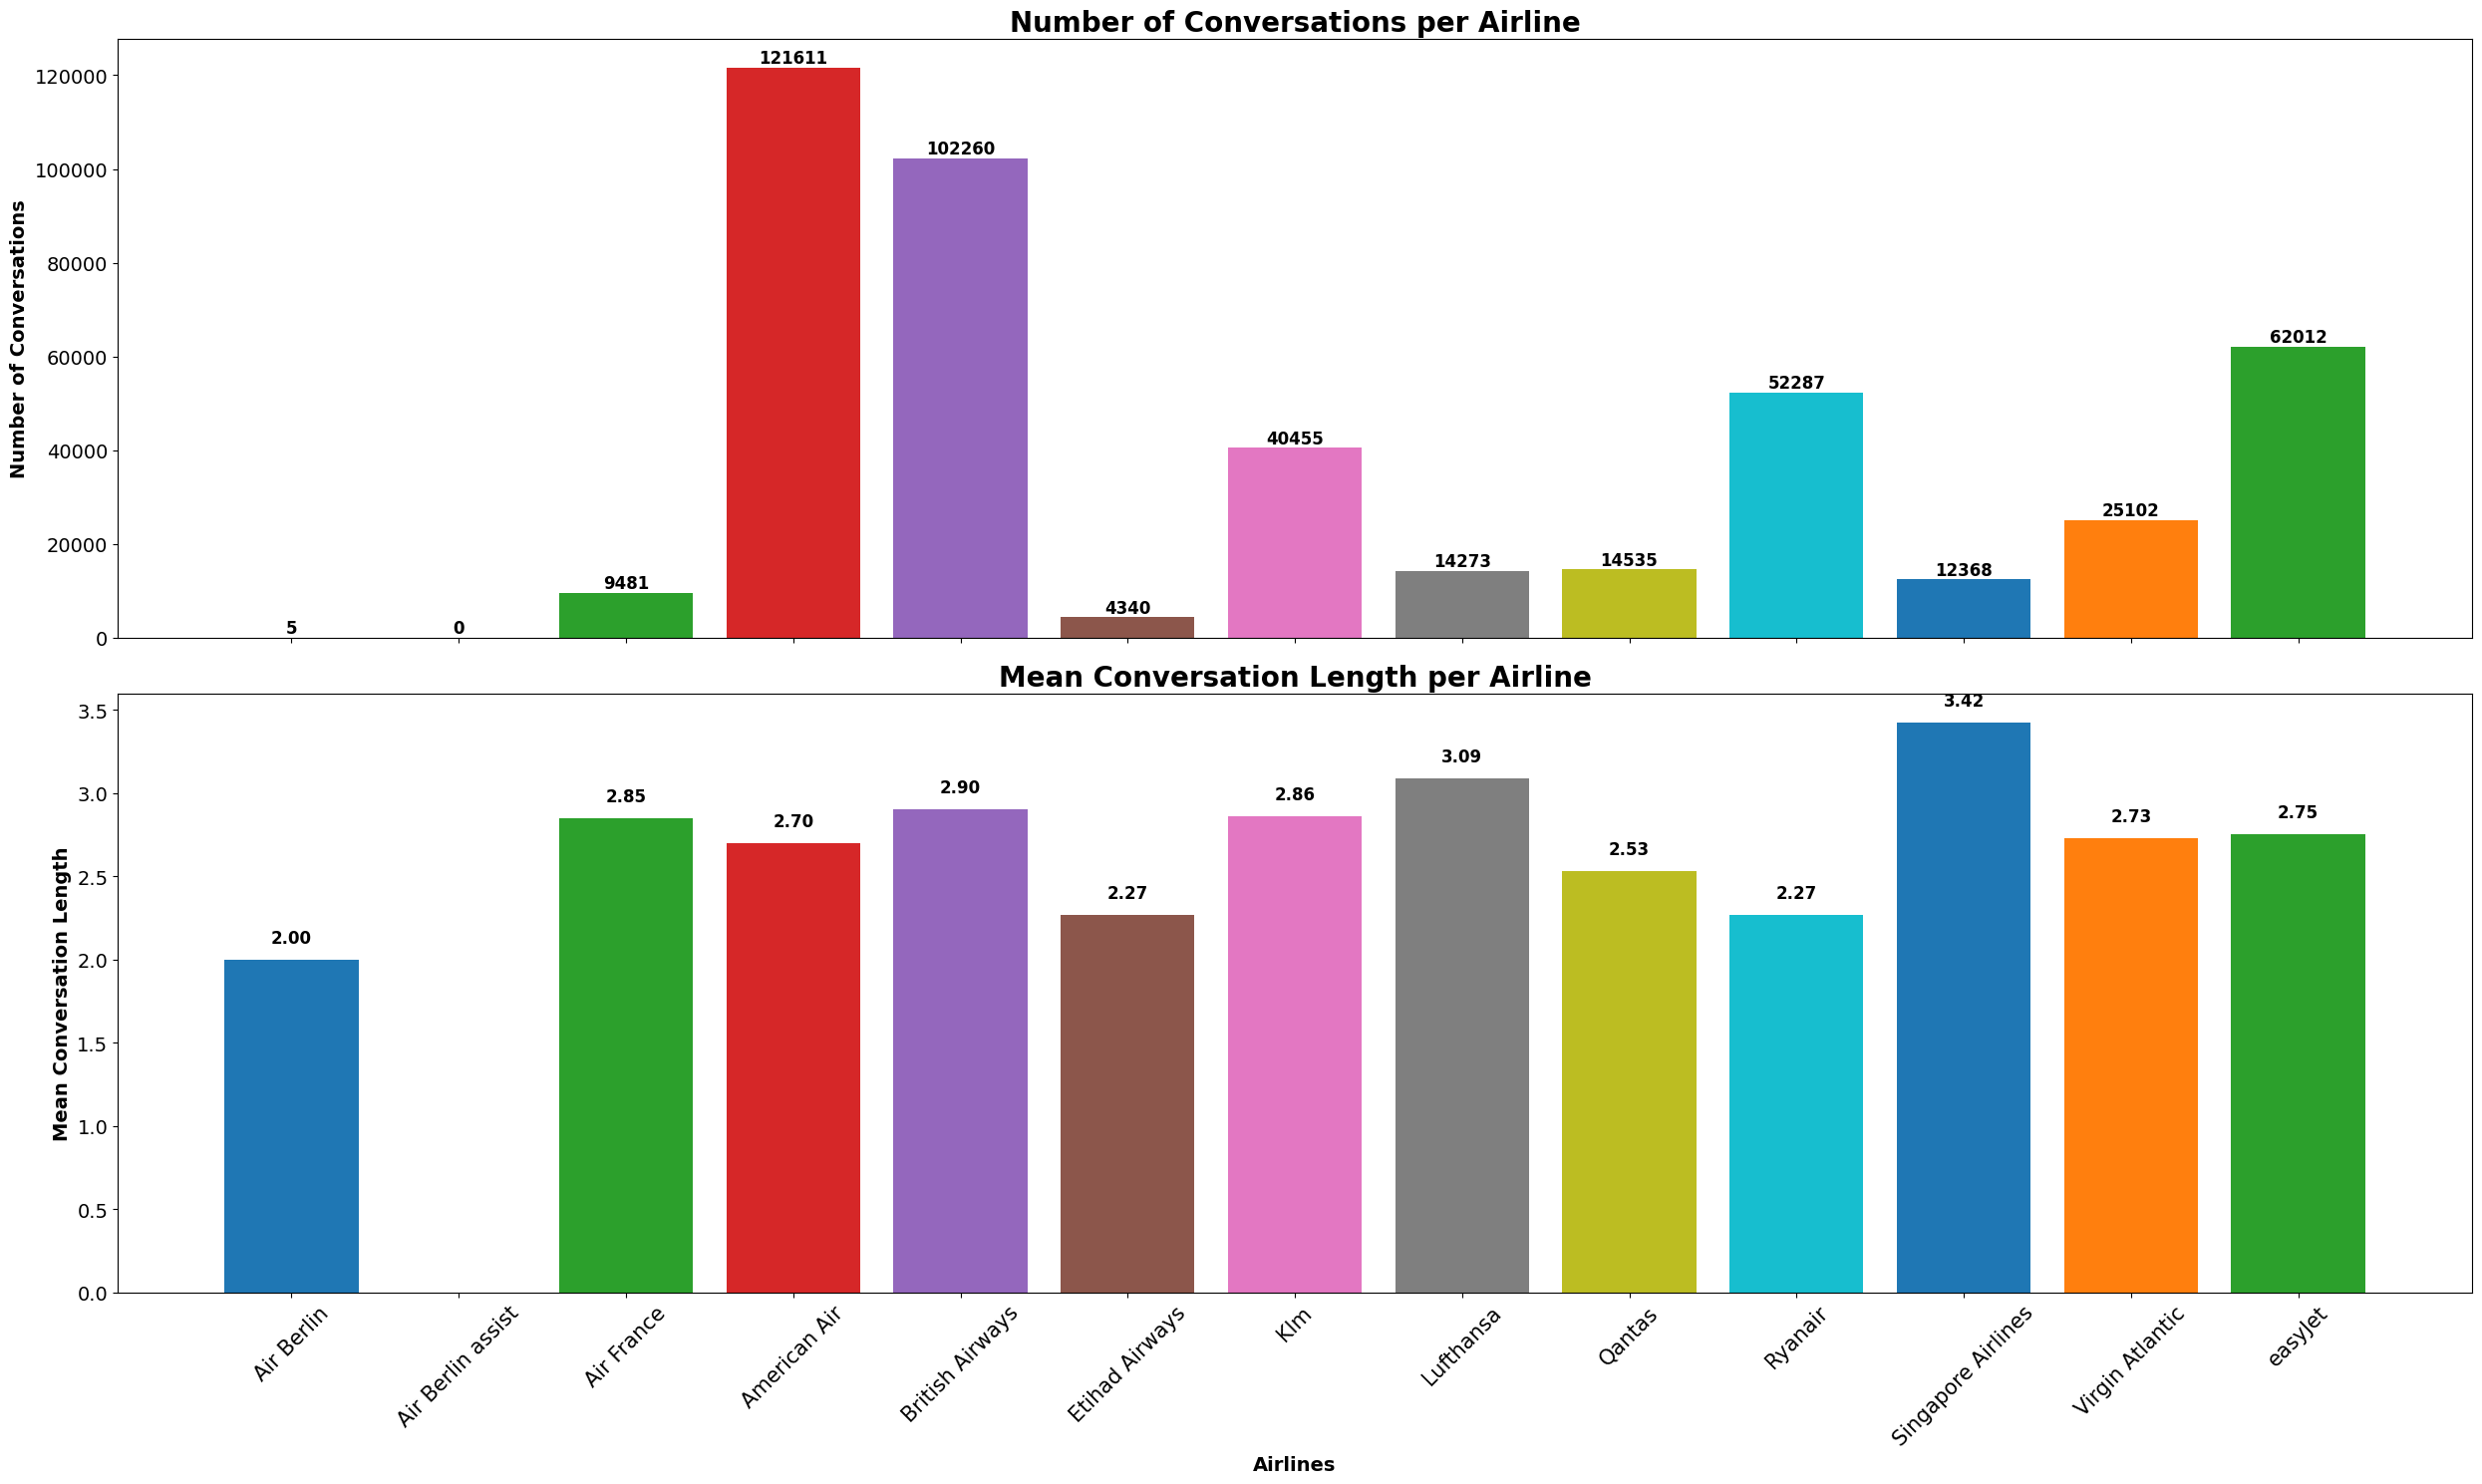

In [9]:
user_conversations_count = {}

# Calculate the number of conversations per user
for user_id in COMPANY_ID_LIST:
    # Filter the DataFrame to include only rows where the specific user is involved
    filtered_df = df_reset[df_reset['user_id'] == user_id]
    
    # Identify unique conversation IDs
    unique_conversations = filtered_df['conversation_id'].unique()
    
    # Count the number of unique conversations
    num_unique_conversations = len(unique_conversations)
    
    # Store the count in the dictionary
    name = COMPANY_ID_TO_NAME[user_id]
    user_conversations_count[name] = num_unique_conversations

# Use a predefined color scheme
colors = list(mcolors.TABLEAU_COLORS.values())

# Sort the dictionary by airline names alphabetically
sorted_user_conversations_count = dict(sorted(user_conversations_count.items(), key=lambda item: item[0]))

# Calculate the length of each conversation
conversation_lengths = df_reset.groupby('conversation_id').size().reset_index(name='conversation_length')

# Group by conversation_id and get the airline name
df_airline = df_reset.groupby('conversation_id')['airline'].first().reset_index()

# Filter out conversations without an airline
df_airline_count = df_airline.dropna(subset=['airline'])

# Merge to get mean conversation length per airline
mean_conversation_length = pd.merge(df_airline_count, conversation_lengths, on='conversation_id').groupby("airline").mean()["conversation_length"]

# Sort by airline names alphabetically to match the first plot
sorted_mean_conversation_length = mean_conversation_length.reindex(sorted_user_conversations_count.keys())

# Plot the graphs together in two rows sharing the same x-axis
fig, axs = plt.subplots(2, 1, figsize=(25, 15), sharex=True)

# Plot the number of conversations per airline
bars1 = axs[0].bar(sorted_user_conversations_count.keys(), sorted_user_conversations_count.values(), color=colors[:len(sorted_user_conversations_count)])
axs[0].set_ylabel('Number of Conversations', fontsize=14, fontweight='bold')
axs[0].set_title('Number of Conversations per Airline', fontsize=20, fontweight='bold')
axs[0].tick_params(axis='x', rotation=45, labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)

# Add data labels on top of each bar
for bar in bars1:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold')

# Plot the mean conversation length per airline
bars2 = axs[1].bar(sorted_mean_conversation_length.index, sorted_mean_conversation_length.values, color=colors[:len(sorted_mean_conversation_length)])
axs[1].set_xlabel('Airlines', fontsize=14, fontweight='bold')
axs[1].set_ylabel('Mean Conversation Length', fontsize=14, fontweight='bold')
axs[1].set_title('Mean Conversation Length per Airline', fontsize=20, fontweight='bold')
axs[1].tick_params(axis='x', rotation=45, labelsize=15)
axs[1].tick_params(axis='y', labelsize=14)

# Add data labels on top of each bar
for bar in bars2:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.1, f'{yval:.2f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()

Text(0.5, 1.0, 'Distribution of Conversations by Number of Tweets')

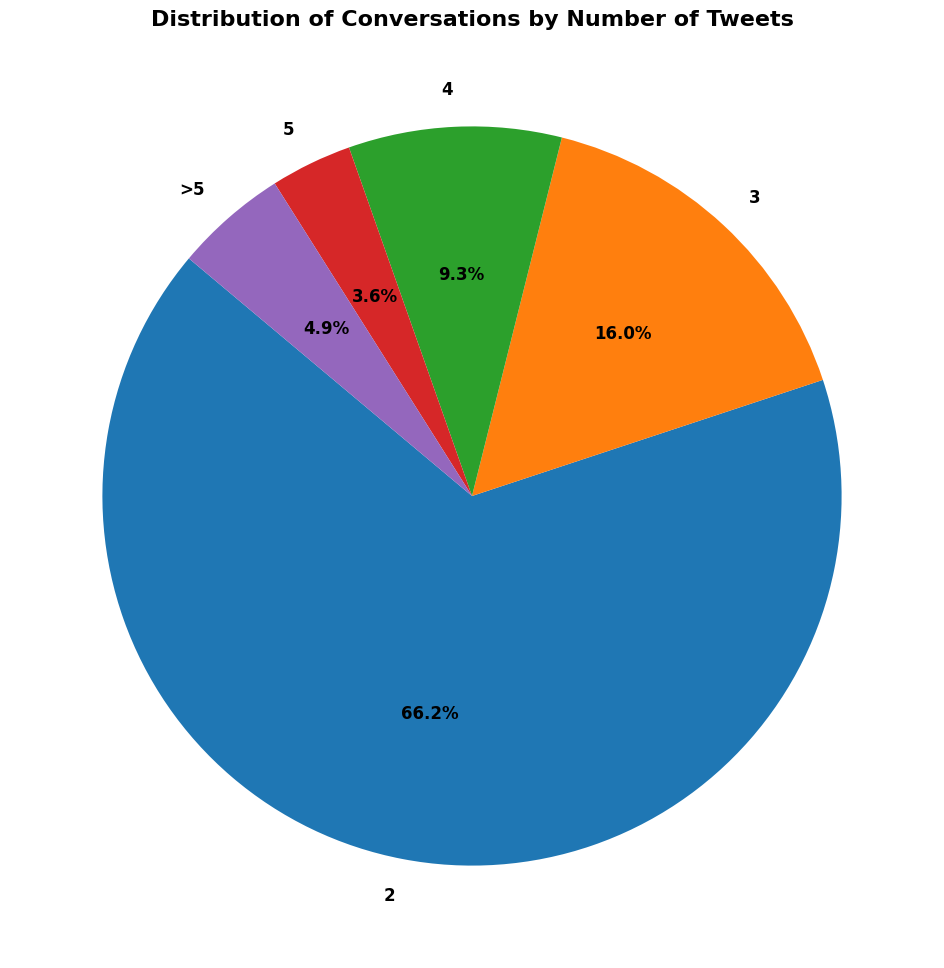

In [10]:

# Assuming df_reset is already available
# Group by conversation_id and count the number of tweets per conversation
conversation_counts = df_reset.groupby('conversation_id').size()

# Group conversations with more than 5 tweets into a single category
conversation_counts = conversation_counts.apply(lambda x: str(x) if x <= 5 else '>5')

# Count the number of conversations for each unique number of tweets
conversation_counts_dist = conversation_counts.value_counts().sort_index()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the pie chart
plt.figure(figsize=(12, 12))
patches, texts, autotexts = plt.pie(conversation_counts_dist, labels=conversation_counts_dist.index, colors=colors[:len(conversation_counts_dist)], autopct='%1.1f%%', startangle=140)

# Set the font properties for labels and autotexts
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.title('Distribution of Conversations by Number of Tweets', fontsize=16, fontweight='bold')

# Add legend


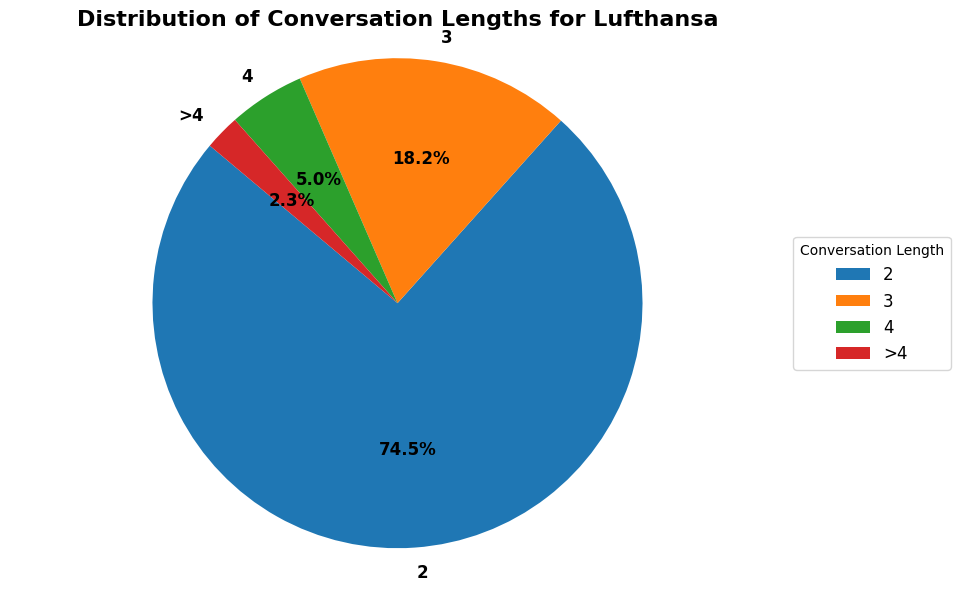

In [11]:
# Filter the DataFrame to include only rows for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_df = df_reset[df_reset['user_id'] == lufthansa_user_id]

# Calculate the length of each conversation for Lufthansa
lufthansa_conversation_lengths = lufthansa_df.groupby('conversation_id').size().reset_index(name='conversation_length')

# Group conversation lengths into bins
bins = [1, 2, 3, 4, float('inf')]
labels = ['2', '3', '4', '>4']
lufthansa_conversation_lengths['length_bin'] = pd.cut(lufthansa_conversation_lengths['conversation_length'], bins=bins, labels=labels, right=False)

# Count the number of conversations in each bin
length_distribution = lufthansa_conversation_lengths['length_bin'].value_counts().sort_index()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the pie chart
plt.figure(figsize=(10, 7))
wedges, texts, autotexts = plt.pie(length_distribution, labels=length_distribution.index, autopct='%1.1f%%', startangle=140, colors=colors)

# Customize the text
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

# Add legend
plt.legend(wedges, length_distribution.index, title="Conversation Length", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)

plt.title('Distribution of Conversation Lengths for Lufthansa', fontsize=16, fontweight='bold')
plt.axis('equal');  # Equal aspect ratio ensures that pie is drawn as a circle.

## Time patters

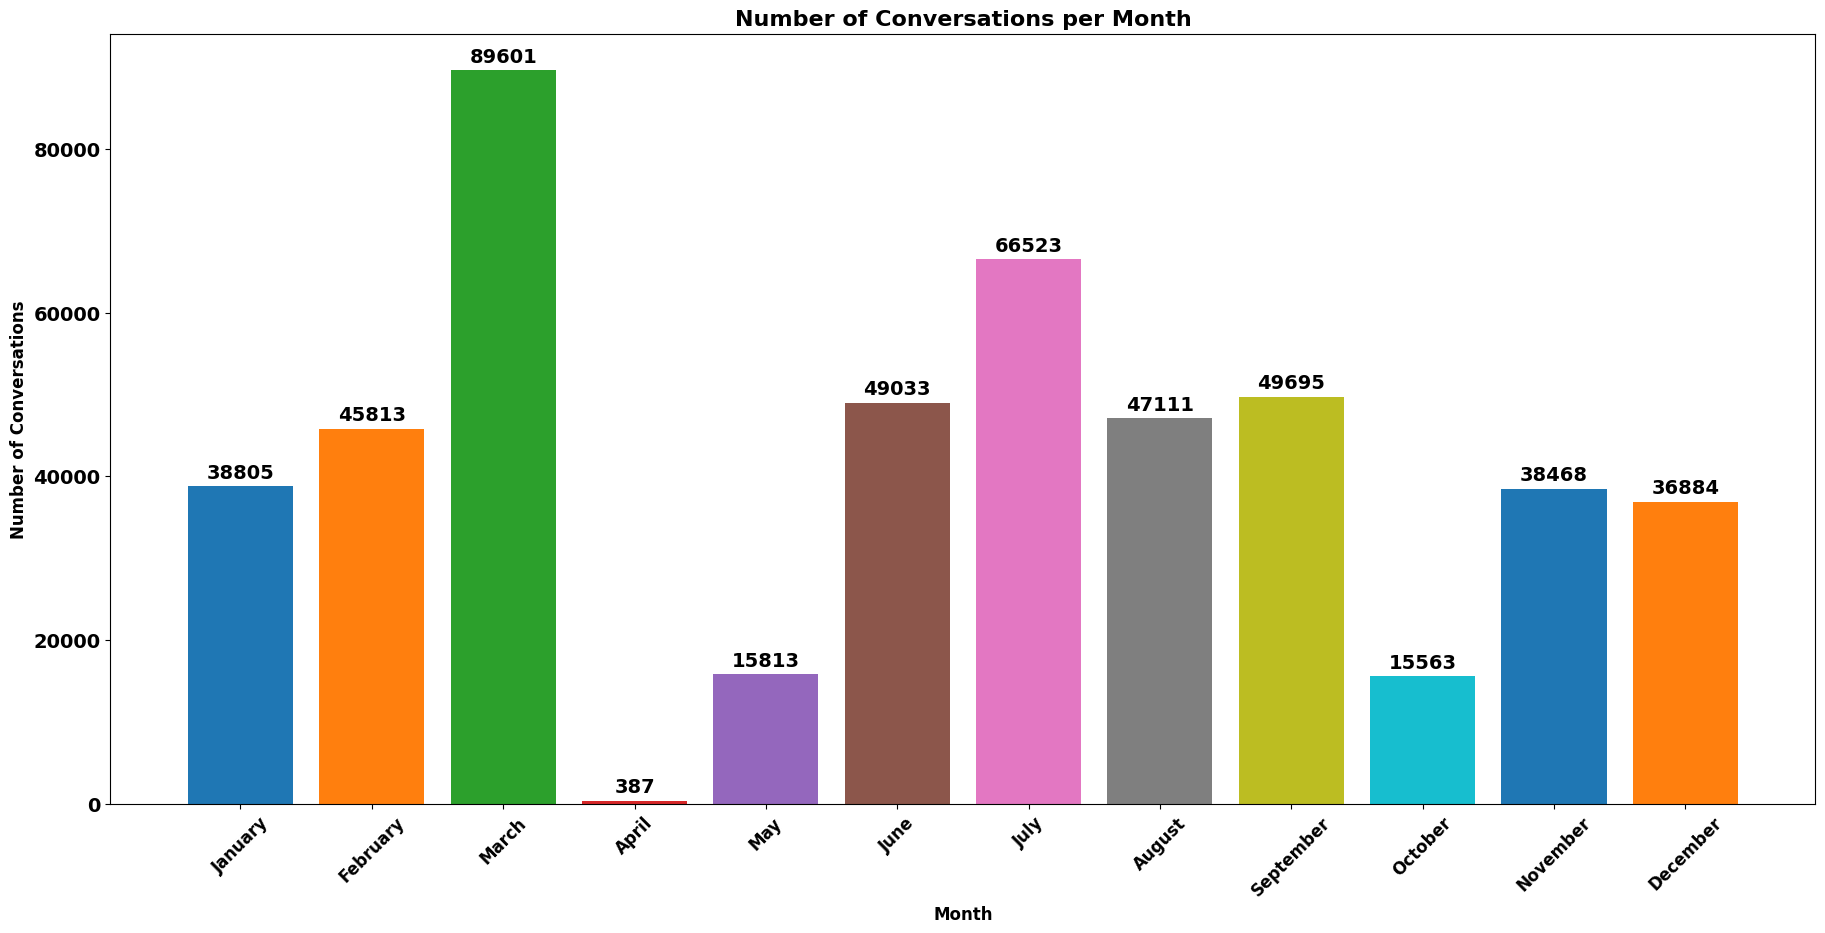

In [12]:
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the month name from the tweet creation time
first_tweet_times_month = first_tweet_times.dt.month_name()

# Group by month name and count the number of conversations
conversations_per_month = first_tweet_times_month.value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(22, 10))
bars = plt.bar(conversations_per_month.index, conversations_per_month.values, color=colors[:len(conversations_per_month)])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=14, fontweight='bold');


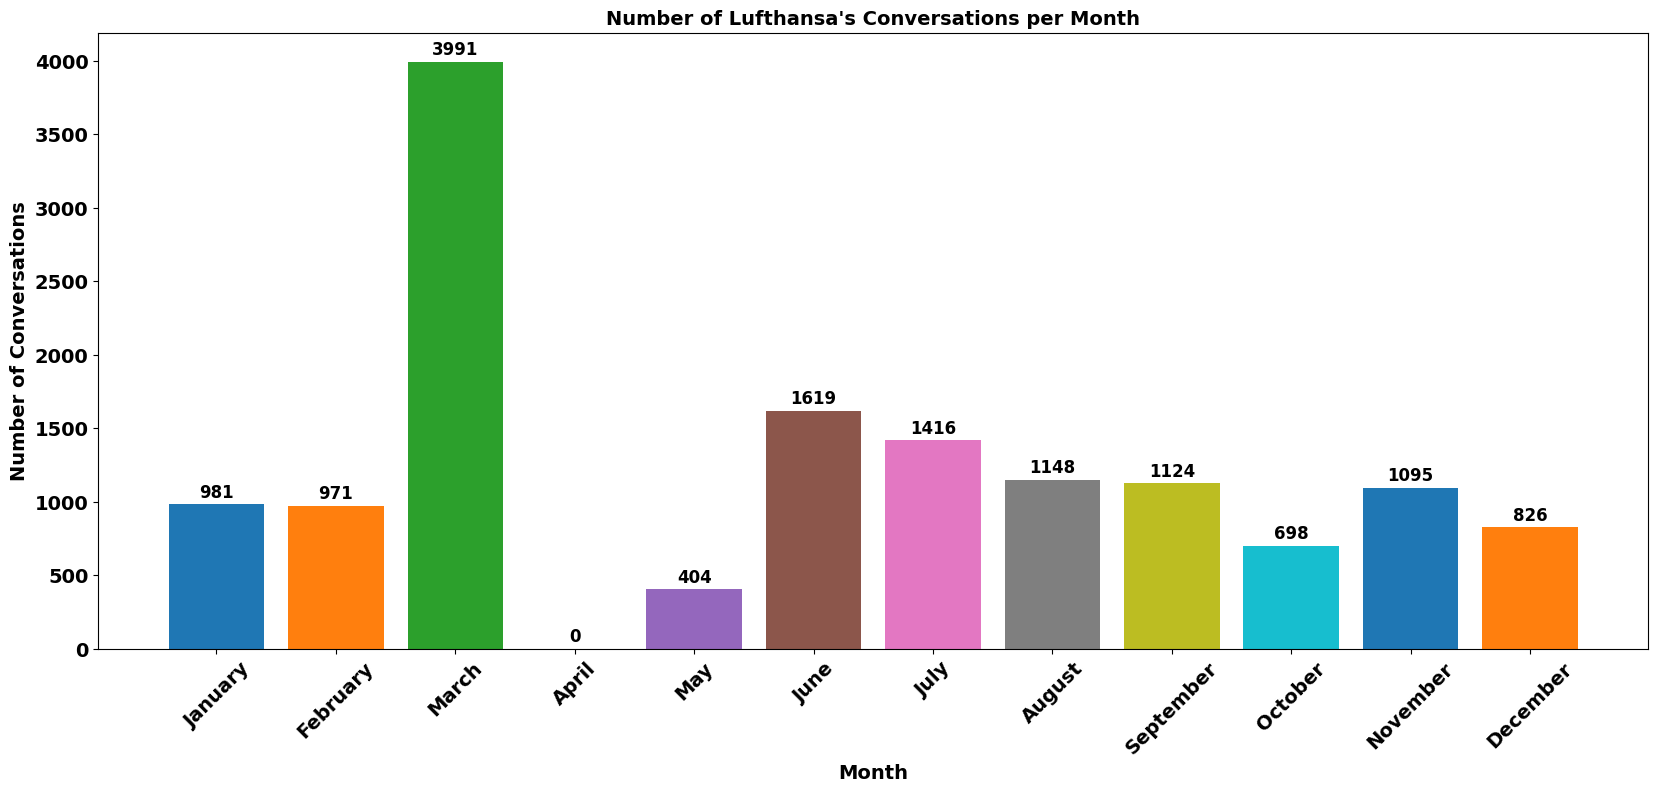

In [13]:
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Lufthansa"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the month name from the tweet creation time
first_tweet_times_month = first_tweet_times.dt.month_name()

# Group by month name and count the number of conversations
conversations_per_month = first_tweet_times_month.value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(conversations_per_month.index, conversations_per_month.values, color=colors[:len(conversations_per_month)])
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=14, fontweight='bold')
plt.title("Number of Lufthansa's Conversations per Month", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold');


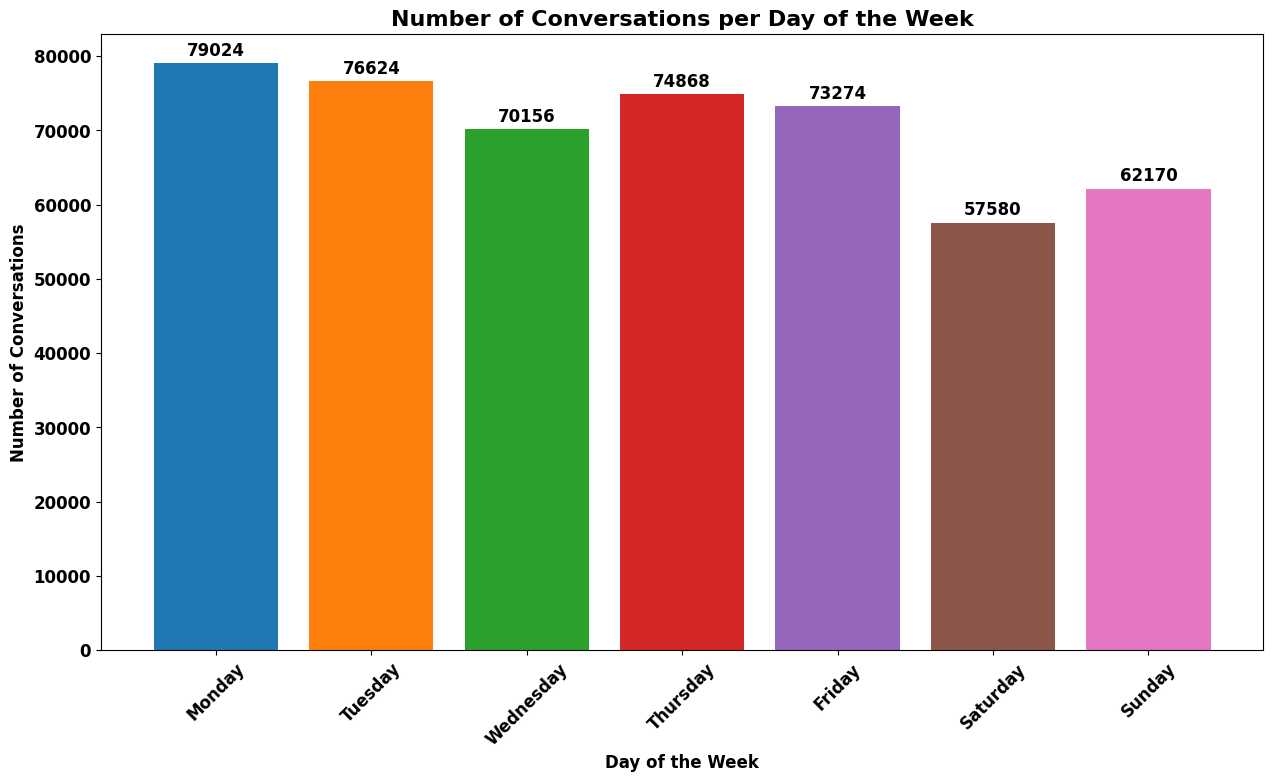

In [14]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the day name from the tweet creation time
first_tweet_times_day = first_tweet_times.dt.day_name()

# Group by day name and count the number of conversations
conversations_per_day = first_tweet_times_day.value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(conversations_per_day.index, conversations_per_day.values, color=colors[:len(conversations_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Day of the Week', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold')


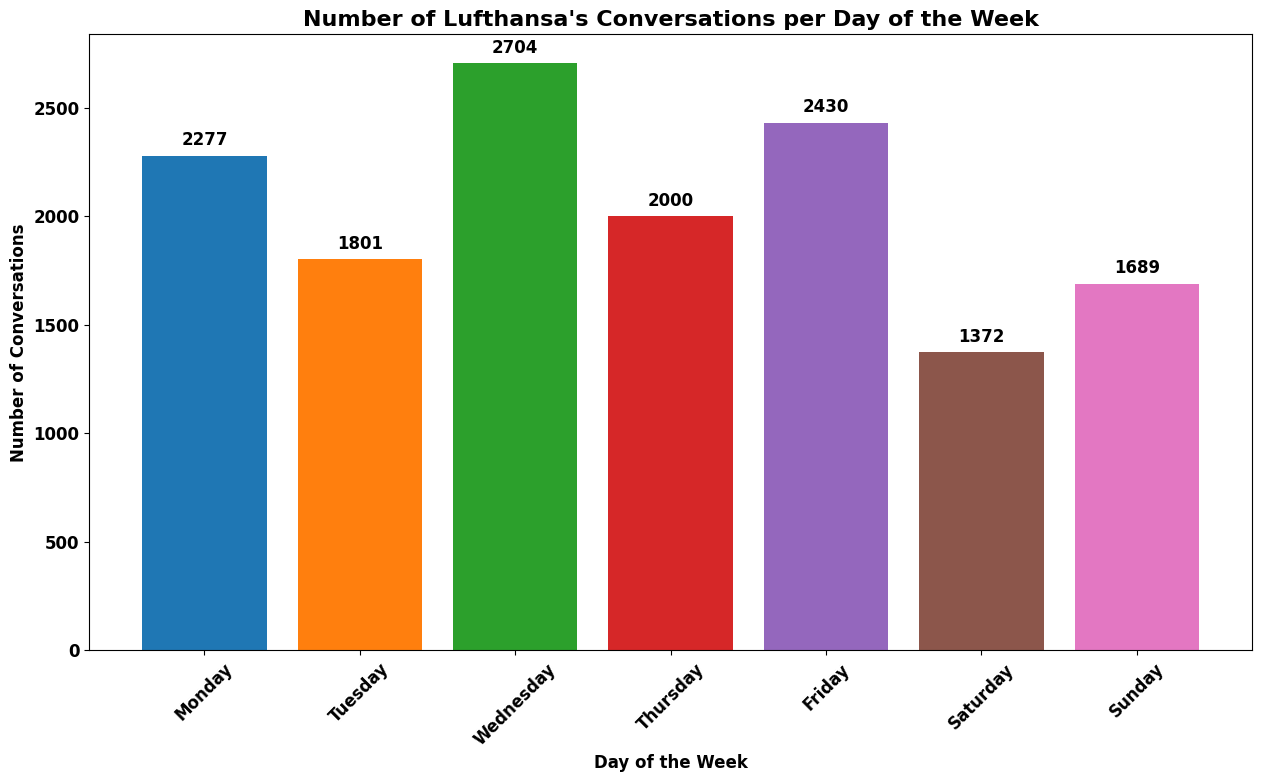

In [15]:
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Lufthansa"]].copy()

df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the day name from the tweet creation time
first_tweet_times_day = first_tweet_times.dt.day_name()

# Group by day name and count the number of conversations
conversations_per_day = first_tweet_times_day.value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], fill_value=0)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(conversations_per_day.index, conversations_per_day.values, color=colors[:len(conversations_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title("Number of Lufthansa's Conversations per Day of the Week", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold')


## Airline response time (check)

C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\1355208548.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airline_replies['airline'] = airline_replies['user_id'].map(COMPANY_ID_TO_NAME)


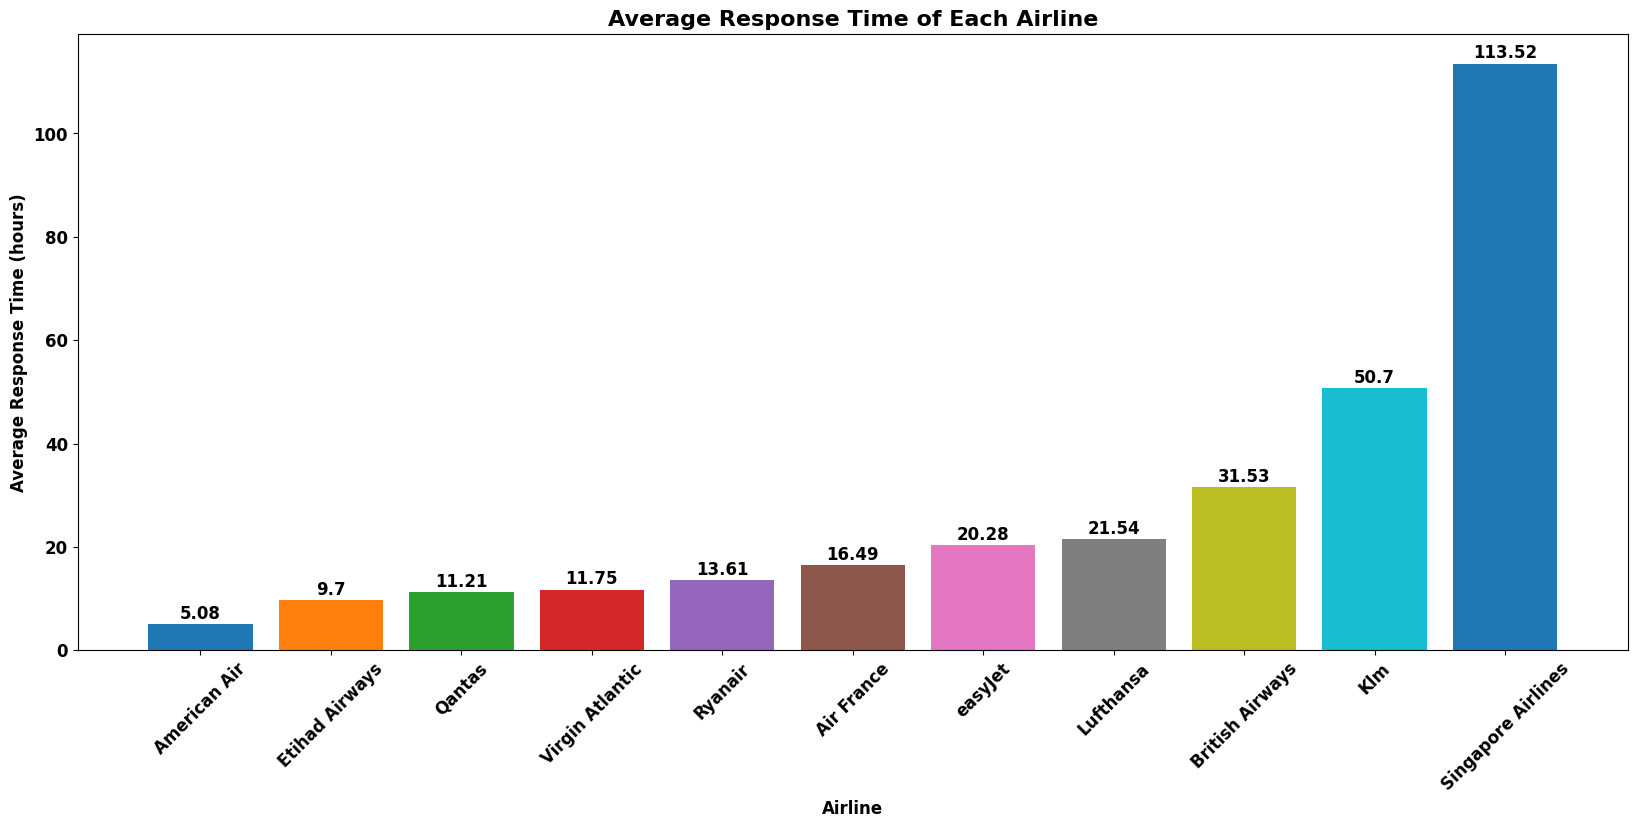

In [16]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for airline replies only
airline_replies = df_reset[df_reset['user_id'].isin(COMPANY_NAME_TO_ID.values()) & (df_reset['response_time'] > 0)]

# Simplified mapping of user IDs to airline names
airline_replies['airline'] = airline_replies['user_id'].map(COMPANY_ID_TO_NAME)

# Aggregate and compute the average response time for each airline
average_response_times = airline_replies.groupby('airline')['response_time'].mean().sort_values()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(average_response_times.index, average_response_times.values, color=colors[:len(average_response_times)])
plt.xlabel('Airline', fontsize=12, fontweight='bold')
plt.ylabel('Average Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Average Response Time of Each Airline', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', fontsize=12, fontweight='bold')


C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\983338006.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


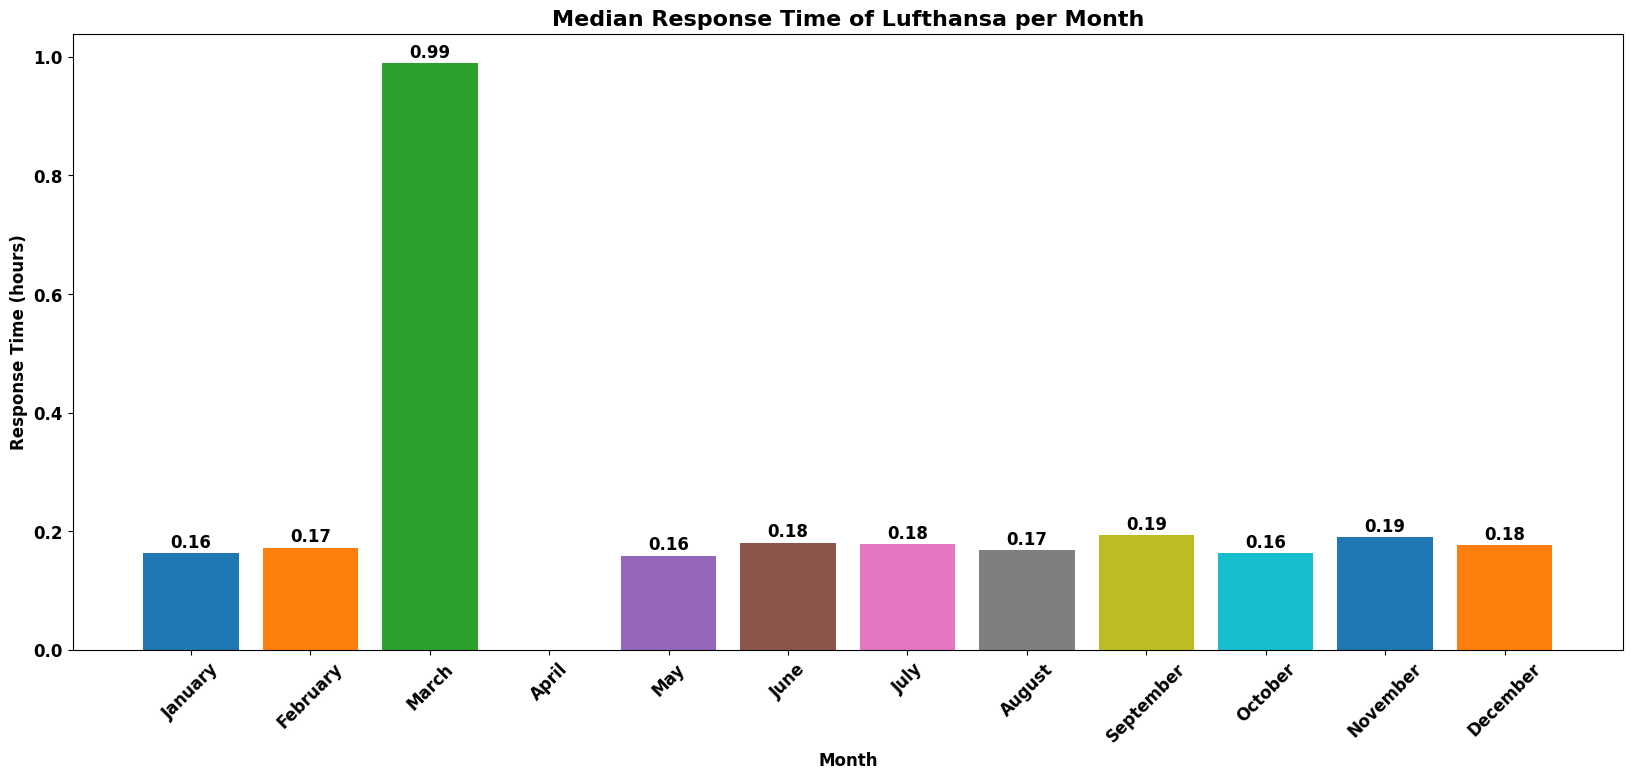

In [17]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for Lufthansa replies only
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_replies = df_reset[(df_reset['user_id'] == lufthansa_user_id) & (df_reset['response_time'] > 0)]

# Extract month from the tweet creation time
lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()

# Aggregate and compute the average response time for each month
average_response_times_per_month = lufthansa_replies.groupby('month')['response_time'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(average_response_times_per_month.index, average_response_times_per_month.values, color=colors[:len(average_response_times_per_month)])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Response Time (hours)', fontsize=12, fontweight='bold')
plt.title('Median Response Time of Lufthansa per Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')


C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\2234080528.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


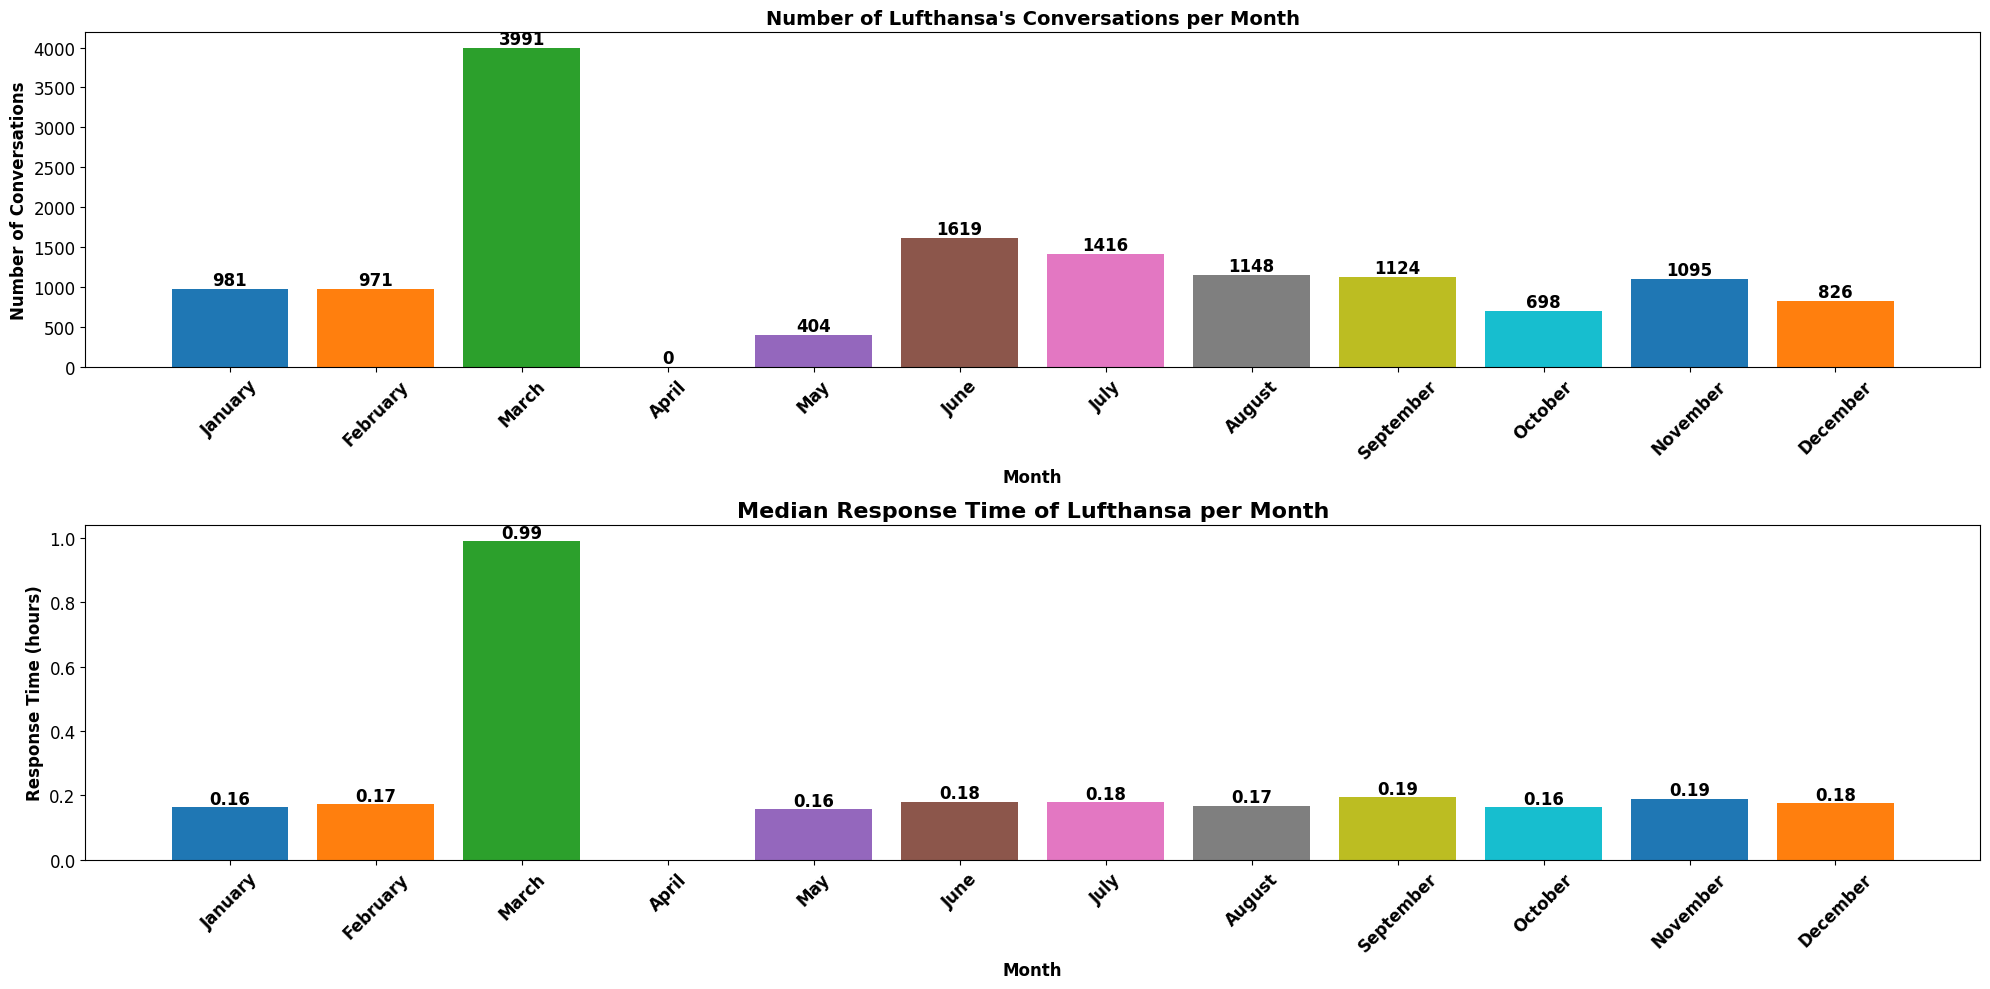

In [18]:
# Filter data for Lufthansa
df_luft = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID["Lufthansa"]].copy()
df_luft['tweet_creation_time'] = pd.to_datetime(df_luft['tweet_creation_time'])

# Extract the first tweet's creation time for each conversation
first_tweet_times = df_luft.groupby('conversation_id')['tweet_creation_time'].min()

# Extract the month name from the tweet creation time
first_tweet_times_month = first_tweet_times.dt.month_name()

# Group by month name and count the number of conversations
conversations_per_month = first_tweet_times_month.value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
], fill_value=0)

# Ensure tweet_creation_time is in datetime format for the entire dataset
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Precompute the first tweet time for each conversation
first_tweet_times = df_reset.groupby('conversation_id')['tweet_creation_time'].transform('min')

# Compute the response times for all tweets
df_reset['response_time'] = (df_reset['tweet_creation_time'] - first_tweet_times).dt.total_seconds() / 3600  # response time in hours

# Filter the DataFrame for Lufthansa replies only
lufthansa_replies = df_reset[(df_reset['user_id'] == COMPANY_NAME_TO_ID['Lufthansa']) & (df_reset['response_time'] > 0)]

# Extract month from the tweet creation time
lufthansa_replies['month'] = lufthansa_replies['tweet_creation_time'].dt.month_name()

# Aggregate and compute the average response time for each month
average_response_times_per_month = lufthansa_replies.groupby('month')['response_time'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the graphs together in two rows
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# First plot: Number of Lufthansa's Conversations per Month
bars = axs[0].bar(conversations_per_month.index, conversations_per_month.values, color=colors[:len(conversations_per_month)])
axs[0].set_xlabel('Month', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Number of Conversations', fontsize=12, fontweight='bold')
axs[0].set_title("Number of Lufthansa's Conversations per Month", fontsize=14, fontweight='bold')
axs[0].set_xticks(range(len(conversations_per_month)))
axs[0].set_xticklabels(conversations_per_month.index, rotation=45, fontsize=12, fontweight='bold')
axs[0].tick_params(axis='y', labelsize=12)

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', fontsize=12, fontweight='bold')

# Second plot: Median Response Time of Lufthansa per Month
bars = axs[1].bar(average_response_times_per_month.index, average_response_times_per_month.values, color=colors[:len(average_response_times_per_month)])
axs[1].set_xlabel('Month', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Response Time (hours)', fontsize=12, fontweight='bold')
axs[1].set_title('Median Response Time of Lufthansa per Month', fontsize=16, fontweight='bold')
axs[1].set_xticks(range(len(average_response_times_per_month)))
axs[1].set_xticklabels(average_response_times_per_month.index, rotation=45, fontsize=12, fontweight='bold')
axs[1].tick_params(axis='y', labelsize=12)

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()

# Sentiment analysis

C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\3839167196.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axs[0, 0], x='airline', y='sentiment_score', data=airline_tweets, palette=palette)
c:\My programs\Python 3.12\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\My programs\Python 3.12\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\My programs\Python 3.12\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping wit

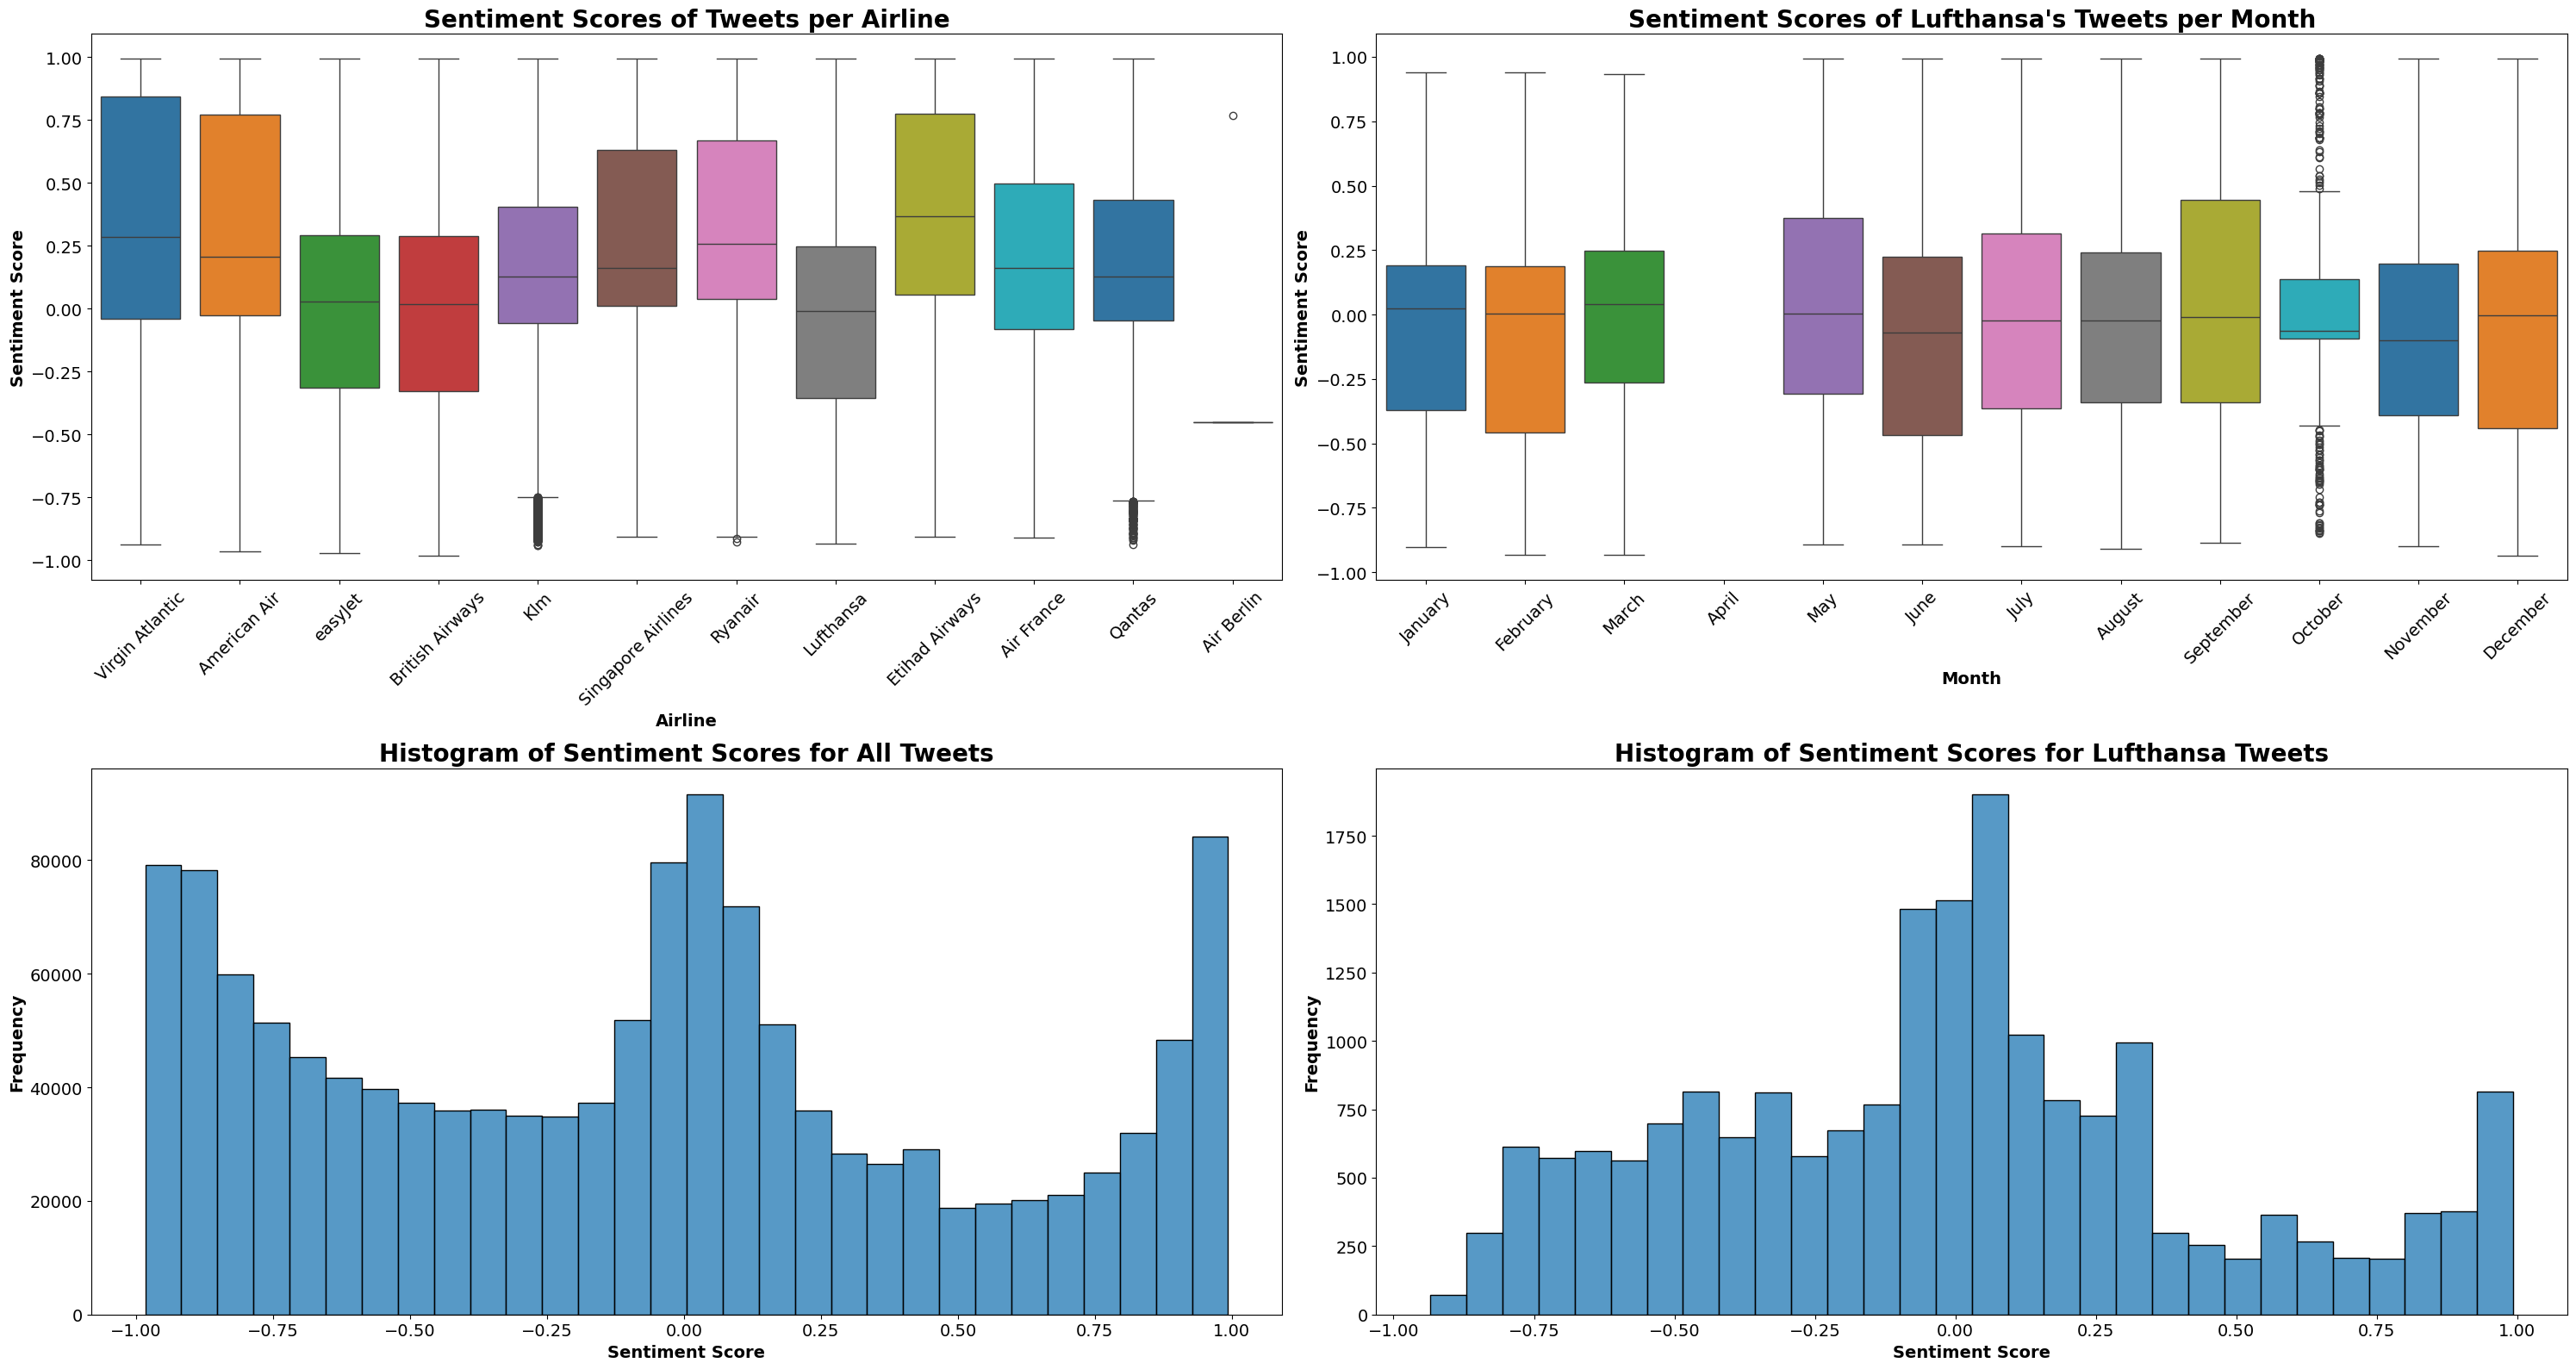

In [19]:
df_reset = df_all.reset_index()

# Convert sentiment scores to numeric values
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Map user IDs to airline names
df_reset['airline'] = df_reset['user_id'].map(COMPANY_ID_TO_NAME)

# Filter the DataFrame to include only the tweets from the specified airlines
airline_tweets = df_reset[df_reset['airline'].notnull()]

# Define a color palette using mcolors
colors = list(mcolors.TABLEAU_COLORS.values())
palette = {airline: colors[i % len(colors)] for i, airline in enumerate(airline_tweets['airline'].unique())}

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(30, 16))

# Plot the box plot for sentiment scores grouped by airline
sns.boxplot(ax=axs[0, 0], x='airline', y='sentiment_score', data=airline_tweets, palette=palette)
axs[0, 0].set_xlabel('Airline', fontsize=14, fontweight='bold')
axs[0, 0].set_ylabel('Sentiment Score', fontsize=14, fontweight='bold')
axs[0, 0].set_title('Sentiment Scores of Tweets per Airline', fontsize=20, fontweight='bold')
axs[0, 0].tick_params(axis='x', rotation=45, labelsize=14)
axs[0, 0].tick_params(axis='y', labelsize=14)

# Filter the DataFrame to include only rows for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_df = df_reset[df_reset['user_id'] == lufthansa_user_id]

# Extract the month name from the tweet creation time
lufthansa_df['month'] = lufthansa_df['tweet_creation_time'].dt.strftime('%B')

# Order the months correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Plot the boxplot of sentiment scores per month for Lufthansa
sns.boxplot(ax=axs[0, 1], x='month', y='sentiment_score', data=lufthansa_df, order=month_order, palette=colors[:12])
axs[0, 1].set_xlabel('Month', fontsize=14, fontweight='bold')
axs[0, 1].set_ylabel('Sentiment Score', fontsize=14, fontweight='bold')
axs[0, 1].set_title("Sentiment Scores of Lufthansa's Tweets per Month", fontsize=20, fontweight='bold')
axs[0, 1].tick_params(axis='x', rotation=45, labelsize=14)
axs[0, 1].tick_params(axis='y', labelsize=14)

# Plot the histogram for all tweets' sentiment scores
sns.histplot(ax=axs[1, 0], data=df_reset['sentiment_score'].dropna(), bins=30, color=colors[0], kde=False)
axs[1, 0].set_xlabel('Sentiment Score', fontsize=14, fontweight='bold')
axs[1, 0].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axs[1, 0].set_title('Histogram of Sentiment Scores for All Tweets', fontsize=20, fontweight='bold')
axs[1, 0].tick_params(axis='x', labelsize=14)
axs[1, 0].tick_params(axis='y', labelsize=14)

# Plot the histogram for Lufthansa's tweets
sns.histplot(ax=axs[1, 1], data=lufthansa_df['sentiment_score'].dropna(), bins=30, color=colors[0], kde=False)
axs[1, 1].set_xlabel('Sentiment Score', fontsize=14, fontweight='bold')
axs[1, 1].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axs[1, 1].set_title('Histogram of Sentiment Scores for Lufthansa Tweets', fontsize=20, fontweight='bold')
axs[1, 1].tick_params(axis='x', labelsize=14)
axs[1, 1].tick_params(axis='y', labelsize=14)

plt.tight_layout()

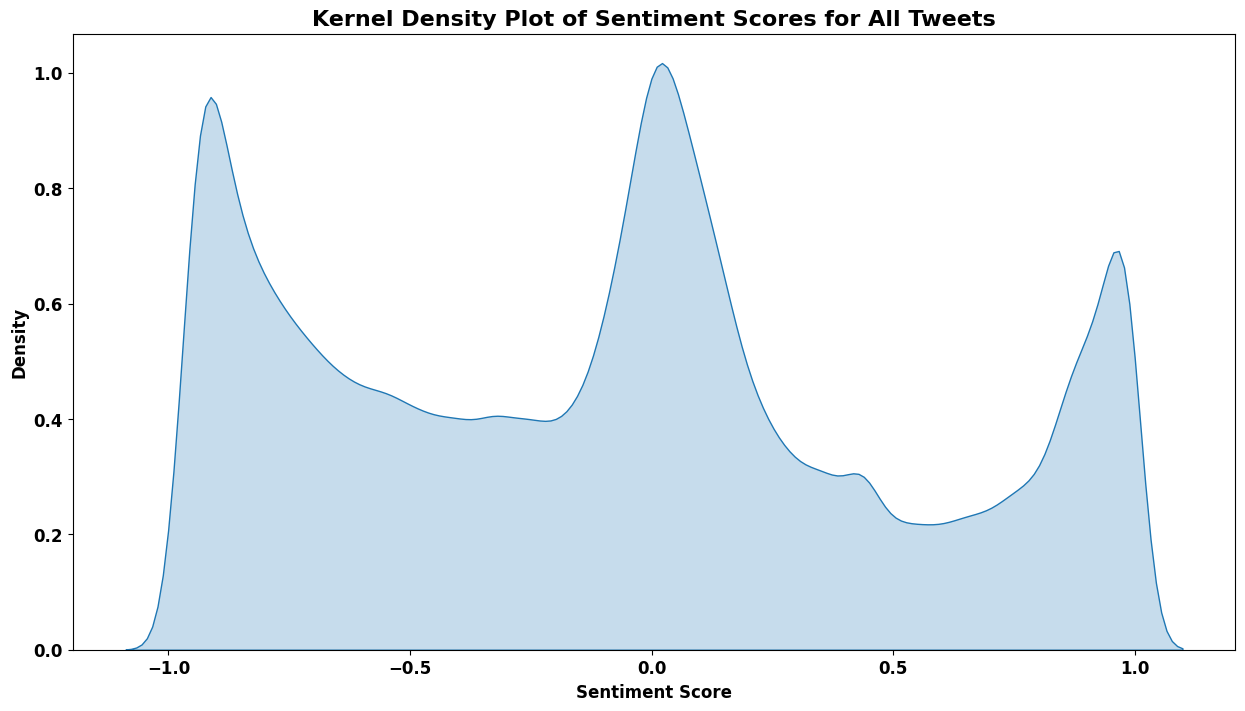

In [20]:
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Define a colormap
cmap = mcolors.TABLEAU_COLORS

# Plot the KDE plot
plt.figure(figsize=(15, 8))
sns.kdeplot(df_reset['sentiment_score'].dropna(), fill=True, color=list(cmap.values())[0])

plt.xlabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.title('Kernel Density Plot of Sentiment Scores for All Tweets', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold');

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000.]),
 [Text(0, 0.0, '0'),
  Text(0, 20000.0, '20000'),
  Text(0, 40000.0, '40000'),
  Text(0, 60000.0, '60000'),
  Text(0, 80000.0, '80000'),
  Text(0, 100000.0, '100000')])

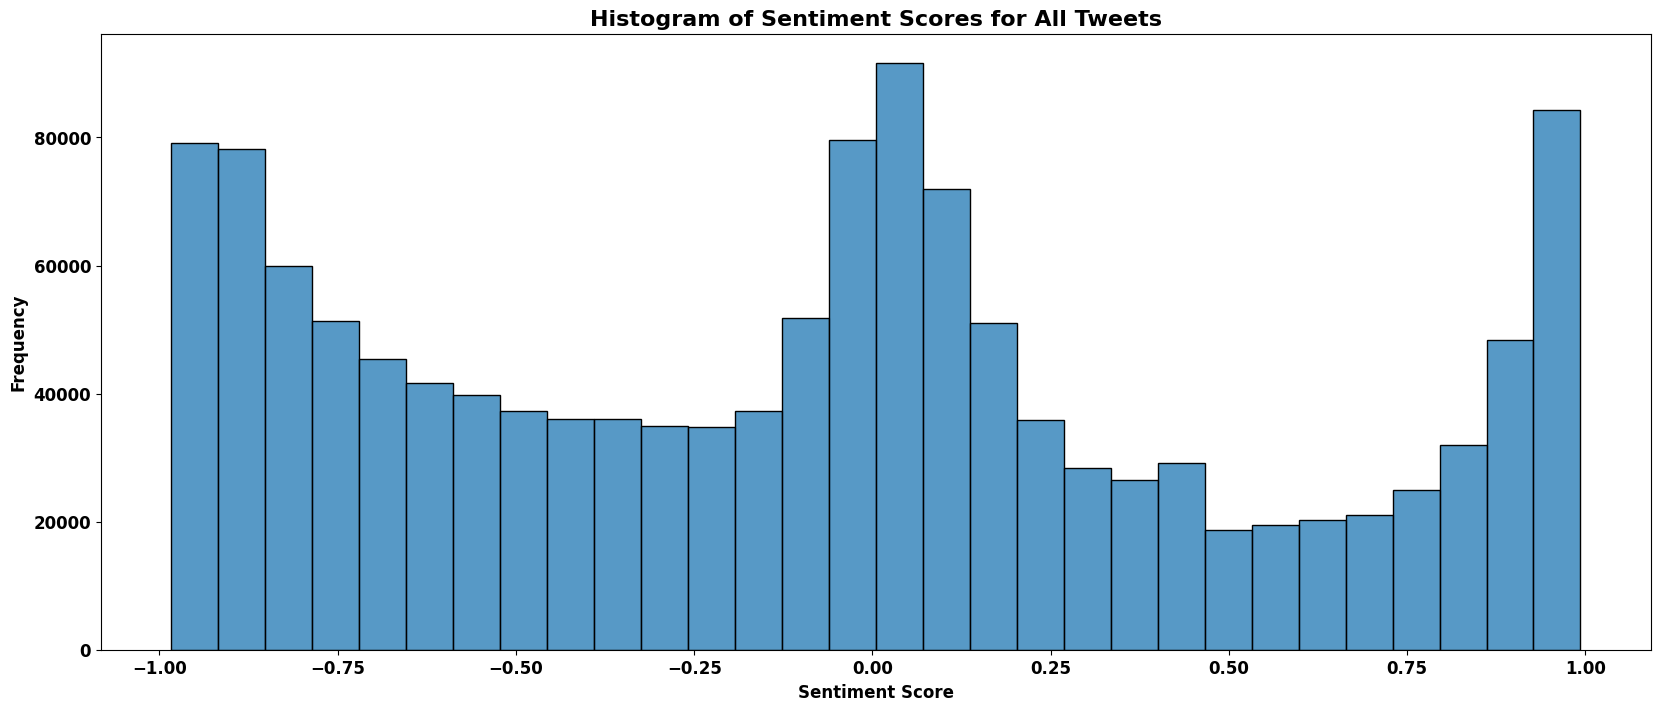

In [21]:
# Assuming df_reset is already defined
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Define a colormap
cmap = mcolors.TABLEAU_COLORS

# Plot the histogram for all tweets
plt.figure(figsize=(20, 8))
sns.histplot(df_reset['sentiment_score'].dropna(), bins=30, color=list(cmap.values())[0], kde=False)

plt.xlabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Histogram of Sentiment Scores for All Tweets', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.4000000000000001, '1.4')])

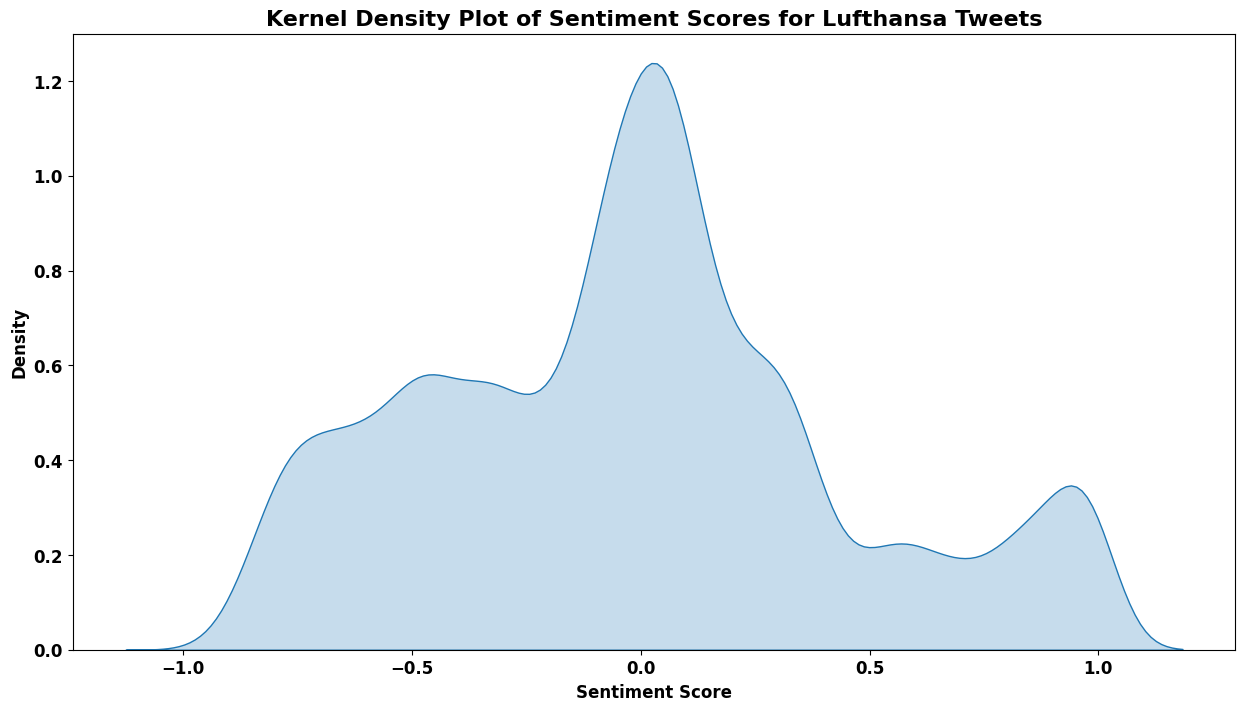

In [22]:
# Assuming df_reset is already defined
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Filter the DataFrame to include only rows for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_df = df_reset[df_reset['user_id'] == lufthansa_user_id]

# Define a colormap
cmap = mcolors.TABLEAU_COLORS

# Plot the KDE plot for Lufthansa's tweets
plt.figure(figsize=(15, 8))
sns.kdeplot(lufthansa_df['sentiment_score'].dropna(), fill=True, color=list(cmap.values())[0])

plt.xlabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.title('Kernel Density Plot of Sentiment Scores for Lufthansa Tweets', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.]),
 [Text(0, 0.0, '0'),
  Text(0, 250.0, '250'),
  Text(0, 500.0, '500'),
  Text(0, 750.0, '750'),
  Text(0, 1000.0, '1000'),
  Text(0, 1250.0, '1250'),
  Text(0, 1500.0, '1500'),
  Text(0, 1750.0, '1750'),
  Text(0, 2000.0, '2000')])

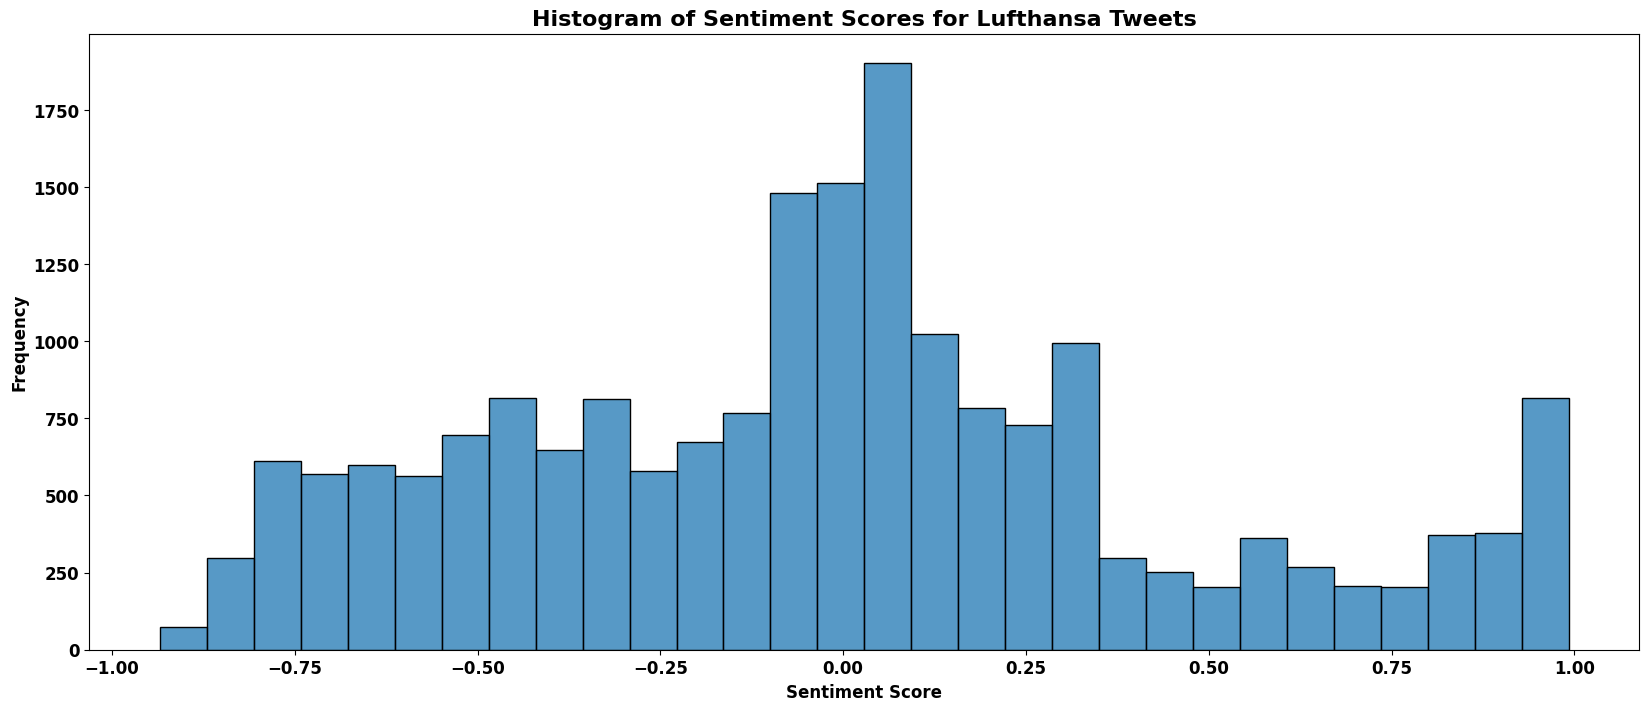

In [23]:
# Assuming df_reset is already defined
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Filter the DataFrame to include only rows for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_df = df_reset[df_reset['user_id'] == lufthansa_user_id]

# Define a colormap
cmap = mcolors.TABLEAU_COLORS

# Plot the histogram for Lufthansa's tweets
plt.figure(figsize=(20, 8))
sns.histplot(lufthansa_df['sentiment_score'].dropna(), bins=30, color=list(cmap.values())[0], kde=False)

plt.xlabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Histogram of Sentiment Scores for Lufthansa Tweets', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\2389189942.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='airline', y='sentiment_score', data=airline_tweets, palette=palette)
c:\My programs\Python 3.12\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\My programs\Python 3.12\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\My programs\Python 3.12\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 l

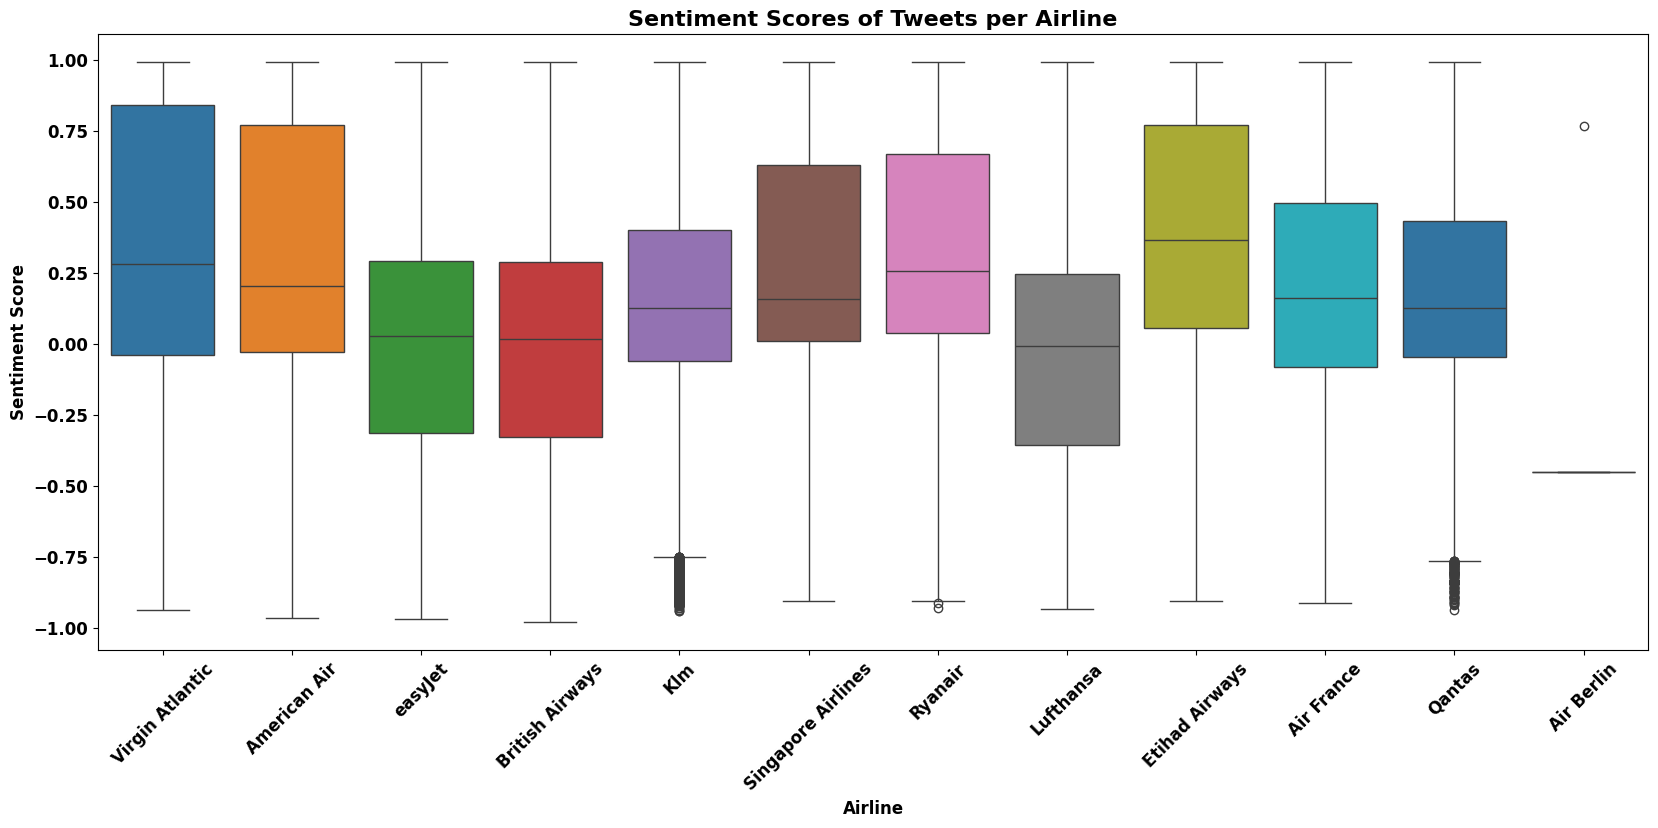

In [24]:
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Map user IDs to airline names
df_reset['airline'] = df_reset['user_id'].map(COMPANY_ID_TO_NAME)
# Filter the DataFrame to include only the tweets from the specified airlines
airline_tweets = df_reset[df_reset['airline'].notnull()]

# Define a color palette using mcolors
colors = list(mcolors.TABLEAU_COLORS.values())
palette = {airline: colors[i % len(colors)] for i, airline in enumerate(airline_tweets['airline'].unique())}

# Plot the box plot for sentiment scores grouped by airline
plt.figure(figsize=(20, 8))
sns.boxplot(x='airline', y='sentiment_score', data=airline_tweets, palette=palette)
plt.xlabel('Airline', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Sentiment Scores of Tweets per Airline', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold');


C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\381418166.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_df['month'] = lufthansa_df['tweet_creation_time'].dt.strftime('%B')
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\381418166.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='sentiment_score', data=lufthansa_df, order=month_order, palette=colors[:12])
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\381418166.py:17: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='m

(array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
         1.  ,  1.25]),
 [Text(0, -1.25, '−1.25'),
  Text(0, -1.0, '−1.00'),
  Text(0, -0.75, '−0.75'),
  Text(0, -0.5, '−0.50'),
  Text(0, -0.25, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25')])

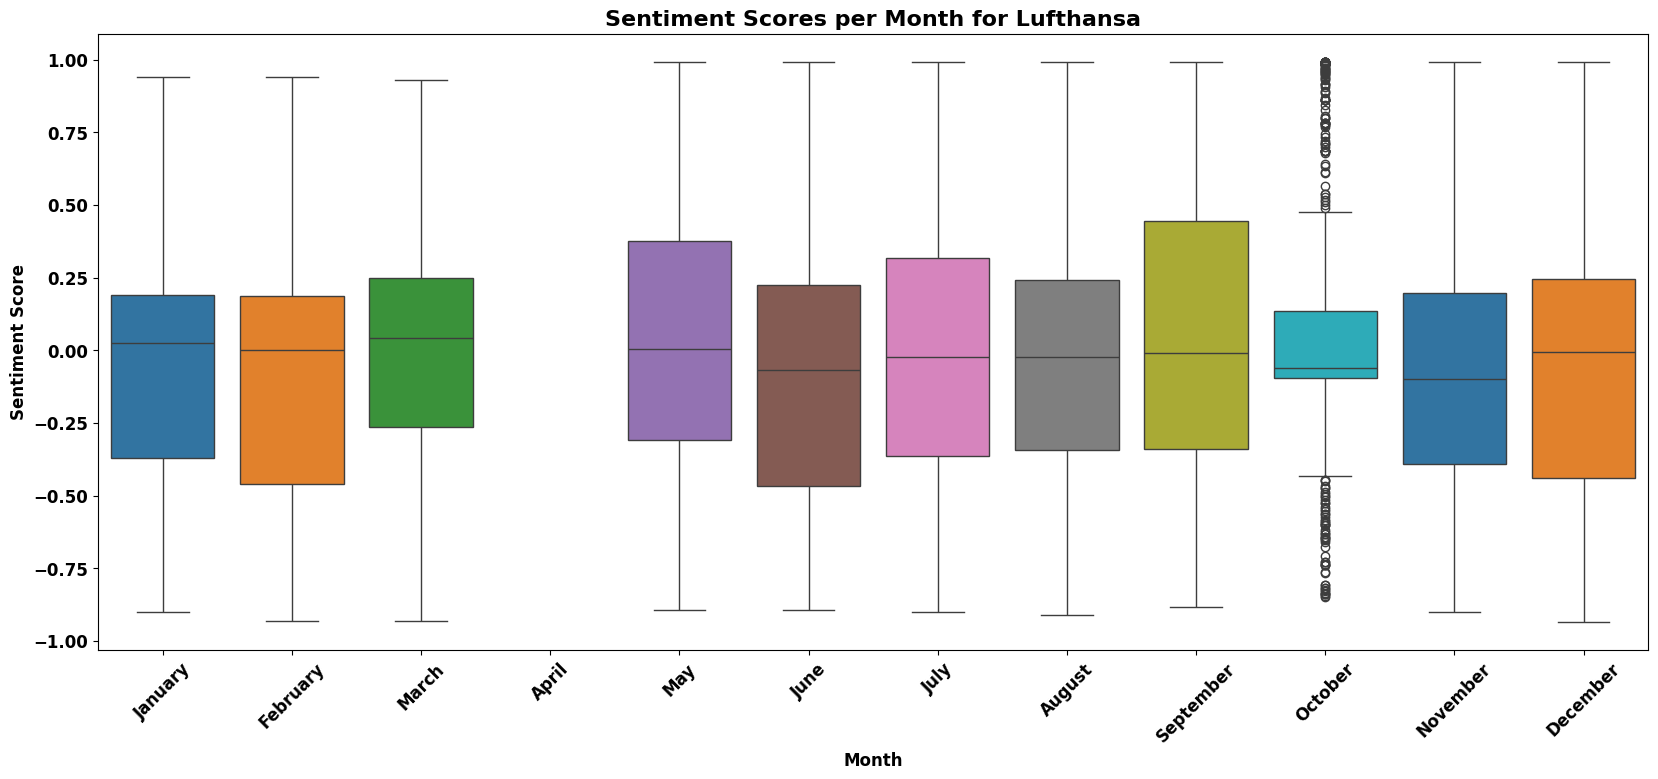

In [25]:
# Filter the DataFrame to include only rows for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_df = df_reset[df_reset['user_id'] == lufthansa_user_id]

# Extract the month name from the tweet creation time
lufthansa_df['month'] = lufthansa_df['tweet_creation_time'].dt.strftime('%B')

# Order the months correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Create a boxplot of sentiment scores per month
plt.figure(figsize=(20, 8))
sns.boxplot(x='month', y='sentiment_score', data=lufthansa_df, order=month_order, palette=colors[:12])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Sentiment Scores per Month for Lufthansa', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\445937331.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_df['day_of_week'] = lufthansa_df['tweet_creation_time'].dt.day_name()
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\445937331.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_of_week', y='sentiment_score', data=lufthansa_df, order=day_order, palette=colors[:7])
c:\My programs\Python 3.12\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pa

(array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
         1.  ,  1.25]),
 [Text(0, -1.25, '−1.25'),
  Text(0, -1.0, '−1.00'),
  Text(0, -0.75, '−0.75'),
  Text(0, -0.5, '−0.50'),
  Text(0, -0.25, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25')])

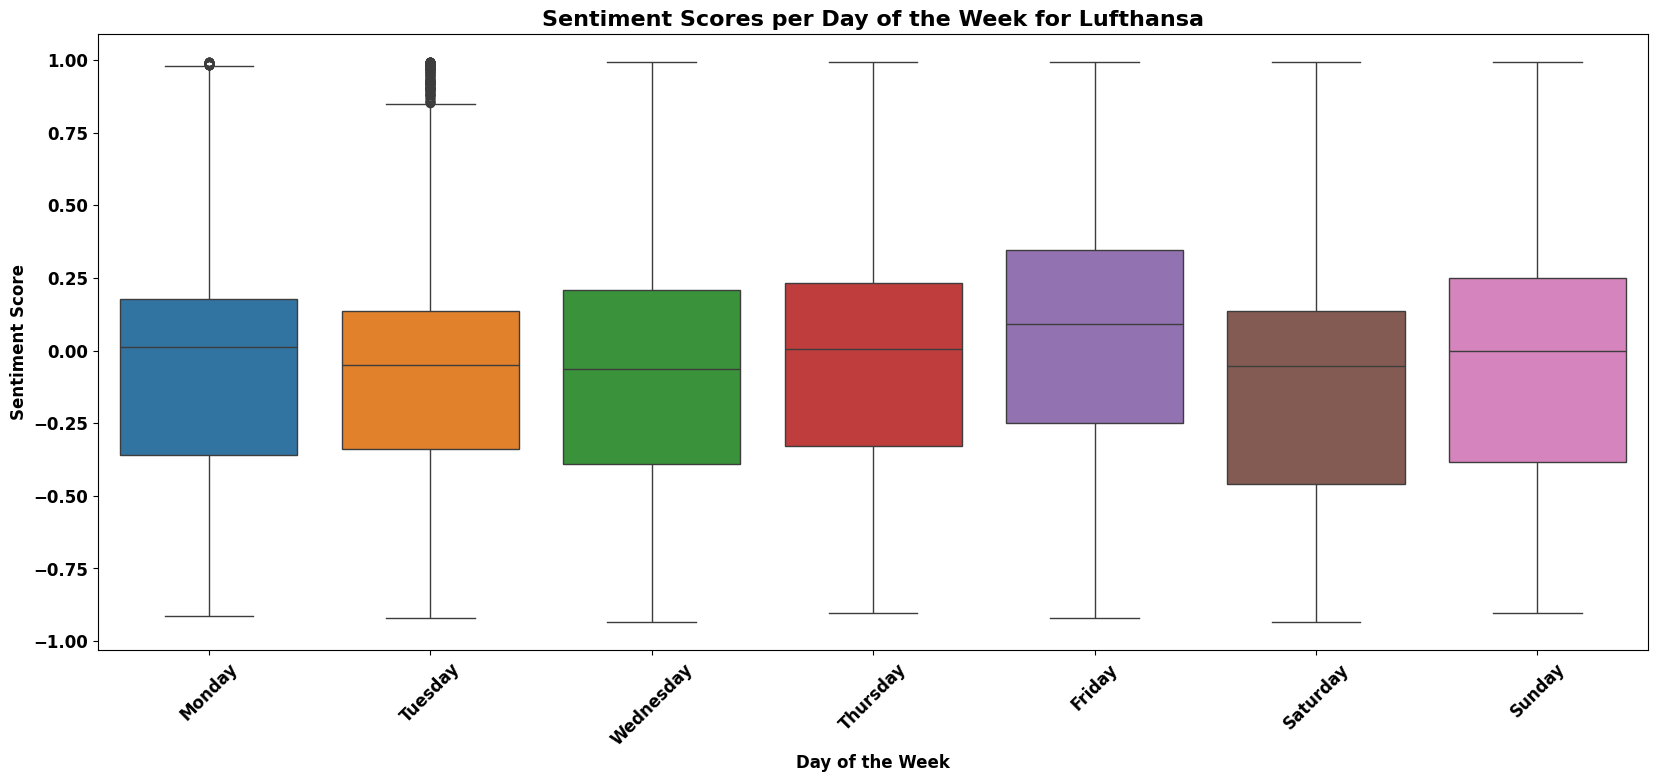

In [26]:

# Filter the DataFrame to include only rows for Lufthansa
lufthansa_user_id = COMPANY_NAME_TO_ID['Lufthansa']
lufthansa_df = df_reset[df_reset['user_id'] == lufthansa_user_id]

# Extract the day of the week from the tweet creation time
lufthansa_df['day_of_week'] = lufthansa_df['tweet_creation_time'].dt.day_name()

# Order the days of the week correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Create a boxplot of sentiment scores per day of the week
plt.figure(figsize=(20, 8))
sns.boxplot(x='day_of_week', y='sentiment_score', data=lufthansa_df, order=day_order, palette=colors[:7])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Sentiment Scores per Day of the Week for Lufthansa', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\519230912.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_tweets['month'] = customer_tweets['tweet_creation_time'].dt.month_name()


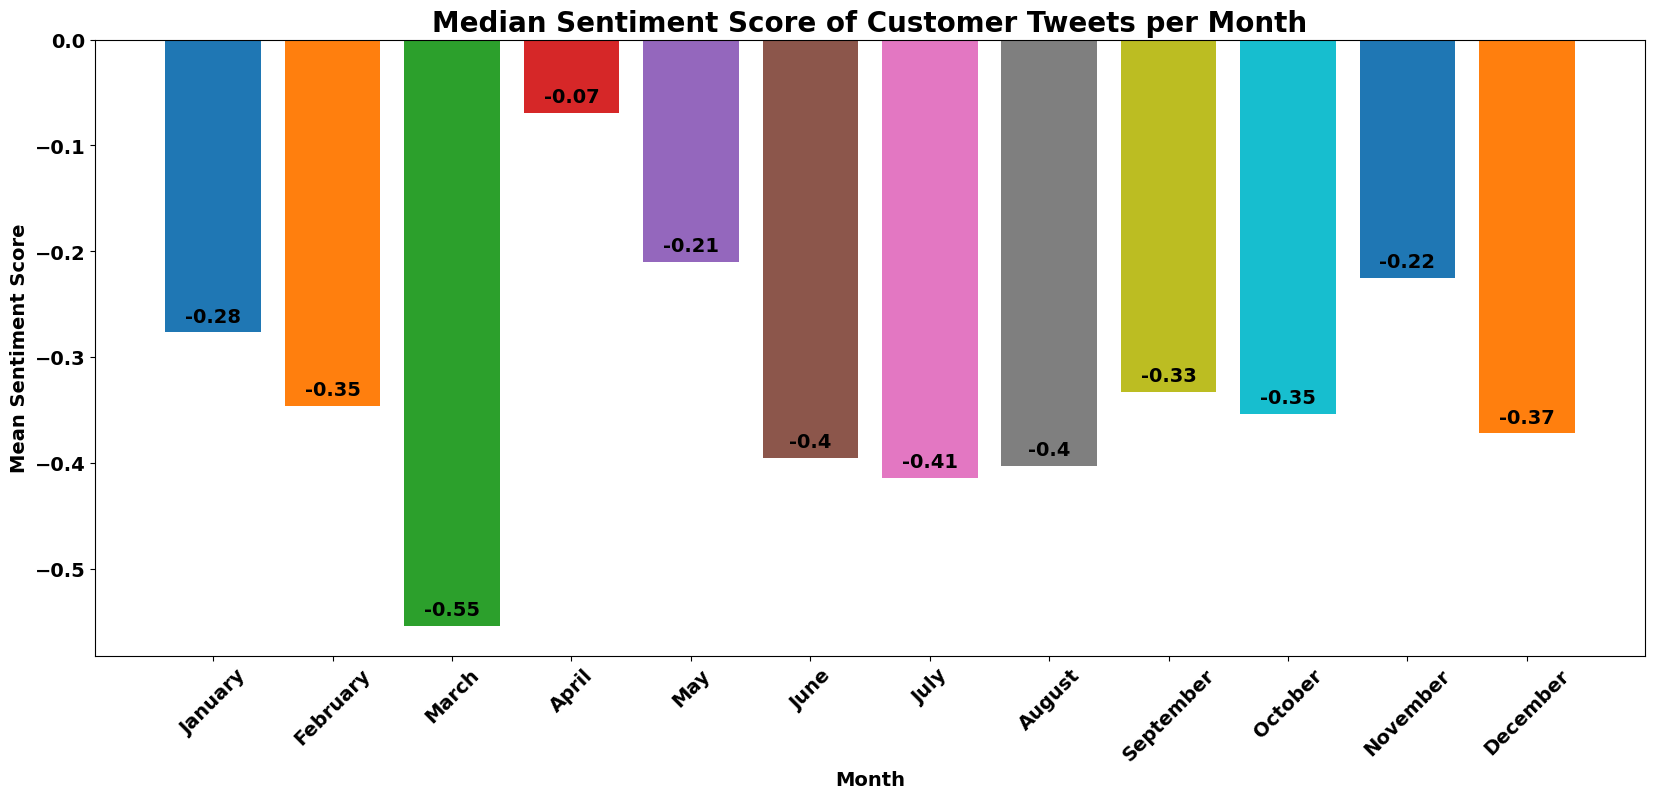

In [27]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Ensure sentiment_score is in numeric format
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Filter out the airline tweets to get only customer tweets
customer_tweets = df_reset[~df_reset['user_id'].isin(COMPANY_NAME_TO_ID.values())]

# Extract the month from the tweet creation time
customer_tweets['month'] = customer_tweets['tweet_creation_time'].dt.month_name()

# Group by month and calculate the mean sentiment score
mean_sentiment_per_month = customer_tweets.groupby('month')['sentiment_score'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(mean_sentiment_per_month.index, mean_sentiment_per_month.values, color=colors[:len(mean_sentiment_per_month)])
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Mean Sentiment Score', fontsize=14, fontweight='bold')
plt.title('Median Sentiment Score of Customer Tweets per Month', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=14, fontweight='bold')


C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\1429209996.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_customer_tweets['month'] = lufthansa_customer_tweets['tweet_creation_time'].dt.month_name()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


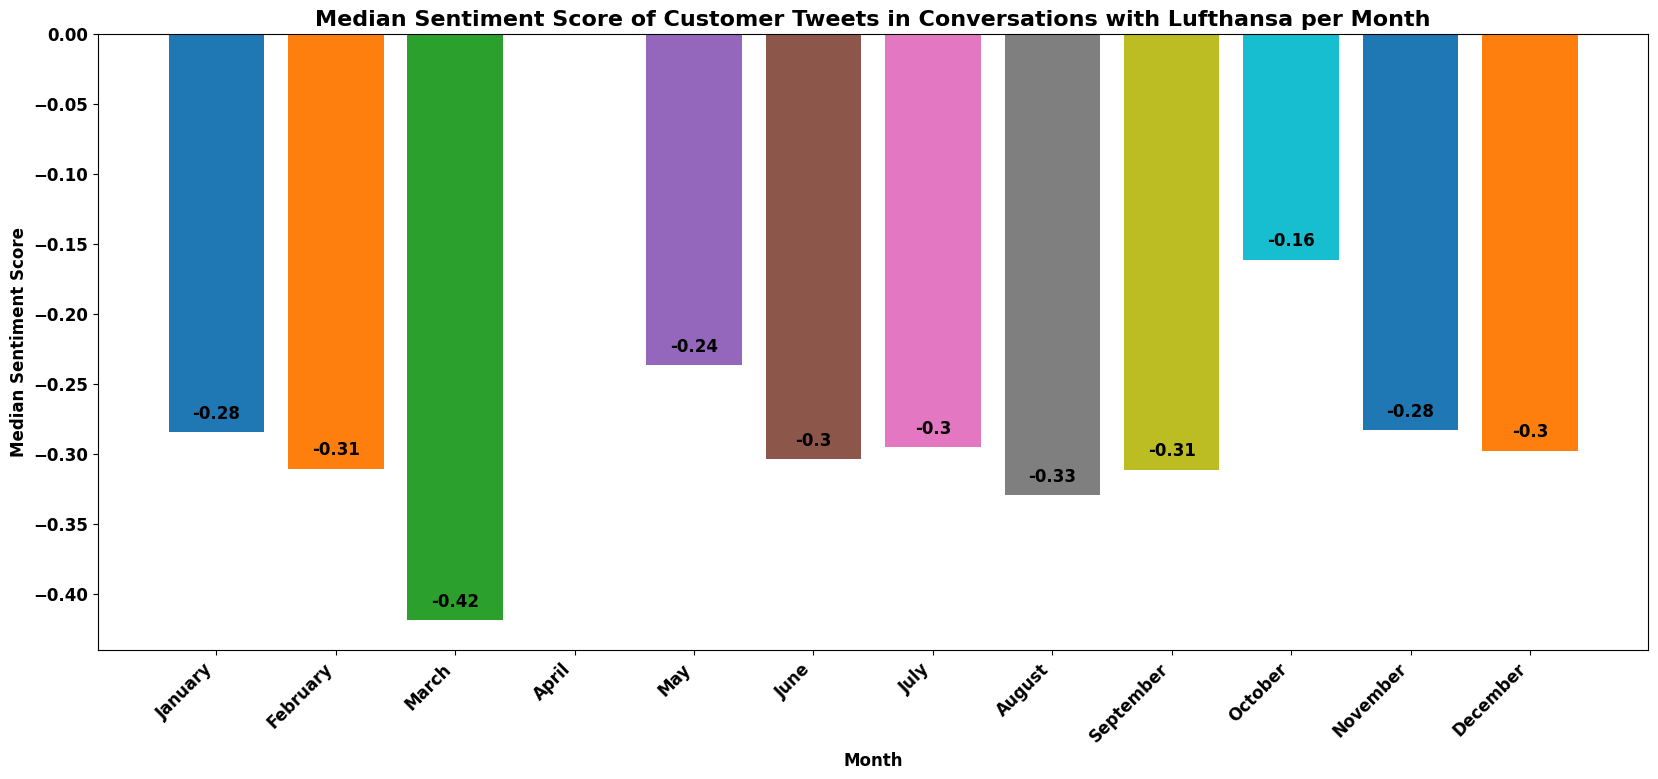

In [28]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Ensure sentiment_score is in numeric format
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Filter conversations involving Lufthansa
lufthansa_conversations = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID['Lufthansa']]['conversation_id'].unique()

# Filter customer tweets involved in Lufthansa conversations
lufthansa_customer_tweets = df_reset[df_reset['conversation_id'].isin(lufthansa_conversations) & ~df_reset['user_id'].isin(COMPANY_NAME_TO_ID.values())]

# Extract the month from the tweet creation time
lufthansa_customer_tweets['month'] = lufthansa_customer_tweets['tweet_creation_time'].dt.month_name()

# Group by month and calculate the median sentiment score
median_sentiment_per_month = lufthansa_customer_tweets.groupby('month')['sentiment_score'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(median_sentiment_per_month.index, median_sentiment_per_month.values, color=colors[:len(median_sentiment_per_month)])
plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Median Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Median Sentiment Score of Customer Tweets in Conversations with Lufthansa per Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')


C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\1908838546.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_customer_tweets['sentiment_change'] = lufthansa_customer_tweets.groupby('conversation_id')['sentiment_score'].diff()
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\1908838546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lufthansa_customer_tweets['month'] = lufthansa_customer_tweets['tweet_creation_time'].dt.month_name()
posx and posy should be finite values
posx and posy shoul

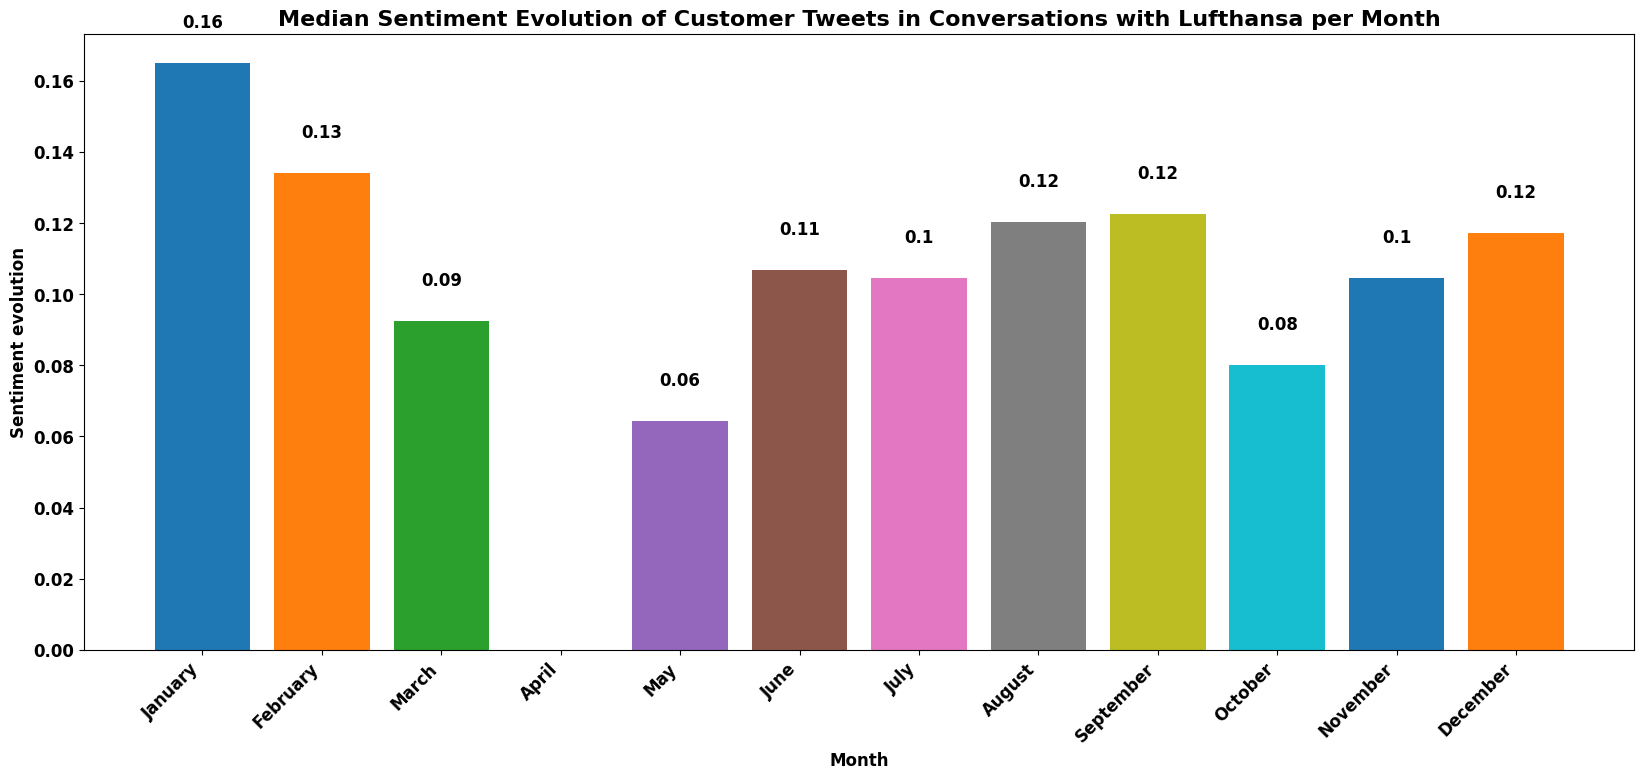

In [29]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Ensure sentiment_score is in numeric format
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Filter conversations involving Lufthansa
lufthansa_conversations = df_reset[df_reset['user_id'] == COMPANY_NAME_TO_ID['Lufthansa']]['conversation_id'].unique()

# Filter customer tweets involved in Lufthansa conversations
lufthansa_customer_tweets = df_reset[df_reset['conversation_id'].isin(lufthansa_conversations) & ~df_reset['user_id'].isin(COMPANY_NAME_TO_ID.values())]

# Calculate the change in sentiment for each conversation
lufthansa_customer_tweets['sentiment_change'] = lufthansa_customer_tweets.groupby('conversation_id')['sentiment_score'].diff()

# Extract the month from the tweet creation time
lufthansa_customer_tweets['month'] = lufthansa_customer_tweets['tweet_creation_time'].dt.month_name()

# Group by month and calculate the median change in sentiment
median_change_per_month = lufthansa_customer_tweets.groupby('month')['sentiment_change'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(median_change_per_month.index, median_change_per_month.values, color=colors[:len(median_change_per_month)])
plt.xlabel('Month', fontsize=12, weight='bold')
plt.ylabel('Sentiment evolution', fontsize=12, weight='bold')
plt.title('Median Sentiment Evolution of Customer Tweets in Conversations with Lufthansa per Month', fontsize=16, weight='bold')
plt.xticks(rotation=45, fontsize=12, weight='bold', ha='right')
plt.yticks(fontsize=12, weight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, weight='bold')


C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\3501225645.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_tweets['month'] = customer_tweets['tweet_creation_time'].dt.month_name()
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\3501225645.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='sentiment_score', data=customer_tweets, order=[
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\3501225645.py:18: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='month', y='sentiment_s

(array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
         1.  ,  1.25]),
 [Text(0, -1.25, '−1.25'),
  Text(0, -1.0, '−1.00'),
  Text(0, -0.75, '−0.75'),
  Text(0, -0.5, '−0.50'),
  Text(0, -0.25, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25')])

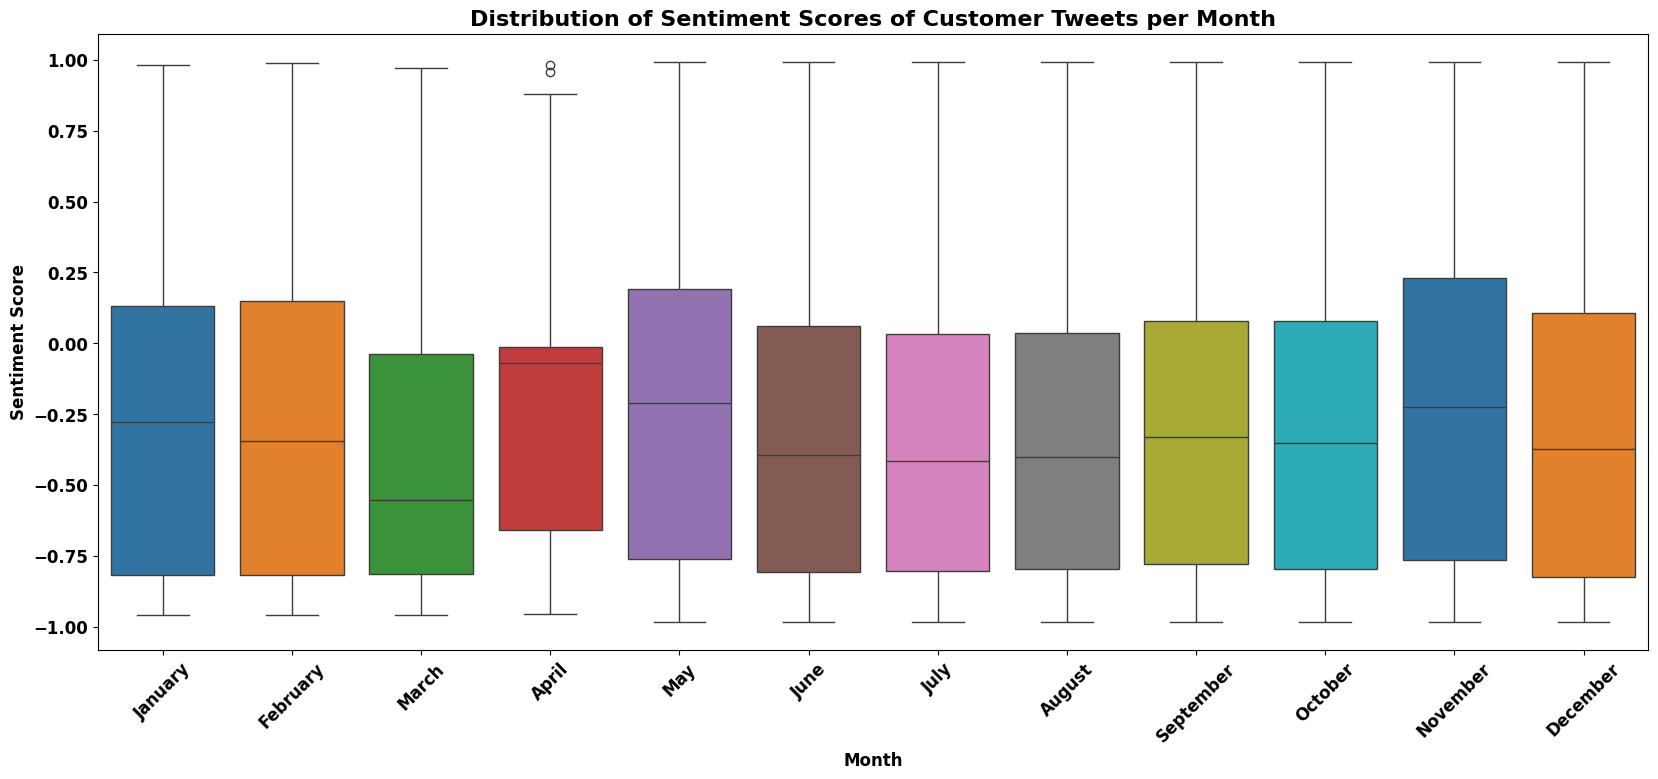

In [30]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Ensure sentiment_score is in numeric format
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Filter out the airline tweets to get only customer tweets
customer_tweets = df_reset[~df_reset['user_id'].isin(COMPANY_NAME_TO_ID.values())]

# Extract the month from the tweet creation time
customer_tweets['month'] = customer_tweets['tweet_creation_time'].dt.month_name()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the box plot
plt.figure(figsize=(20, 8))
sns.boxplot(x='month', y='sentiment_score', data=customer_tweets, order=[
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
], palette=colors[:12])

plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Distribution of Sentiment Scores of Customer Tweets per Month', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\1054927114.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_tweets['day_of_week'] = customer_tweets['tweet_creation_time'].dt.day_name()


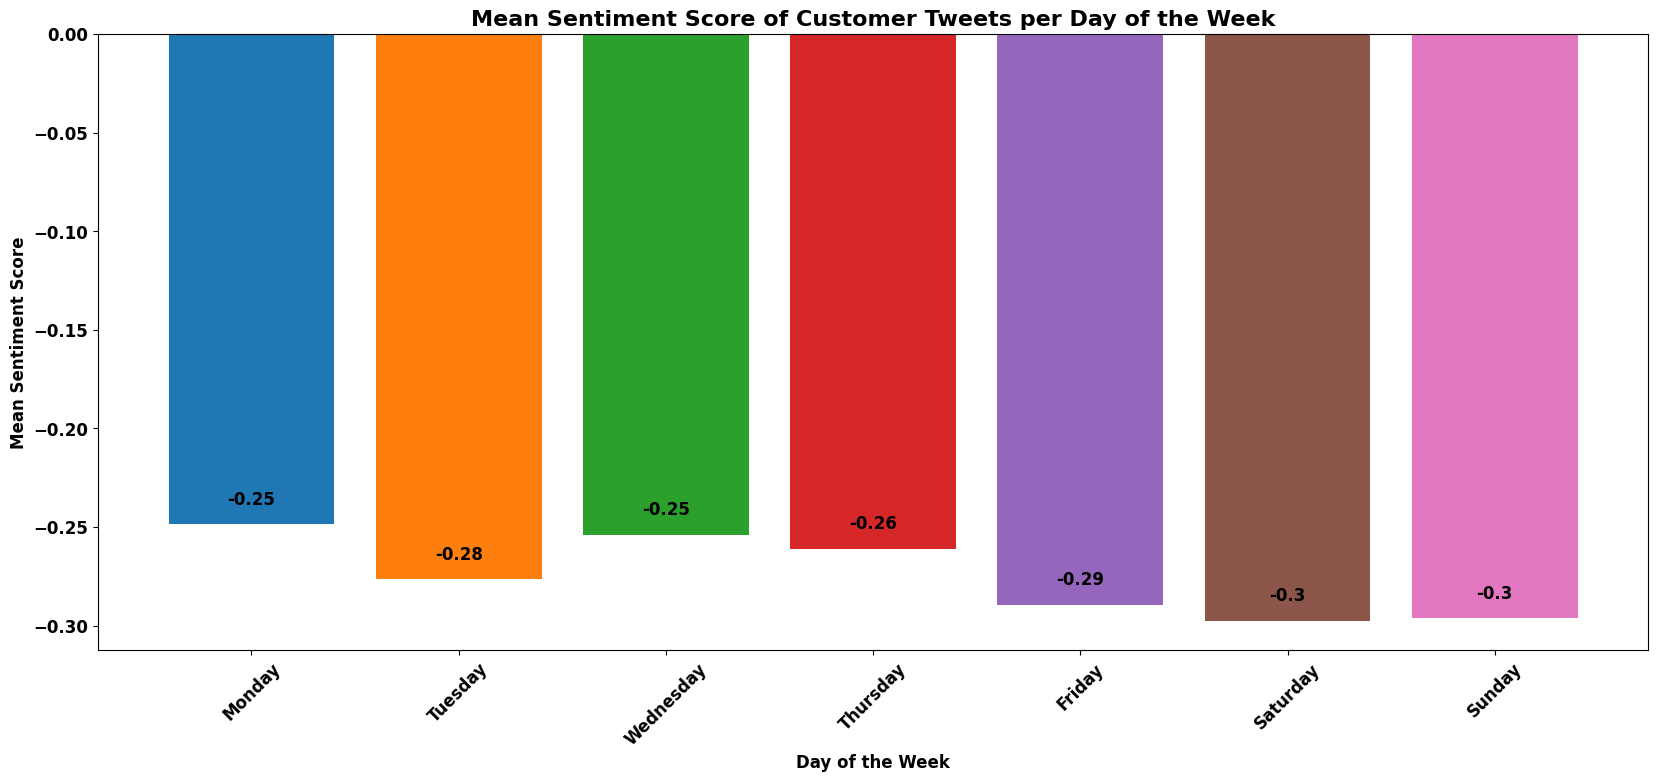

In [31]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Ensure sentiment_score is in numeric format
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Filter out the airline tweets to get only customer tweets
customer_tweets = df_reset[~df_reset['user_id'].isin(COMPANY_NAME_TO_ID.values())]

# Extract the day of the week from the tweet creation time
customer_tweets['day_of_week'] = customer_tweets['tweet_creation_time'].dt.day_name()

# Group by day of the week and calculate the mean sentiment score
mean_sentiment_per_day = customer_tweets.groupby('day_of_week')['sentiment_score'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(mean_sentiment_per_day.index, mean_sentiment_per_day.values, color=colors[:len(mean_sentiment_per_day)])
plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Mean Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Mean Sentiment Score of Customer Tweets per Day of the Week', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', fontsize=12, fontweight='bold')


C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\3640214894.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_tweets['day_of_week'] = customer_tweets['tweet_creation_time'].dt.day_name()
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\3640214894.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_of_week', y='sentiment_score', data=customer_tweets, order=[
c:\My programs\Python 3.12\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` inst

(array([-1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,
         1.  ,  1.25]),
 [Text(0, -1.25, '−1.25'),
  Text(0, -1.0, '−1.00'),
  Text(0, -0.75, '−0.75'),
  Text(0, -0.5, '−0.50'),
  Text(0, -0.25, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25')])

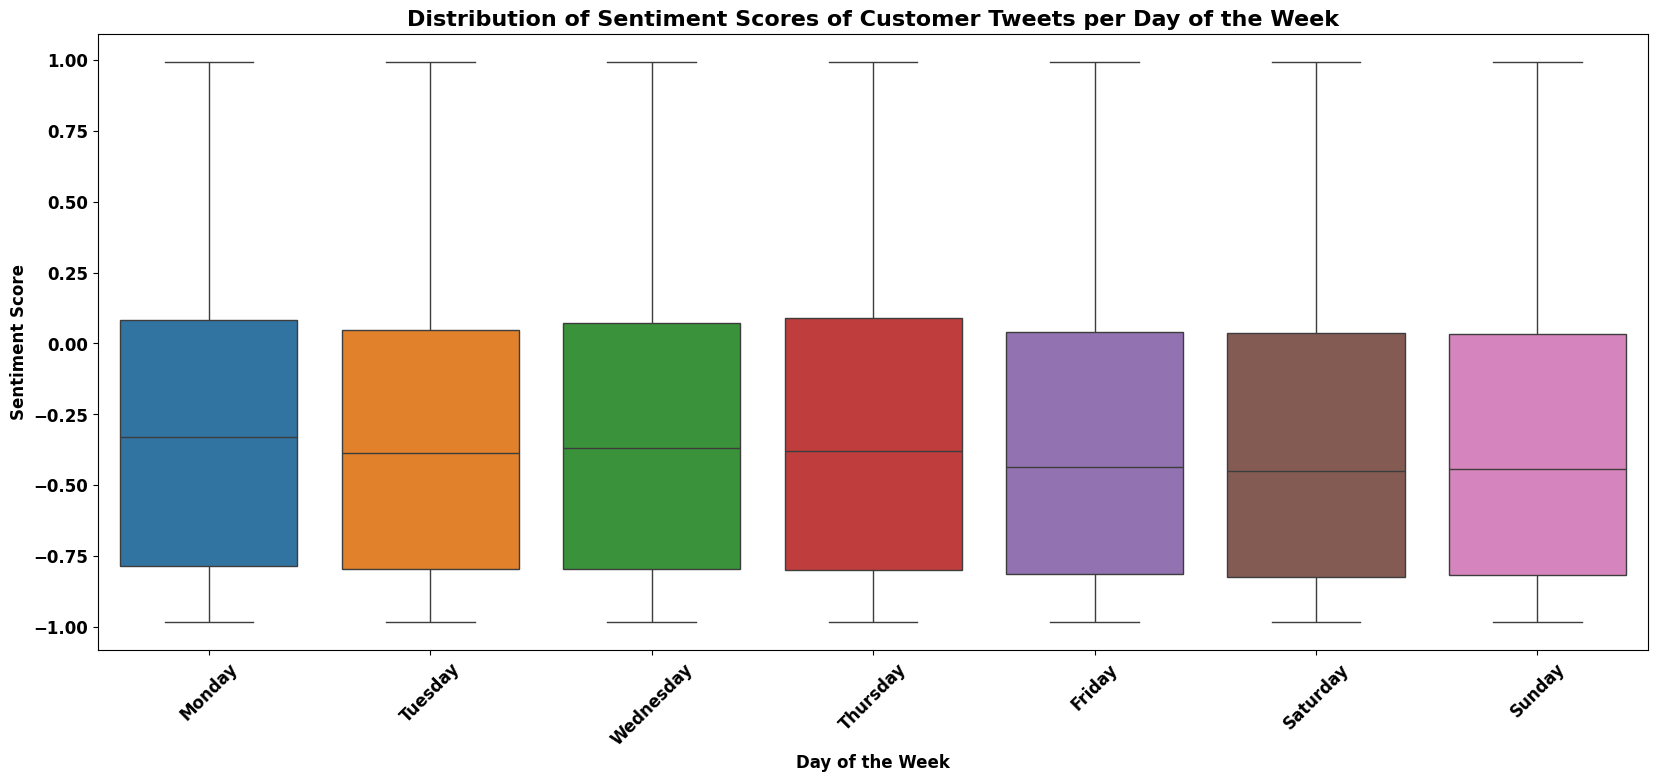

In [32]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Ensure sentiment_score is in numeric format
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Filter out the airline tweets to get only customer tweets
customer_tweets = df_reset[~df_reset['user_id'].isin(COMPANY_NAME_TO_ID.values())]

# Extract the day of the week from the tweet creation time
customer_tweets['day_of_week'] = customer_tweets['tweet_creation_time'].dt.day_name()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the box plot
plt.figure(figsize=(20, 8))
sns.boxplot(x='day_of_week', y='sentiment_score', data=customer_tweets, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], palette=colors[:7])

plt.xlabel('Day of the Week', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Distribution of Sentiment Scores of Customer Tweets per Day of the Week', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

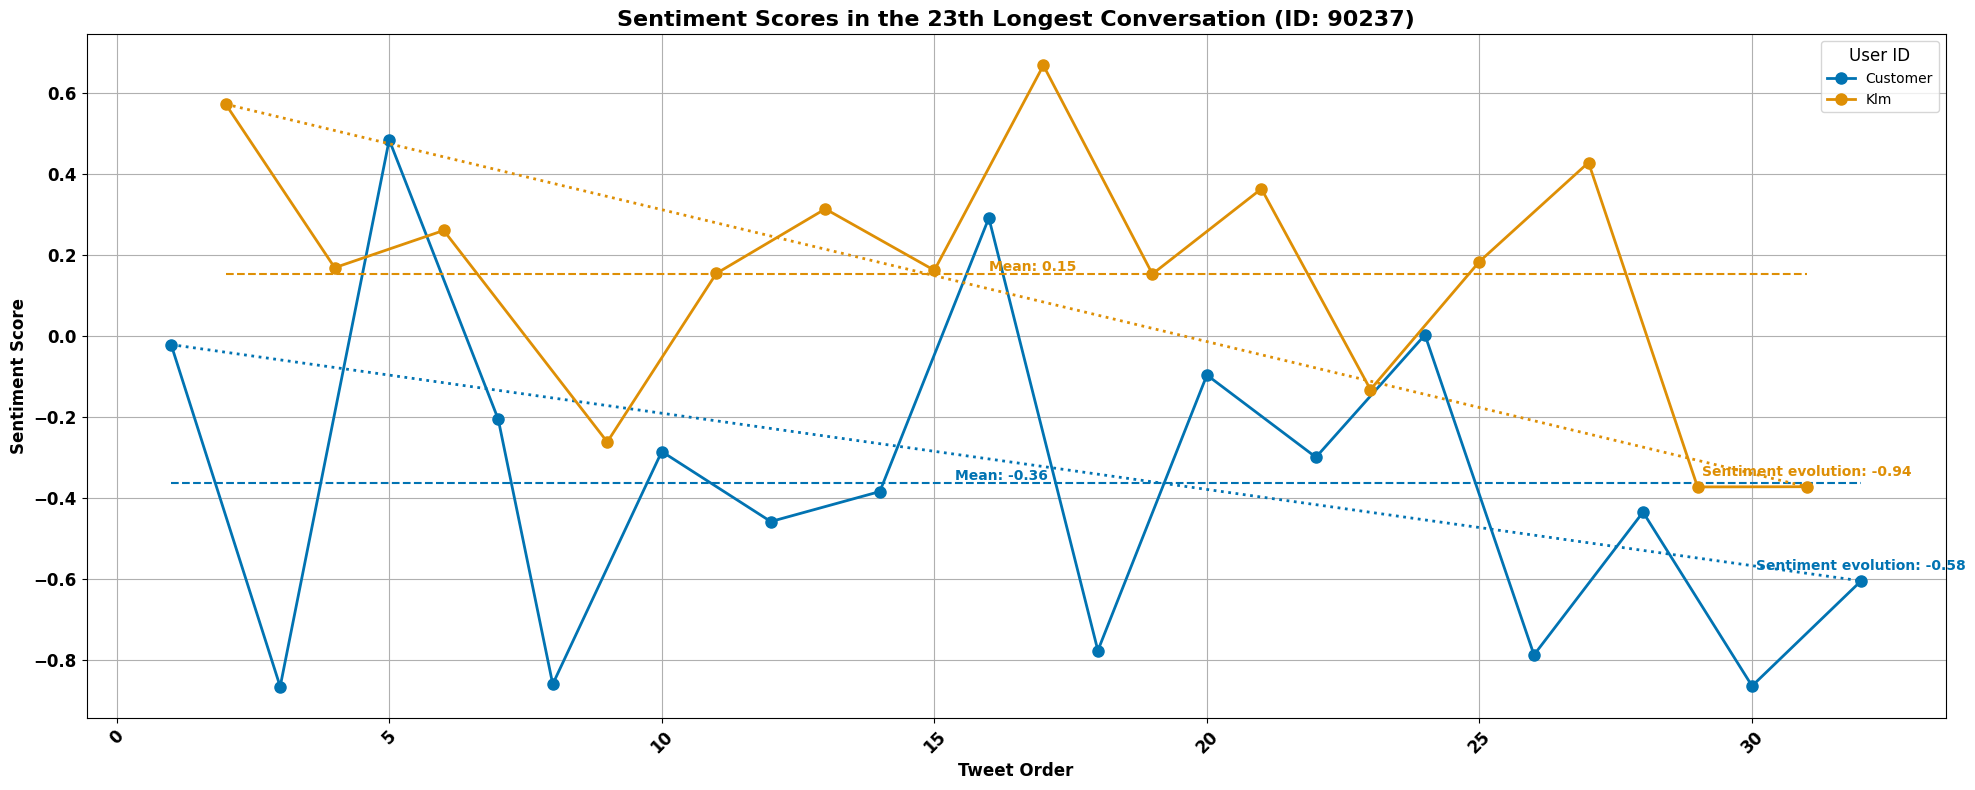

In [33]:
# Ensure tweet_creation_time is in datetime format
df_reset['tweet_creation_time'] = pd.to_datetime(df_reset['tweet_creation_time'])

# Ensure sentiment_score is in numeric format
df_reset['sentiment_score'] = pd.to_numeric(df_reset['sentiment_score'], errors='coerce')

# Find the nth longest conversation (for example, nth = 23)
nth = 23
conversation_lengths = df_reset['conversation_id'].value_counts()
nth_longest_conversation_id = conversation_lengths.index[nth - 1]

# Extract the tweets for the nth longest conversation
nth_longest_conversation_tweets = df_reset[df_reset['conversation_id'] == nth_longest_conversation_id]

# Sort tweets by tweet_order to plot in order
nth_longest_conversation_tweets = nth_longest_conversation_tweets.sort_values('tweet_order')

# Define the color palette
palette = sns.color_palette("colorblind", n_colors=len(nth_longest_conversation_tweets['user_id'].unique()))

# Map user_id to colors
user_color_map = {user: palette[i] for i, user in enumerate(nth_longest_conversation_tweets['user_id'].unique())}
nth_longest_conversation_tweets['color'] = nth_longest_conversation_tweets['user_id'].map(user_color_map)

# Calculate average sentiment score for each user
avg_sentiment_scores = nth_longest_conversation_tweets.groupby('user_id')['sentiment_score'].mean()

# Plot the scatter plot with lines connecting dots for each user
plt.figure(figsize=(20, 8))
for user_id, group in nth_longest_conversation_tweets.groupby('user_id'):
    plt.plot(group['tweet_order'], group['sentiment_score'], color=user_color_map[user_id], label=COMPANY_ID_TO_NAME.get(user_id, "Customer"), marker='o', linestyle='-', linewidth=2, markersize=8)
    avg_sentiment = avg_sentiment_scores[user_id]
    plt.hlines(avg_sentiment, xmin=group['tweet_order'].min(), xmax=group['tweet_order'].max(), colors=user_color_map[user_id], linestyles='dashed')
    
    # Add line connecting the first and last dot for each user
    plt.plot([group['tweet_order'].min(), group['tweet_order'].max()], [group['sentiment_score'].iloc[0], group['sentiment_score'].iloc[-1]], color=user_color_map[user_id], linestyle='dotted', linewidth=2)

    # Add mean sentiment score label
    plt.text(group['tweet_order'].mean(), avg_sentiment, f'Mean: {avg_sentiment:.2f}', color=user_color_map[user_id], fontsize=10, weight='bold', ha='center', va='bottom')
    
    # Add difference between first and last sentiment score label above the final dot
    first_last_diff = group['sentiment_score'].iloc[-1] - group['sentiment_score'].iloc[0]
    plt.text(group['tweet_order'].max(), group['sentiment_score'].iloc[-1] + 0.02, f'Sentiment evolution: {first_last_diff:.2f}', color=user_color_map[user_id], fontsize=10, weight='bold', ha='center', va='bottom')

plt.xlabel('Tweet Order', fontsize=12, weight='bold')
plt.ylabel('Sentiment Score', fontsize=12, weight='bold')
plt.title(f'Sentiment Scores in the {nth}th Longest Conversation (ID: {nth_longest_conversation_id})', fontsize=16, weight='bold')
plt.xticks(rotation=45, fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.legend(title='User ID', fontsize=10, title_fontsize=12)
plt.grid(True)
plt.tight_layout()

# Sentiment evolution

In [34]:
df_reset

conversation_id  tweet_order             tweet_id  \
0                      1            1  1244694453190897664   
1                      1            2  1244696682979303426   
2                      2            1  1244677304598609923   
3                      2            2  1244696641401163776   
4                      3            1  1244644204132909060   
...                  ...          ...                  ...   
1346561           493694            3   452657442057646080   
1346562           493695            1   451124070730719233   
1346563           493695            2   451125255294443521   
1346564           493696            1   430790355962052608   
1346565           493696            2   430792524043931648   

                    user_id        user_creation_time  \
0                 521835883 2012-03-12 01:11:22+00:00   
1                  20626359 2009-02-11 20:50:56+00:00   
2                 396021583 2011-10-22 16:35:05+00:00   
3        832964639436701696 2017-02-18 14:47:00+00:00   
4                 274980475 2011-03-31 11:55:53+00:00   
...                     ...                       ...   
1346561          2198564846 2013-11-16 23:24:47+00:00   
1346562           701977520 2012-07-17 23:34:18+00:00   
1346563            22536055 2009-03-02 21:23:05+00:00   
1346564            64327804 2009-08-10 03:34:27+00:00   
1346565            22536055 2009-03-02 21:23:05+00:00   

              tweet_creation_time  \
0       2020-03-30 18:34:17+00:00   
1       2020-03-30 18:43:09+00:00   
2       2020-03-30 17:26:09+00:00   
3       2020-03-30 18:42:59+00:00   
4       2020-03-30 15:14:37+00:00   
...                           ...   
1346561 2014-04-06 04:01:58+00:00   
1346562 2014-04-01 22:28:54+00:00   
1346563 2014-04-01 22:33:37+00:00   
1346564 2014-02-04 19:49:59+00:00   
1346565 2014-02-04 19:58:36+00:00   

                                                 full_text lang country_code  \
0        @nealrach @VirginAtlantic Siiiigh.... Still no...   en           un   
1        @Jade_Velveteese Hi Jade. We have an ‘Away fro...   en           un   
2        @VirginAtlantic Sod off your primary sharehold...   en           un   
3        @Boyde11 @VirginAtlantic Get your facts right,...   en           un   
4                          @easyJet Please reply to my DM!   en           un   
...                                                    ...  ...          ...   
1346561           @AmericanAir They cannot hear my screams   en           un   
1346562  @AmericanAir i was kidding thanks for the foll...   en           un   
1346563  @lanaupdates_ Your information has been forwar...   en           un   
1346564  @AmericanAir phew, they finally turned on the ...   en           un   
1346565  @benjy_greenberg It looks like we'll have you ...   en           un   

         sentiment_score          airline  
0               0.292771              NaN  
1               0.190686  Virgin Atlantic  
2              -0.909571              NaN  
3               0.058692              NaN  
4               0.076921              NaN  
...                  ...              ...  
1346561        -0.830774              NaN  
1346562         0.878425              NaN  
1346563         0.246197     American Air  
1346564         0.155998              NaN  
1346565         0.486518     American Air  

[1346566 rows x 11 columns]

In [35]:
# Group by 'Conversation' and 'user_id' to get the first and last sentiment scores
grouped = df_reset.groupby(['conversation_id', 'user_id'])

# Calculate the first and last sentiment scores
first_last_sentiments = grouped['sentiment_score'].agg(['first', 'last']).reset_index()

# Calculate the change in sentiment score
first_last_sentiments['change_in_sentiment'] = first_last_sentiments['last'] - first_last_sentiments['first']
# df_conversations_full = df_conversations_full.merge(first_last_sentiments[['Conversation', 'user_id', 'change_in_sentiment']], on=['Conversation', 'user_id'], how='left')
first_last_sentiments[["conversation_id", "user_id", "change_in_sentiment"]]

conversation_id             user_id  change_in_sentiment
0                     1            20626359                  0.0
1                     1           521835883                  0.0
2                     2           396021583                  0.0
3                     2  832964639436701696                  0.0
4                     3           274980475                  0.0
...                 ...                 ...                  ...
987387           493694            22536055                  0.0
987388           493695            22536055                  0.0
987389           493695           701977520                  0.0
987390           493696            22536055                  0.0
987391           493696            64327804                  0.0

[987392 rows x 3 columns]

In [36]:
def categorize_sentiment_change(change):
    if change > 0:
        return 'Positive'
    elif change < 0:
        return 'Negative'
    else:
        return 'Neutral'

average_sentiment_per_user = df_reset.groupby(['conversation_id', 'user_id']).agg(
    tweets_number=("sentiment_score", "count"),
    average_sentiment=("sentiment_score", "mean"),
    min_sentiment=("sentiment_score", "min"),
    max_sentiment=("sentiment_score", "max"),
    first_tweet=("tweet_creation_time", "min")
).reset_index()

# Merge first_last_sentiments with average_sentiment_per_user
merged_df = pd.merge(average_sentiment_per_user, first_last_sentiments[['conversation_id', 'user_id', 'change_in_sentiment']],
                     on=['conversation_id', 'user_id'], how='left')
merged_df['sentiment_trend'] = merged_df['change_in_sentiment'].apply(categorize_sentiment_change)
merged_df["airline"] = merged_df["user_id"].map(COMPANY_ID_TO_NAME)
merged_df

conversation_id             user_id  tweets_number  average_sentiment  \
0                     1            20626359              1           0.190686   
1                     1           521835883              1           0.292771   
2                     2           396021583              1          -0.909571   
3                     2  832964639436701696              1           0.058692   
4                     3           274980475              1           0.076921   
...                 ...                 ...            ...                ...   
987387           493694            22536055              1           0.024142   
987388           493695            22536055              1           0.246197   
987389           493695           701977520              1           0.878425   
987390           493696            22536055              1           0.486518   
987391           493696            64327804              1           0.155998   

        min_sentiment  max_sentiment               first_tweet  \
0            0.190686       0.190686 2020-03-30 18:43:09+00:00   
1            0.292771       0.292771 2020-03-30 18:34:17+00:00   
2           -0.909571      -0.909571 2020-03-30 17:26:09+00:00   
3            0.058692       0.058692 2020-03-30 18:42:59+00:00   
4            0.076921       0.076921 2020-03-30 15:14:37+00:00   
...               ...            ...                       ...   
987387       0.024142       0.024142 2014-04-06 04:01:23+00:00   
987388       0.246197       0.246197 2014-04-01 22:33:37+00:00   
987389       0.878425       0.878425 2014-04-01 22:28:54+00:00   
987390       0.486518       0.486518 2014-02-04 19:58:36+00:00   
987391       0.155998       0.155998 2014-02-04 19:49:59+00:00   

        change_in_sentiment sentiment_trend          airline  
0                       0.0         Neutral  Virgin Atlantic  
1                       0.0         Neutral              NaN  
2                       0.0         Neutral              NaN  
3                       0.0         Neutral              NaN  
4                       0.0         Neutral              NaN  
...                     ...             ...              ...  
987387                  0.0         Neutral     American Air  
987388                  0.0         Neutral     American Air  
987389                  0.0         Neutral              NaN  
987390                  0.0         Neutral     American Air  
987391                  0.0         Neutral              NaN  

[987392 rows x 10 columns]

C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\1754657721.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conversations_with_more_than_2_tweets["airline"] = conversations_with_more_than_2_tweets["user_id"].map(COMPANY_ID_TO_NAME)


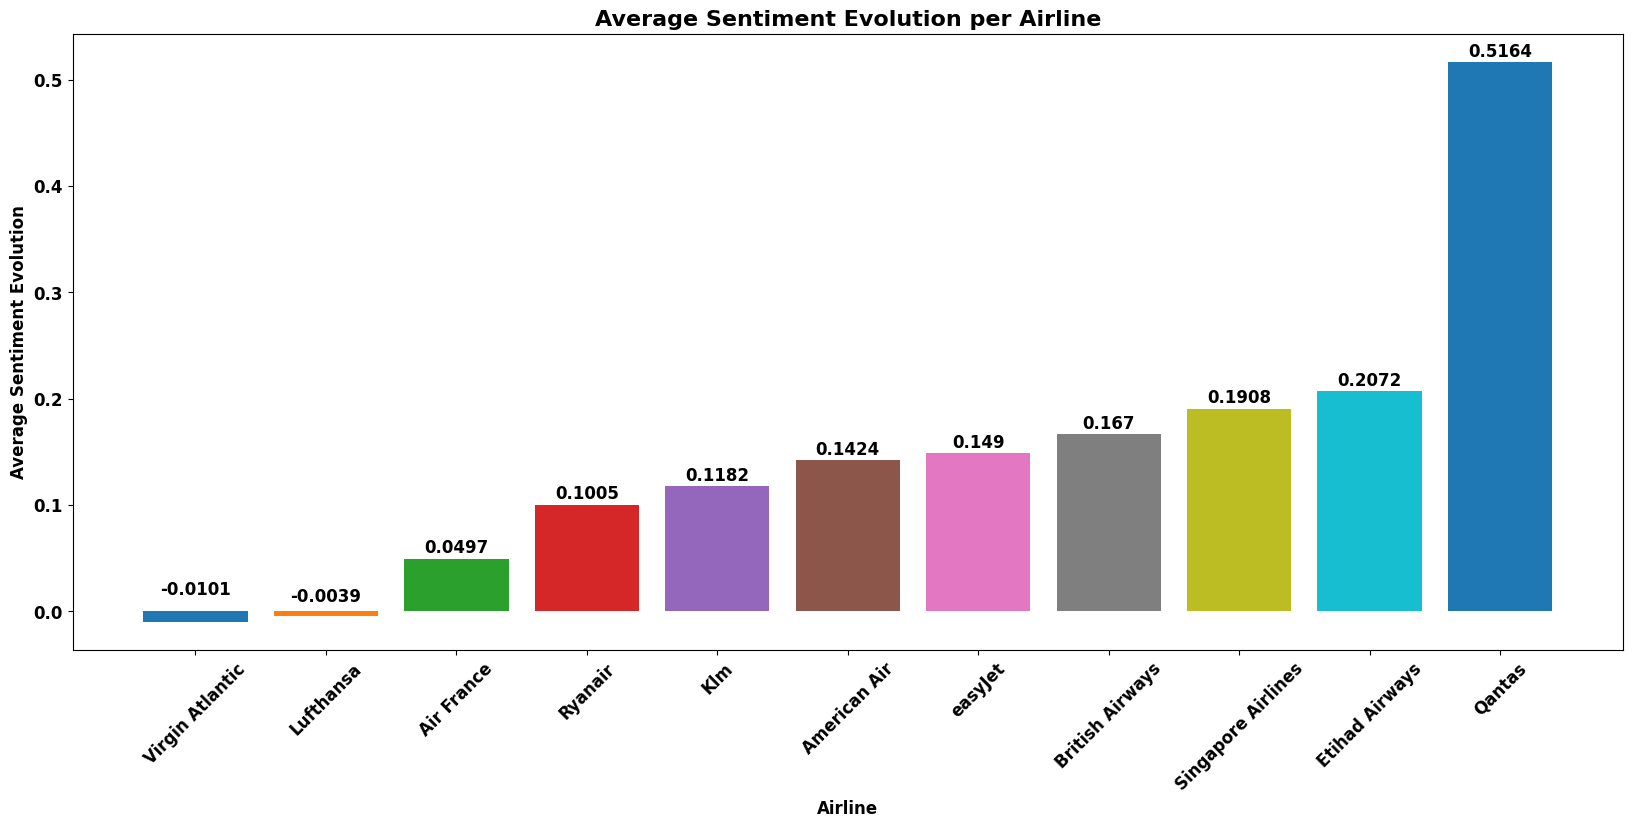

In [37]:
# Filter the DataFrame to include only conversations with more than 2 tweets
conversations_with_more_than_2_tweets = merged_df[merged_df['tweets_number'] > 2]
conversations_with_more_than_2_tweets["airline"] = conversations_with_more_than_2_tweets["user_id"].map(COMPANY_ID_TO_NAME)
# Group by airline and calculate the average change in sentiment
average_change_in_sentiment = conversations_with_more_than_2_tweets.groupby('airline')['change_in_sentiment'].mean().sort_values()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(average_change_in_sentiment.index, average_change_in_sentiment.values, color=colors[:len(average_change_in_sentiment)])
plt.xlabel('Airline', fontsize=12, fontweight='bold')
plt.ylabel('Average Sentiment Evolution', fontsize=12, fontweight='bold')
plt.title('Average Sentiment Evolution per Airline', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, abs(yval) + 0.005, round(yval, 4), ha='center', fontsize=12, fontweight='bold')


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


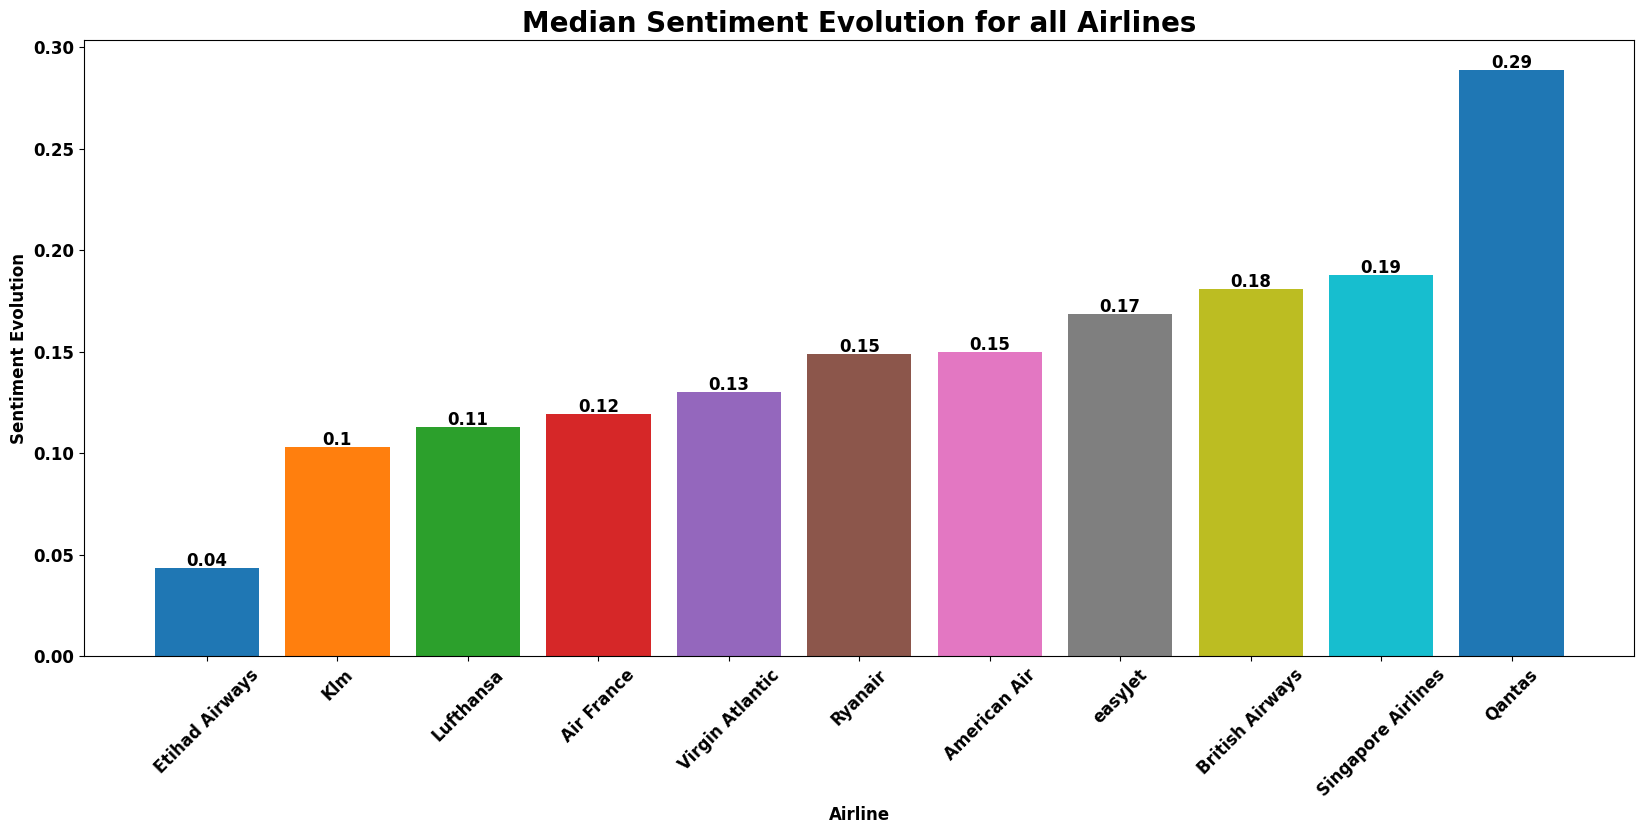

In [38]:
# Filter out the conversations where the airline is not NaN
airline_conversations = merged_df.dropna(subset=['airline'])

# Find all unique conversations per airline
conversation_airlines = airline_conversations.groupby('airline')['conversation_id'].unique()

# Initialize list to hold data for plotting
plot_data = []

# Iterate over each airline and calculate the average change_in_sentiment for all users involved in conversations with that airline
for airline, conversations in conversation_airlines.items():
    users_in_conversations = merged_df[merged_df['conversation_id'].isin(conversations)].query("change_in_sentiment != 0")
    avg_change = users_in_conversations['change_in_sentiment'].median()
    plot_data.append({'airline': airline, 'avg_change_in_sentiment': avg_change})

# Convert plot_data to a DataFrame
plot_df = pd.DataFrame(plot_data)

# Sort the DataFrame by 'avg_change_in_sentiment' in increasing order
plot_df = plot_df.sort_values(by='avg_change_in_sentiment')

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(plot_df['airline'], plot_df['avg_change_in_sentiment'], color=colors[:len(plot_df['airline'])])
plt.xlabel('Airline', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment Evolution', fontsize=12, fontweight='bold')
plt.title('Median Sentiment Evolution for all Airlines', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.001, round(yval, 2), ha='center', fontsize=12, fontweight='bold')


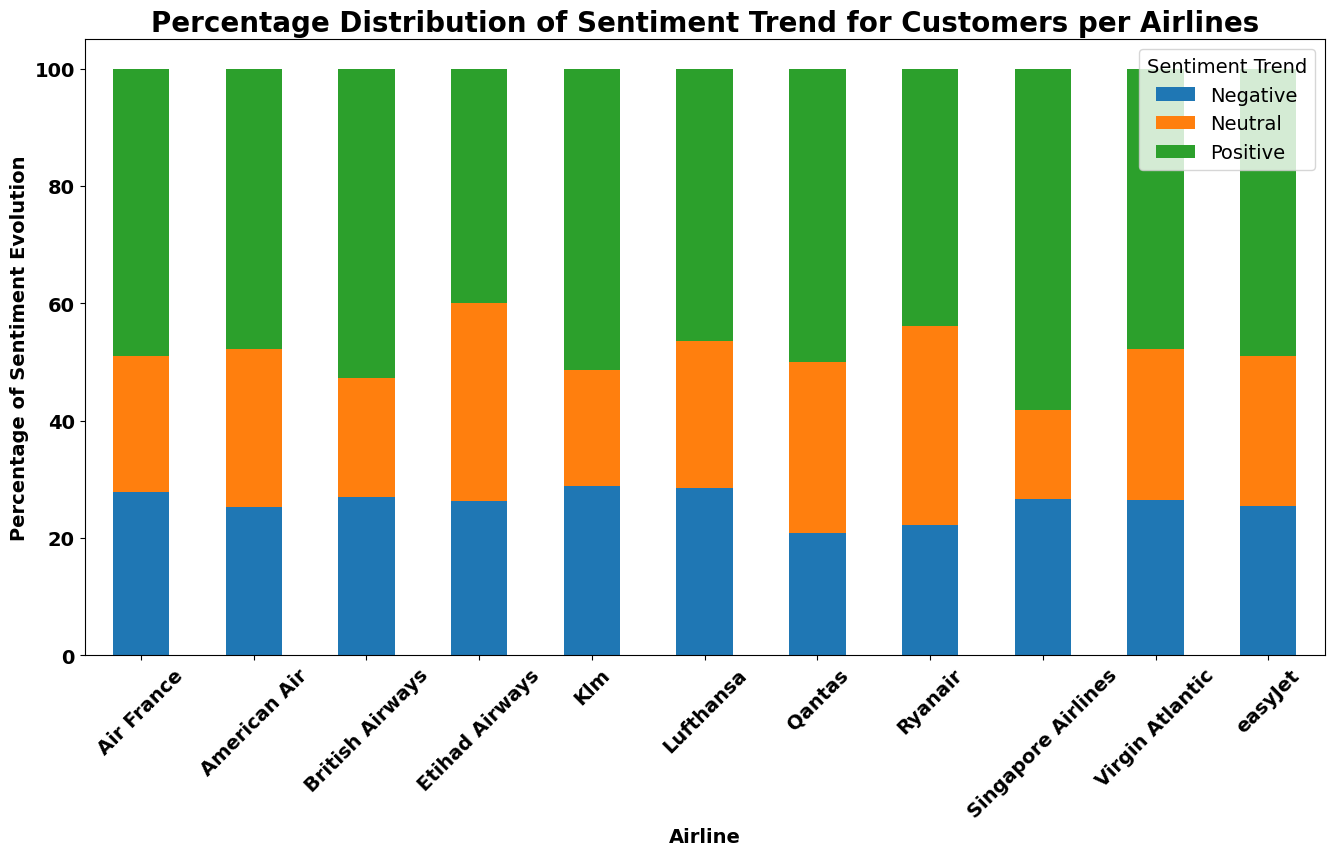

In [39]:
filtered_df = merged_df[merged_df['tweets_number'] >= 2]

# Exclude conversations associated with airlines
non_airline_df = filtered_df[filtered_df['airline'].isna()]

# Filter out the conversations where the airline is not NaN
airline_conversations = merged_df.dropna(subset=['airline'])

# Find all unique conversations per airline
conversation_airlines = airline_conversations.groupby('airline')['conversation_id'].unique()

# Initialize list to hold data for plotting
plot_data = []

# Iterate over each airline and collect sentiment trends for all users involved in conversations with that airline
for airline, conversations in conversation_airlines.items():
    users_in_conversations = merged_df[merged_df['conversation_id'].isin(conversations)]
    users_in_conversations = users_in_conversations[users_in_conversations['conversation_id'].isin(non_airline_df['conversation_id'])]
    plot_data.extend(
        {
            'airline': airline,
            'change_in_sentiment': row['change_in_sentiment'],
            'sentiment_trend': row['sentiment_trend'],
        }
        for _, row in users_in_conversations.iterrows()
    )

# Convert plot_data to a DataFrame
plot_df = pd.DataFrame(plot_data)

# Calculate the count of sentiment trends for each airline
sentiment_trend_counts = plot_df.groupby(['airline', 'sentiment_trend']).size().unstack()

# Normalize the counts to percentages
sentiment_trend_percentages = sentiment_trend_counts.div(sentiment_trend_counts.sum(axis=1), axis=0) * 100

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the stacked bar chart
plt.figure(figsize=(16, 8))
sentiment_trend_percentages.loc[:, ['Negative', 'Neutral', 'Positive']].plot(kind='bar', stacked=True, color=colors[:3], ax=plt.gca())
plt.xlabel('Airline', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Sentiment Evolution', fontsize=14, fontweight='bold')
plt.title('Percentage Distribution of Sentiment Trend for Customers per Airlines', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(title='Sentiment Trend', fontsize=14, title_fontsize=14)

C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\2579068233.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_customer_tweets['month'] = valid_customer_tweets['first_tweet'].dt.strftime('%B')
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\2579068233.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=median_sentiment_per_month.index, y=median_sentiment_per_month.values, palette=colors)
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\2579068233.py:31: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable p

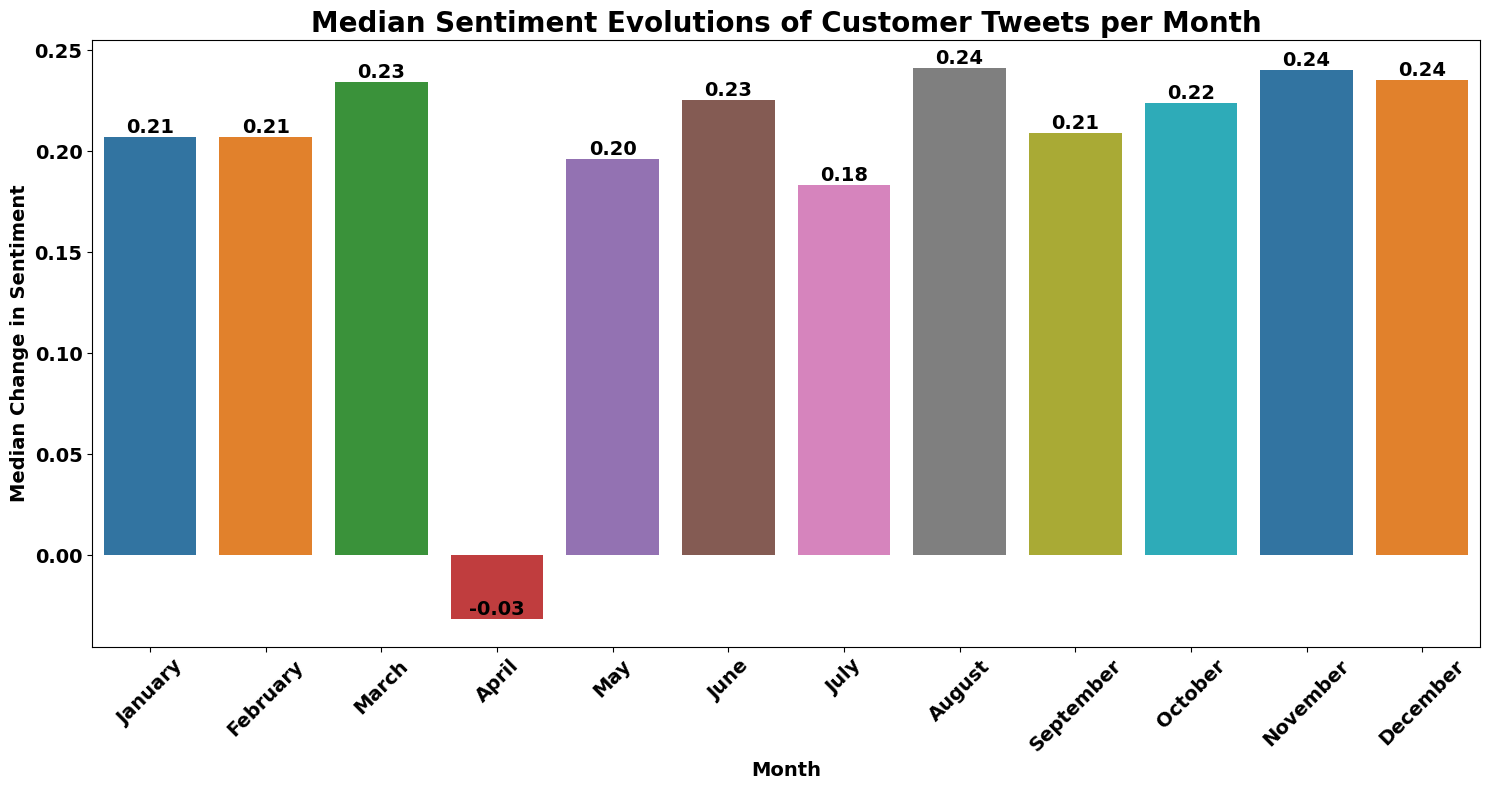

In [40]:
# Convert first_tweet to datetime if not already done
merged_df['first_tweet'] = pd.to_datetime(merged_df['first_tweet'])

# Identify customer tweets (tweets not from airlines)
customer_tweets = merged_df[merged_df['airline'].isna()]

# Filter conversations with more than 2 customer tweets
valid_customer_tweets = customer_tweets.query("tweets_number > 2")

# Extract the month from tweet creation time
valid_customer_tweets['month'] = valid_customer_tweets['first_tweet'].dt.strftime('%B')

# Calculate the median sentiment evolution per conversation
median_sentiment_evolution = valid_customer_tweets.groupby('conversation_id')['change_in_sentiment'].median().reset_index()

# Merge with the month information
valid_customer_tweets = valid_customer_tweets[['conversation_id', 'month']].drop_duplicates()
median_sentiment_evolution = median_sentiment_evolution.merge(valid_customer_tweets, on='conversation_id')

# Calculate the median sentiment change per month
median_sentiment_per_month = median_sentiment_evolution.groupby('month')['change_in_sentiment'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a color palette using mcolors
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(x=median_sentiment_per_month.index, y=median_sentiment_per_month.values, palette=colors)

# Add numerical values on top of each bar
for index, value in enumerate(median_sentiment_per_month.values):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Median Change in Sentiment', fontsize=14, fontweight='bold')
plt.title('Median Sentiment Evolutions of Customer Tweets per Month', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.tight_layout()

C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\3890179129.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_customer_tweets['month'] = valid_customer_tweets['first_tweet'].dt.strftime('%B')
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\3890179129.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_customer_tweets_lufthansa['month'] = valid_customer_tweets_lufthansa['first_tweet'].dt.strftime('%B')
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\3890179129.py:58: FutureWarning: 

Passin

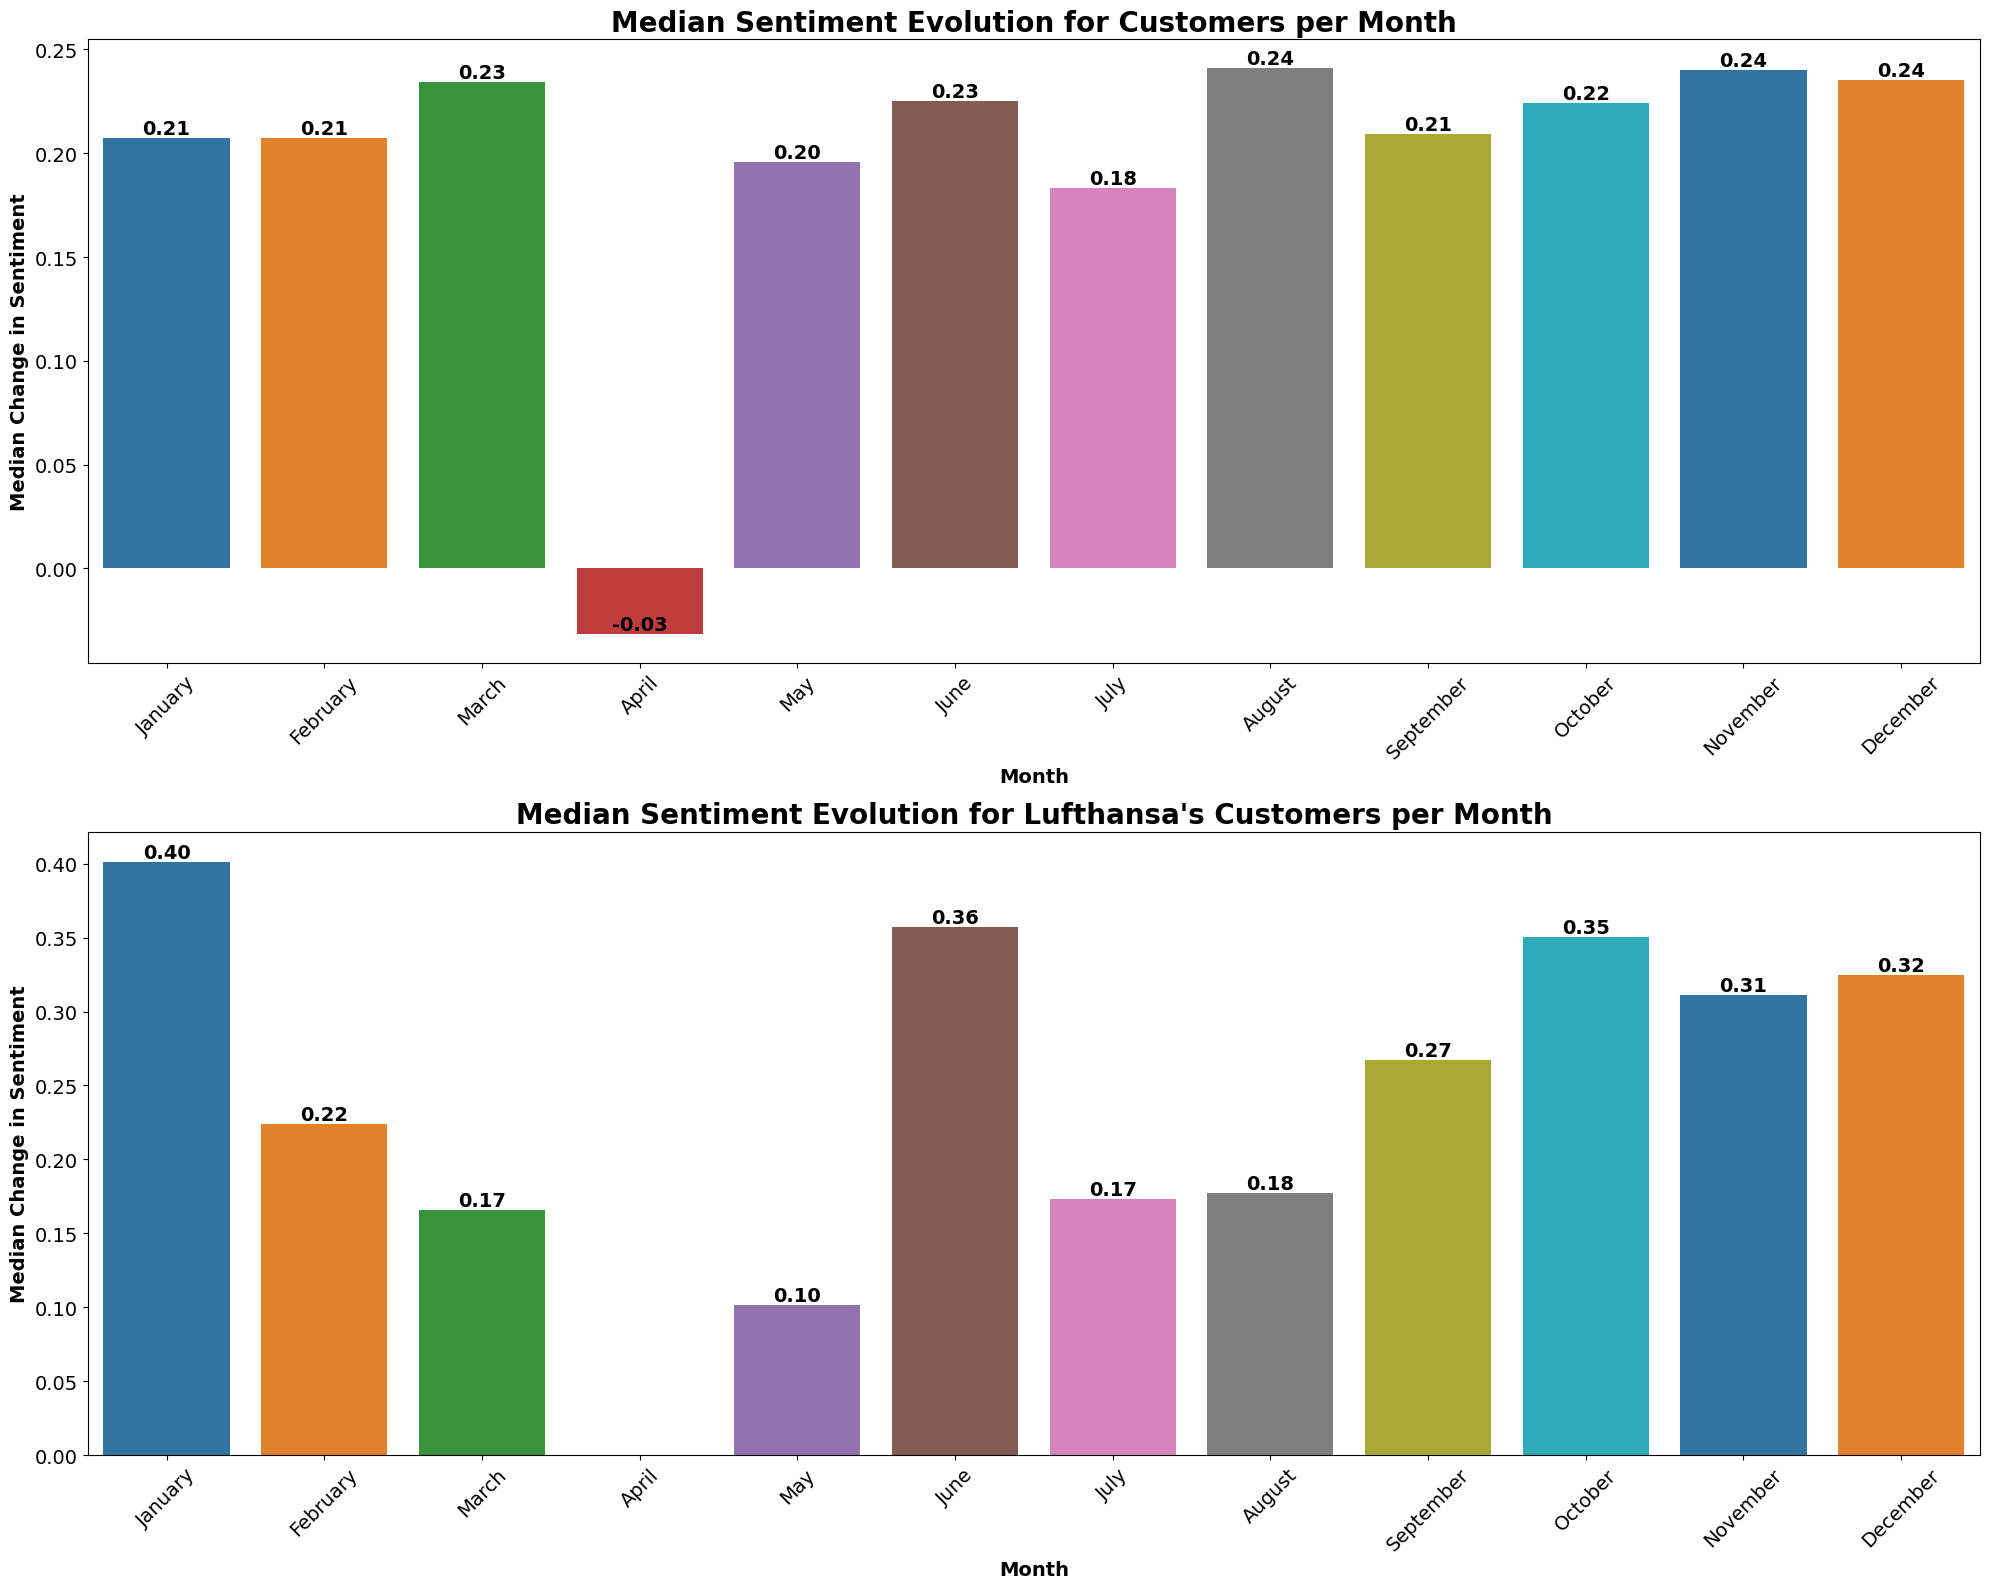

In [41]:
# Convert first_tweet to datetime if not already done
merged_df['first_tweet'] = pd.to_datetime(merged_df['first_tweet'])

# Identify customer tweets (tweets not from airlines)
customer_tweets = merged_df[merged_df['airline'].isna()]

# Filter conversations with more than 2 customer tweets
valid_customer_tweets = customer_tweets.query("tweets_number > 2")

# Extract the month from tweet creation time
valid_customer_tweets['month'] = valid_customer_tweets['first_tweet'].dt.strftime('%B')

# Calculate the median sentiment evolution per conversation
median_sentiment_evolution = valid_customer_tweets.groupby('conversation_id')['change_in_sentiment'].median().reset_index()

# Merge with the month information
valid_customer_tweets = valid_customer_tweets[['conversation_id', 'month']].drop_duplicates()
median_sentiment_evolution = median_sentiment_evolution.merge(valid_customer_tweets, on='conversation_id')

# Calculate the median sentiment change per month
median_sentiment_per_month = median_sentiment_evolution.groupby('month')['change_in_sentiment'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Filter conversations involving Lufthansa
lufthansa_conversations = merged_df[merged_df['airline'] == 'Lufthansa']['conversation_id'].unique()

# Identify customer tweets in conversations where Lufthansa is participating
customer_tweets_lufthansa = merged_df[merged_df['conversation_id'].isin(lufthansa_conversations) & merged_df['airline'].isna()]

# Filter conversations with more than 2 customer tweets
valid_customer_tweets_lufthansa = customer_tweets_lufthansa.query("tweets_number > 2")

# Extract the month from tweet creation time
valid_customer_tweets_lufthansa['month'] = valid_customer_tweets_lufthansa['first_tweet'].dt.strftime('%B')

# Calculate the median sentiment evolution per conversation
median_sentiment_evolution_lufthansa = valid_customer_tweets_lufthansa.groupby('conversation_id')['change_in_sentiment'].median().reset_index()

# Merge with the month information
valid_customer_tweets_lufthansa = valid_customer_tweets_lufthansa[['conversation_id', 'month']].drop_duplicates()
median_sentiment_evolution_lufthansa = median_sentiment_evolution_lufthansa.merge(valid_customer_tweets_lufthansa, on='conversation_id')

# Calculate the median sentiment change per month
median_sentiment_per_month_lufthansa = median_sentiment_evolution_lufthansa.groupby('month')['change_in_sentiment'].median().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
])

# Define a color palette using mcolors
colors = list(mcolors.TABLEAU_COLORS.values())

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 16))

# First plot: Median Sentiment Evolutions of Customer Tweets per Month
sns.barplot(ax=axs[0], x=median_sentiment_per_month.index, y=median_sentiment_per_month.values, palette=colors)
axs[0].set_xlabel('Month', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Median Change in Sentiment', fontsize=14, fontweight='bold')
axs[0].set_title('Median Sentiment Evolution for Customers per Month', fontsize=20, fontweight='bold')
axs[0].tick_params(axis='x', rotation=45, labelsize=14)
axs[0].tick_params(axis='y', labelsize=14)

# Add numerical values on top of each bar
for index, value in enumerate(median_sentiment_per_month.values):
    axs[0].text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Second plot: Median Sentiment Evolution of Customer Tweets in Conversations with Lufthansa per Month
sns.barplot(ax=axs[1], x=median_sentiment_per_month_lufthansa.index, y=median_sentiment_per_month_lufthansa.values, palette=colors)
axs[1].set_xlabel('Month', fontsize=14, fontweight='bold')
axs[1].set_ylabel('Median Change in Sentiment', fontsize=14, fontweight='bold')
axs[1].set_title("Median Sentiment Evolution for Lufthansa's Customers per Month", fontsize=20, fontweight='bold')
axs[1].tick_params(axis='x', rotation=45, labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)

# Add numerical values on top of each bar
for index, value in enumerate(median_sentiment_per_month_lufthansa.values):
    axs[1].text(index, value, f'{value:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()

In [42]:
merged_df

conversation_id             user_id  tweets_number  average_sentiment  \
0                     1            20626359              1           0.190686   
1                     1           521835883              1           0.292771   
2                     2           396021583              1          -0.909571   
3                     2  832964639436701696              1           0.058692   
4                     3           274980475              1           0.076921   
...                 ...                 ...            ...                ...   
987387           493694            22536055              1           0.024142   
987388           493695            22536055              1           0.246197   
987389           493695           701977520              1           0.878425   
987390           493696            22536055              1           0.486518   
987391           493696            64327804              1           0.155998   

        min_sentiment  max_sentiment               first_tweet  \
0            0.190686       0.190686 2020-03-30 18:43:09+00:00   
1            0.292771       0.292771 2020-03-30 18:34:17+00:00   
2           -0.909571      -0.909571 2020-03-30 17:26:09+00:00   
3            0.058692       0.058692 2020-03-30 18:42:59+00:00   
4            0.076921       0.076921 2020-03-30 15:14:37+00:00   
...               ...            ...                       ...   
987387       0.024142       0.024142 2014-04-06 04:01:23+00:00   
987388       0.246197       0.246197 2014-04-01 22:33:37+00:00   
987389       0.878425       0.878425 2014-04-01 22:28:54+00:00   
987390       0.486518       0.486518 2014-02-04 19:58:36+00:00   
987391       0.155998       0.155998 2014-02-04 19:49:59+00:00   

        change_in_sentiment sentiment_trend          airline  
0                       0.0         Neutral  Virgin Atlantic  
1                       0.0         Neutral              NaN  
2                       0.0         Neutral              NaN  
3                       0.0         Neutral              NaN  
4                       0.0         Neutral              NaN  
...                     ...             ...              ...  
987387                  0.0         Neutral     American Air  
987388                  0.0         Neutral     American Air  
987389                  0.0         Neutral              NaN  
987390                  0.0         Neutral     American Air  
987391                  0.0         Neutral              NaN  

[987392 rows x 10 columns]

# Categorization

In [43]:
df_categories = get_categories("SELECT * from ConversationsCategory WHERE category IS NOT 'No Category'", path)

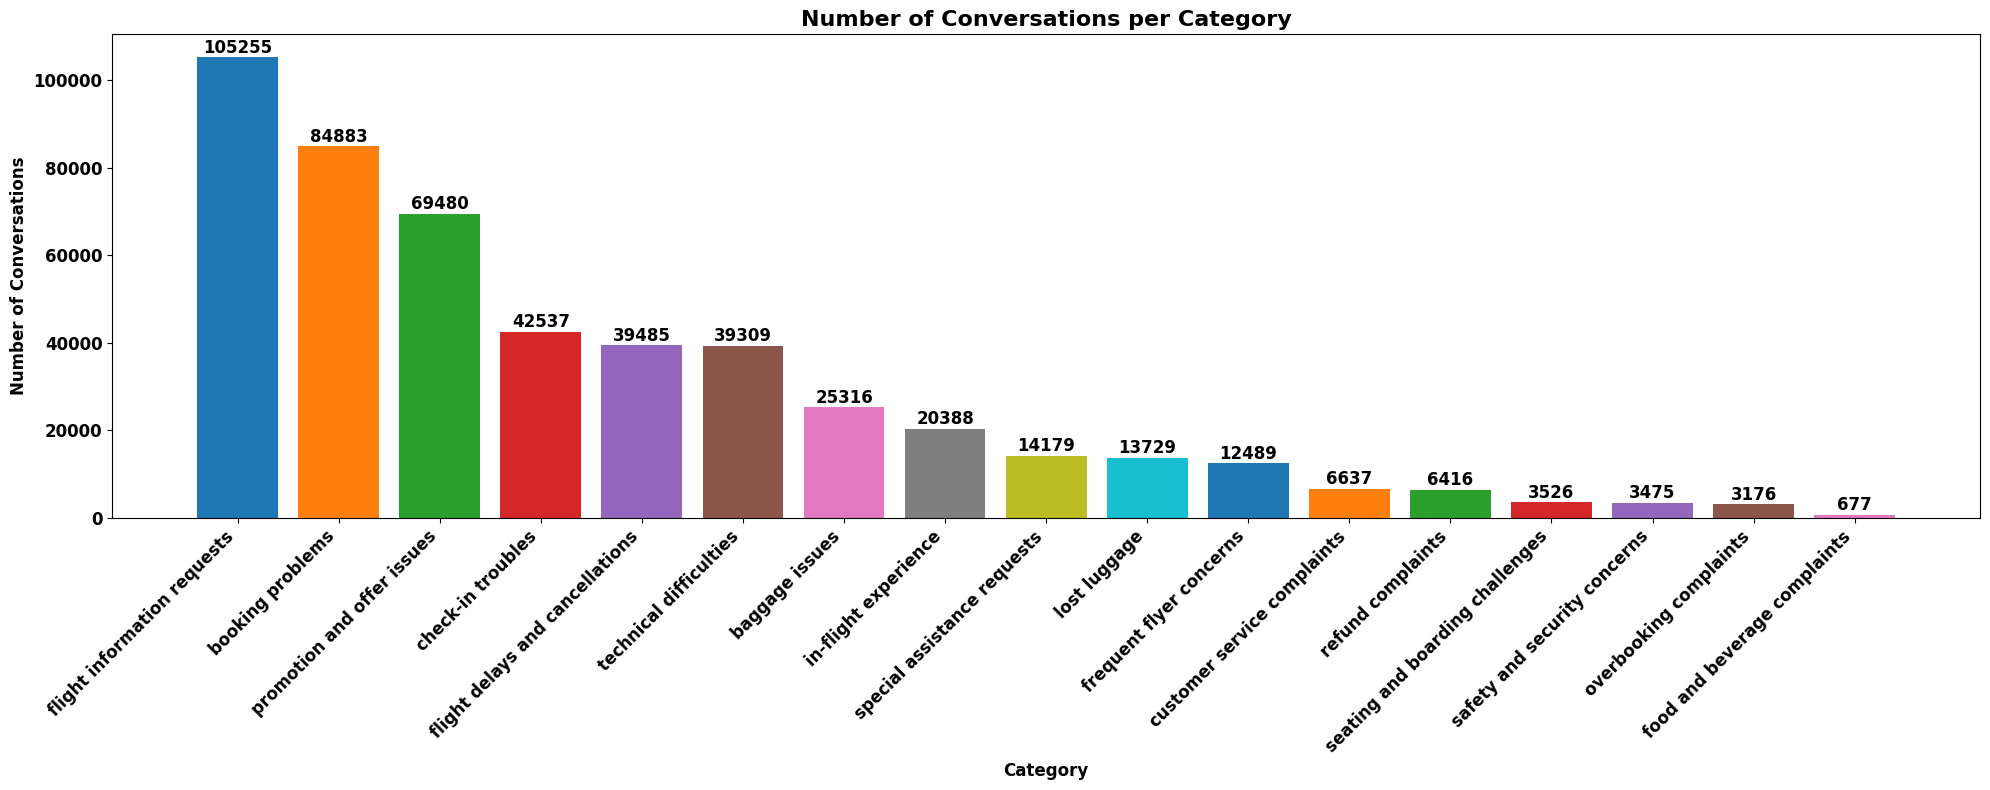

In [44]:
# Calculate the category counts
category_counts = df_categories['category'].value_counts()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(category_counts.index, category_counts.values, color=colors[:len(category_counts)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of Conversations', fontsize=12, fontweight='bold')
plt.title('Number of Conversations per Category', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, int(yval), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

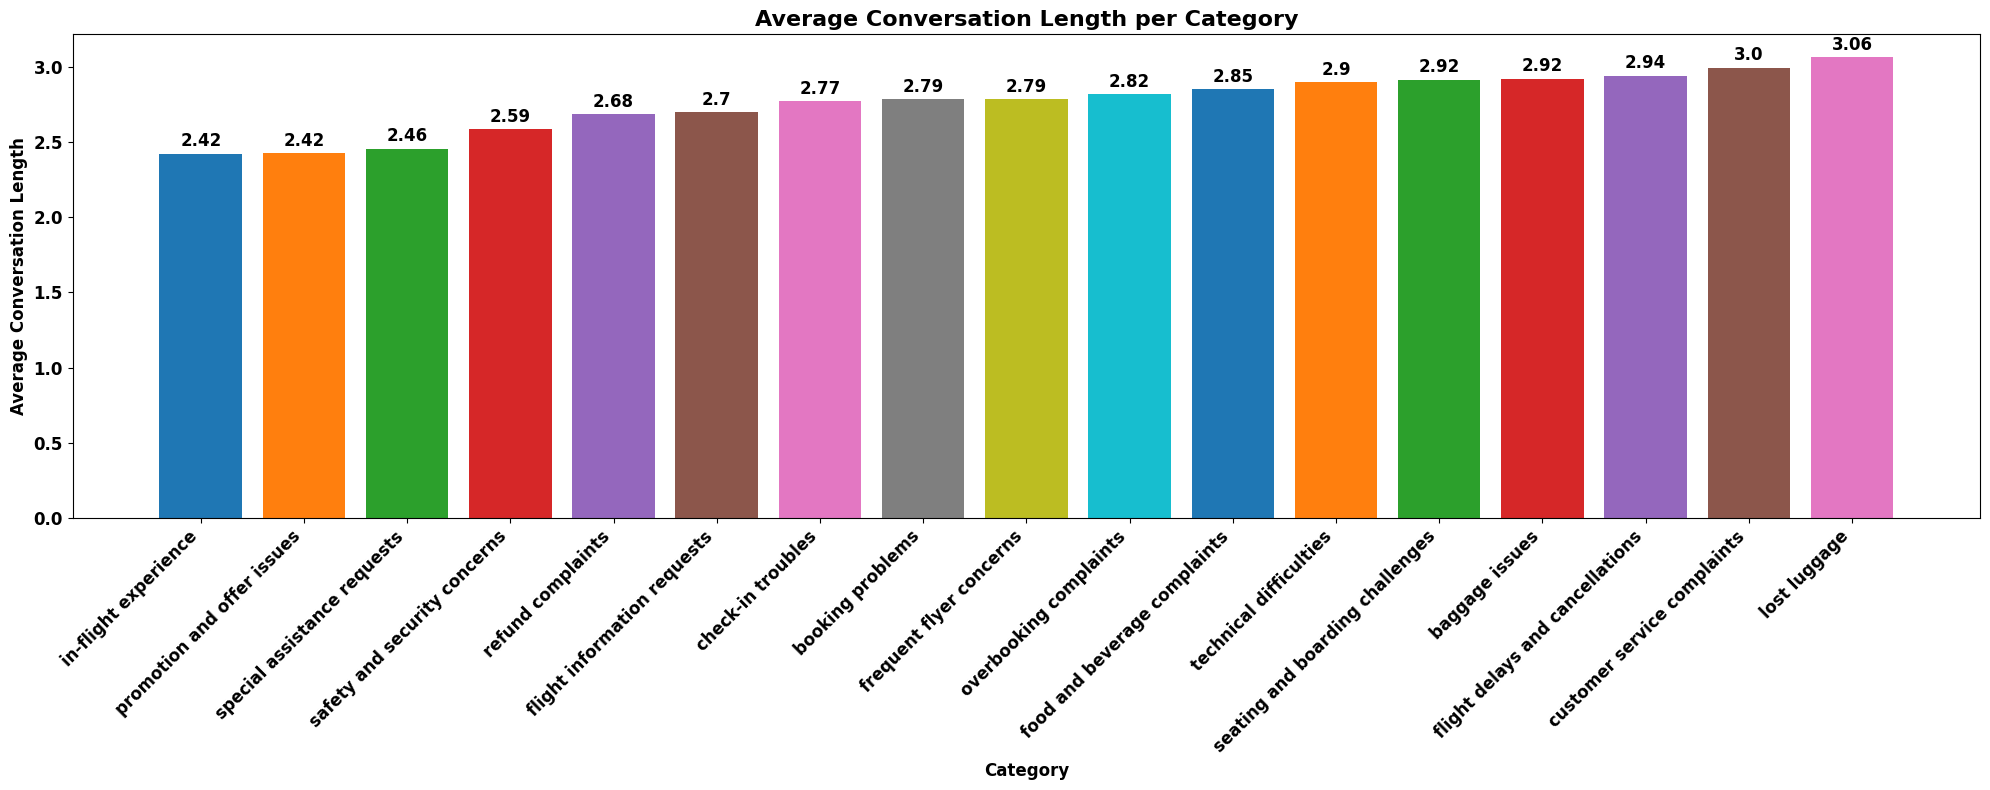

In [45]:
# Merge the conversation lengths with df_categories to get the category information
together = pd.merge(conversation_lengths, df_categories, on='conversation_id')
# Compute the average conversation length per category
avg_conversation_length_per_category = together.groupby('category')['count'].mean().sort_values()

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(avg_conversation_length_per_category.index, avg_conversation_length_per_category.values, color=colors[:len(avg_conversation_length_per_category)])

plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Average Conversation Length', fontsize=12, fontweight='bold')
plt.title('Average Conversation Length per Category', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\1429632263.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='category', y='sentiment_score', data=to_plot, order=sorted_categories, palette=colors[:len(sorted_categories)])
C:\Users\Chekm\AppData\Local\Temp\ipykernel_4748\1429632263.py:15: UserWarning: 
The palette list has fewer values (10) than needed (17) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='category', y='sentiment_score', data=to_plot, order=sorted_categories, palette=colors[:len(sorted_categories)])
c:\My programs\Python 3.12\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get

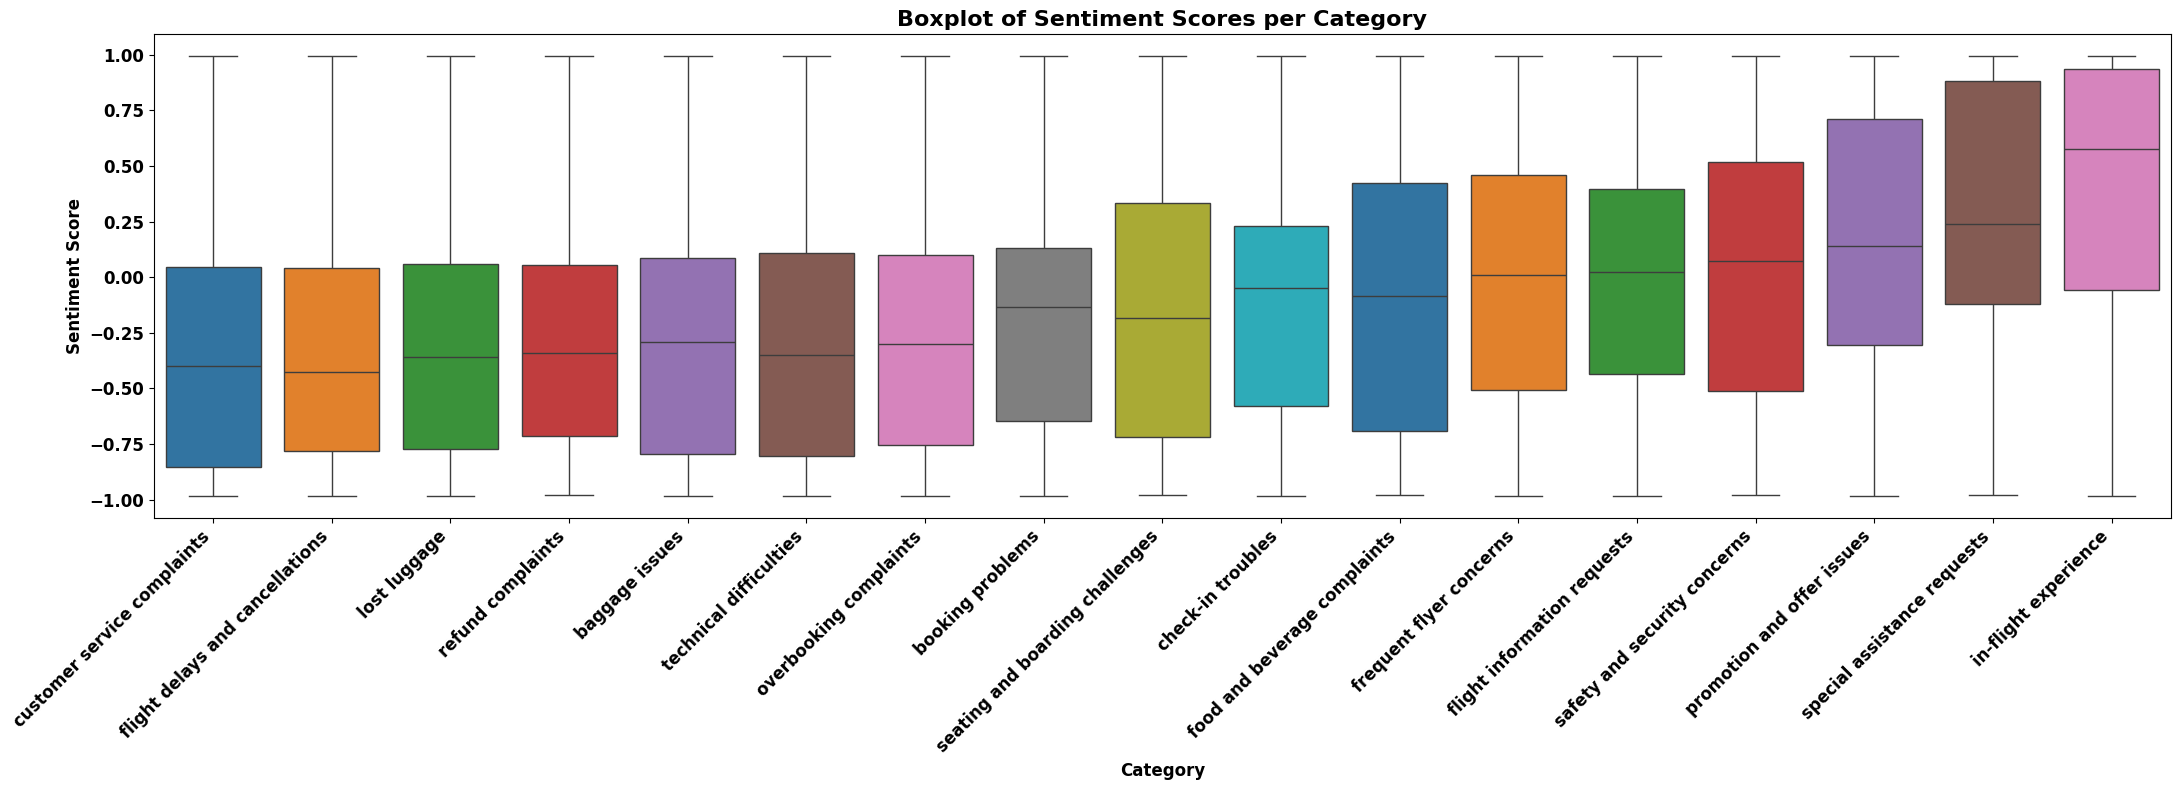

In [46]:
# Merge df_reset with df_categories on conversation_id
to_plot = pd.merge(df_reset, df_categories, on='conversation_id')

# Calculate the average sentiment score for each category
average_sentiment_per_category = to_plot.groupby('category')['sentiment_score'].mean()

# Sort the categories by the average sentiment score
sorted_categories = average_sentiment_per_category.sort_values().index

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the boxplot
plt.figure(figsize=(22, 8))
sns.boxplot(x='category', y='sentiment_score', data=to_plot, order=sorted_categories, palette=colors[:len(sorted_categories)])
plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=12, fontweight='bold')
plt.title('Boxplot of Sentiment Scores per Category', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold', ha='right')
plt.yticks(fontsize=12, fontweight='bold')

plt.tight_layout() 

# Sentiment evolution correct

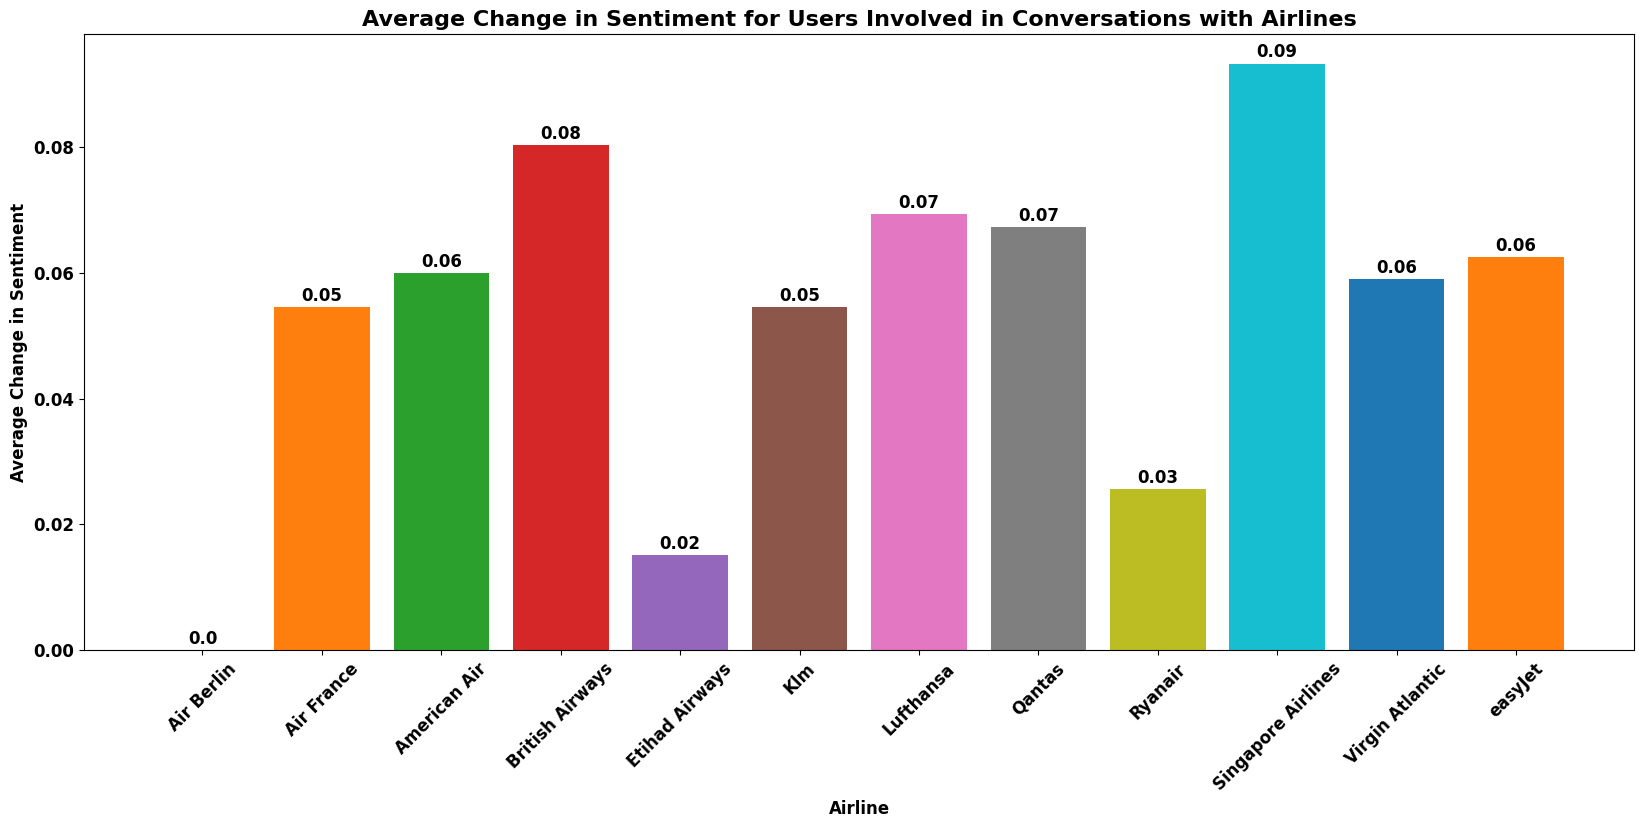

In [47]:
airline_conversations = merged_df.dropna(subset=['airline'])

# Find all unique conversations per airline
conversation_airlines = airline_conversations.groupby('airline')['conversation_id'].unique()

# Initialize list to hold data for plotting
plot_data = []

# Iterate over each airline and calculate the average change_in_sentiment for all users involved in conversations with that airline
for airline, conversations in conversation_airlines.items():
    users_in_conversations = merged_df[merged_df['conversation_id'].isin(conversations)]
    avg_change = users_in_conversations['change_in_sentiment'].mean()
    plot_data.append({'airline': airline, 'avg_change_in_sentiment': avg_change})

# Convert plot_data to a DataFrame
plot_df = pd.DataFrame(plot_data)

# Define a discrete colormap
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(plot_df['airline'], plot_df['avg_change_in_sentiment'], color=colors[:len(plot_df['airline'])])
plt.xlabel('Airline', fontsize=12, fontweight='bold')
plt.ylabel('Average Change in Sentiment', fontsize=12, fontweight='bold')
plt.title('Average Change in Sentiment for Users Involved in Conversations with Airlines', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.001, round(yval, 2), ha='center', fontsize=12, fontweight='bold')


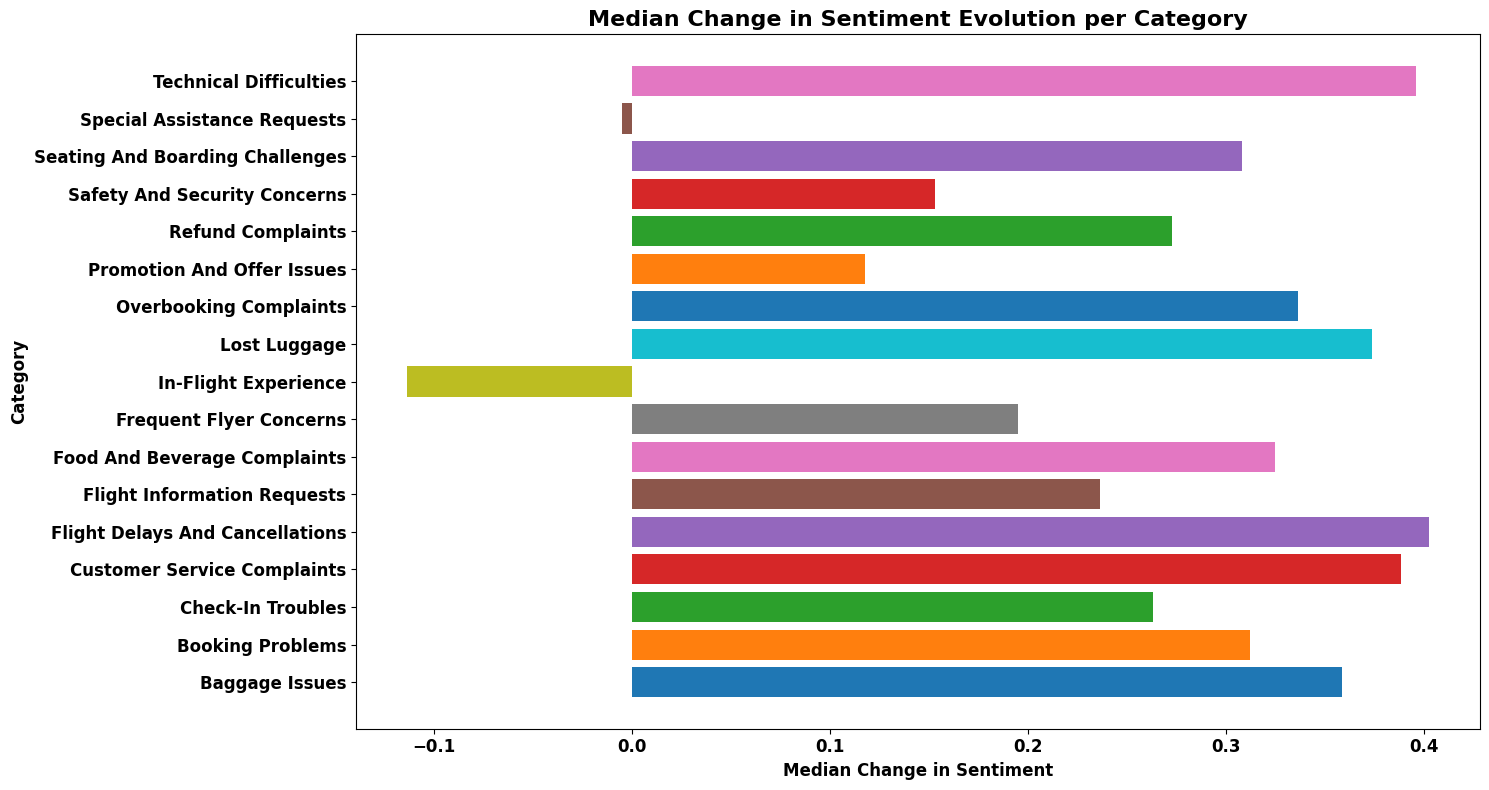

In [48]:
# Merge the dataframes on conversation_id to check
merge_to_check = pd.merge(df_categories, df_conversations, on='conversation_id')

# Calculate the number of tweets per conversation
conversation_length = merge_to_check['conversation_id'].value_counts()

# Filter out conversations with fewer than 3 tweets
valid_conversations = conversation_length[conversation_length >= 3].index

# Merge the dataframes on conversation_id
merged_data = pd.merge(df_categories, merged_df, on='conversation_id')

# Filter out valid conversations and those without airline information
filtered_data = merged_data[merged_data['conversation_id'].isin(valid_conversations)]
filtered_data = filtered_data[filtered_data['airline'].isna()]

# Calculate the median change_in_sentiment per category
median_sentiment_change = filtered_data.groupby('category')['change_in_sentiment'].mean().reset_index()

# Capitalize all y-axis labels (categories)
median_sentiment_change['category'] = median_sentiment_change['category'].str.title()

# Define a color scheme using mcolors
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the median change_in_sentiment per category
plt.figure(figsize=(15, 8))
plt.barh(median_sentiment_change['category'], median_sentiment_change['change_in_sentiment'], color=colors[:len(median_sentiment_change)])
plt.xlabel('Median Change in Sentiment', fontsize=12, fontweight='bold')
plt.ylabel('Category', fontsize=12, fontweight='bold')
plt.title('Median Change in Sentiment Evolution per Category', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

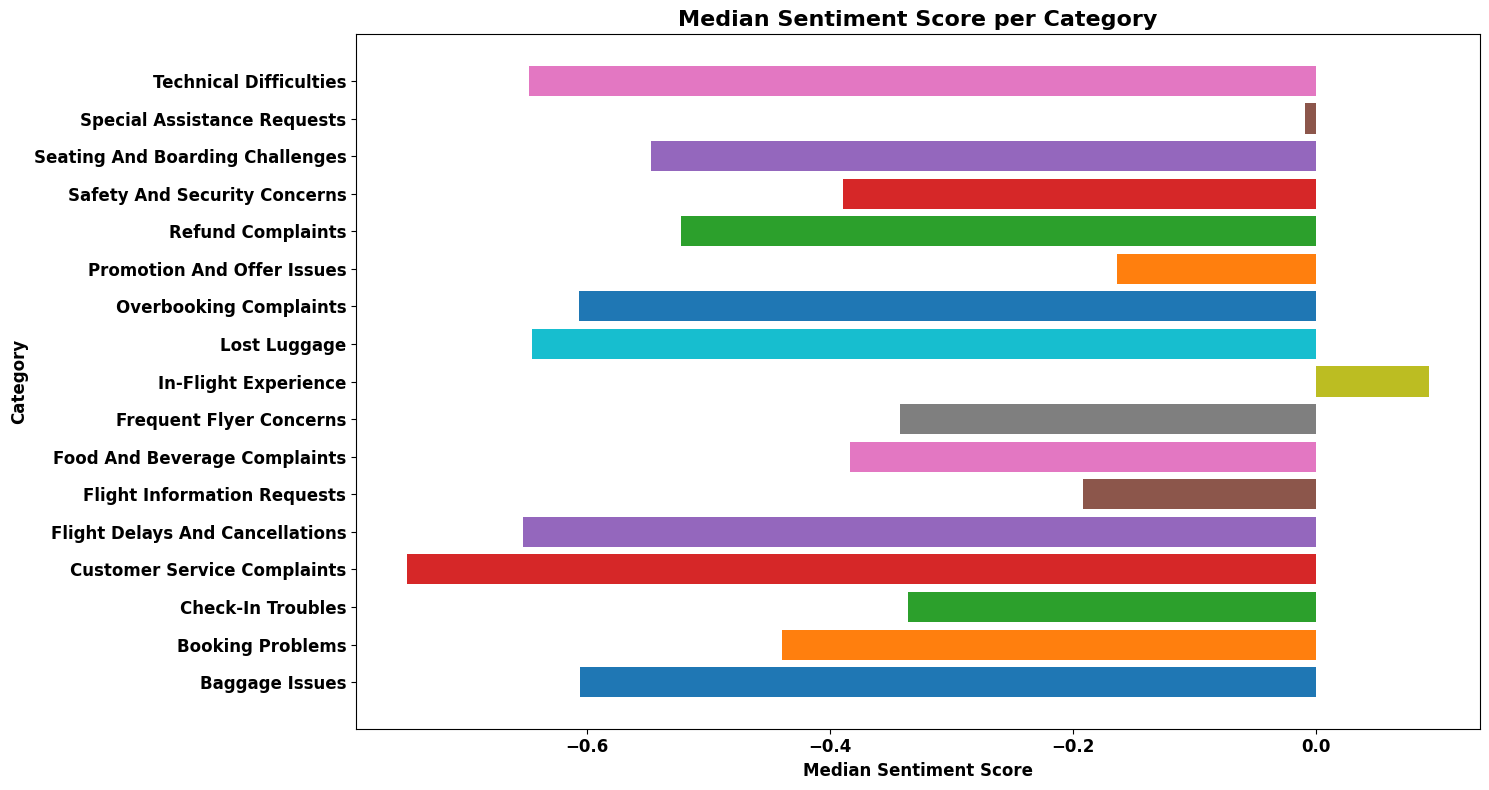

In [49]:
# Merge the dataframes on conversation_id to check
merge_to_check = pd.merge(df_reset, df_categories, on='conversation_id')

# Calculate the number of tweets per conversation
conversation_length = merge_to_check['conversation_id'].value_counts()

# Filter out conversations with fewer than 3 tweets
valid_conversations = conversation_length[conversation_length >= 3].index

# Merge the dataframes on conversation_id
# merged_data = pd.merge(df_categories, merged_df, on='conversation_id')

# Filter out valid conversations and those without airline information
filtered_data = merge_to_check[merge_to_check['conversation_id'].isin(valid_conversations)]
filtered_data = filtered_data[filtered_data['airline'].isna()]

# Calculate the median change_in_sentiment per category
median_sentiment_change = filtered_data.groupby('category')['sentiment_score'].median().reset_index()

# Capitalize all y-axis labels (categories)
median_sentiment_change['category'] = median_sentiment_change['category'].str.title()

# Define a color scheme using mcolors
colors = list(mcolors.TABLEAU_COLORS.values())

# Plot the median change_in_sentiment per category
plt.figure(figsize=(15, 8))
plt.barh(median_sentiment_change['category'], median_sentiment_change['sentiment_score'], color=colors[:len(median_sentiment_change)])
plt.xlabel('Median Sentiment Score', fontsize=12, fontweight='bold')
plt.ylabel('Category', fontsize=12, fontweight='bold')
plt.title('Median Sentiment Score per Category', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

In [50]:
filtered_data

conversation_id  tweet_order             tweet_id  \
10                     6            1  1244550514970329088   
12                     6            3  1244696257781805056   
17                     8            3  1244696138512556033   
23                    11            2  1241034899156545542   
25                    11            4  1242202731919675397   
...                  ...          ...                  ...   
1339082           493691            3   556251749502443521   
1339083           493692            1   495759235989647360   
1339085           493692            3   495770782791118849   
1339088           493694            1   452656989685178368   
1339090           493694            3   452657442057646080   

                    user_id        user_creation_time  \
10                 24527301 2009-03-15 14:06:49+00:00   
12                 24527301 2009-03-15 14:06:49+00:00   
17       778878987032559616 2016-09-22 08:49:56+00:00   
23                258132793 2011-02-27 01:33:08+00:00   
25                258132793 2011-02-27 01:33:08+00:00   
...                     ...                       ...   
1339082           350424184 2011-08-07 19:07:46+00:00   
1339083          2730826857 2014-08-01 16:26:01+00:00   
1339085          2730826857 2014-08-01 16:26:01+00:00   
1339088          2198564846 2013-11-16 23:24:47+00:00   
1339090          2198564846 2013-11-16 23:24:47+00:00   

              tweet_creation_time  \
10      2020-03-30 09:02:20+00:00   
12      2020-03-30 18:41:27+00:00   
17      2020-03-30 18:40:59+00:00   
23      2020-03-20 16:12:31+00:00   
25      2020-03-23 21:33:04+00:00   
...                           ...   
1339082 2015-01-17 00:48:46+00:00   
1339083 2014-08-03 02:33:07+00:00   
1339085 2014-08-03 03:19:00+00:00   
1339088 2014-04-06 04:00:10+00:00   
1339090 2014-04-06 04:01:58+00:00   

                                                 full_text lang country_code  \
10       @Grenzmauer75 @elliotday @easyJet Exactly. Do ...   en           un   
12       @easyJet I replied to your message at 10.17am ...   en           un   
17                        @easyJet https://t.co/XpPj1BE7Ga  und           un   
23       @VirginAtlantic Just been informed that flight...   en           un   
25       @VirginAtlantic 3days later still no contact f...   en           un   
...                                                    ...  ...          ...   
1339082  .@AmericanAir BOFA DEEZ NUTS, BITCH! http://t....   en           un   
1339083    @airfrance  j'ai mis une bombe dans un a avion.   fr           un   
1339085                                     @airfrance Mdr  und           un   
1339088  @AmericanAir Please help me!!  I've fallen on ...   en           un   
1339090           @AmericanAir They cannot hear my screams   en           un   

         sentiment_score airline                         category  confidence  
10             -0.855726     NaN                 booking problems    0.179878  
12             -0.647568     NaN                 booking problems    0.179878  
17              0.043121     NaN  flight delays and cancellations    0.225602  
23             -0.879518     NaN  flight delays and cancellations    0.286555  
25             -0.750443     NaN  flight delays and cancellations    0.286555  
...                  ...     ...                              ...         ...  
1339082        -0.503250     NaN                 booking problems    0.146947  
1339083        -0.058453     NaN                     lost luggage    0.156407  
1339085        -0.008492     NaN                     lost luggage    0.156407  
1339088        -0.791558     NaN                check-in troubles    0.148291  
1339090        -0.830774     NaN                check-in troubles    0.148291  

[409859 rows x 13 columns]

In [51]:
filtered_df = merged_df[merged_df['tweets_number'] >= 2]

# Exclude conversations associated with airlines
non_airline_df = filtered_df[filtered_df['airline'].isna()]

# Filter conversations with a change in sentiment greater than 0.2
high_sentiment_change_df = non_airline_df[non_airline_df['change_in_sentiment'].abs() >= 0.2]

# Calculate the total number of conversations with at least 2 tweets
total_conversations = len(filtered_df)

# Calculate the number of conversations with a change in sentiment greater than 0.2
high_sentiment_change_conversations = len(high_sentiment_change_df)

# Calculate the percentage
percentage = (high_sentiment_change_conversations / total_conversations) * 100

percentage

43.600360623503356